##### FINAL VERSION OF SCRIPT -  
Katrina Kalantar
April 2018

Analysis for mBAL microbe study

# Set-up

In [1]:
run_description = 'Running with Meningitis Pathogen List, NO water correction, Z-score > 1, dual RNA-seq (no DNA)'

## Environment Setup

In [2]:
# set the width of the jupyter notebook so we don't waste so much valuable browser real-estate!
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
# required libraries
from collections import Counter
import csv
import glob
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from pylab import *
import random
import seaborn as sns
import sklearn
import statistics
import scipy
import scipy.stats
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn.metrics import roc_curve
import sys, os.path
import warnings; warnings.simplefilter('ignore')
import ecopy

# import microbial analysis and plotting functions 
# developed by me, but moved to external scripts for simplicity in .ipynb
scripts_dir = './scripts/'
sys.path.append(scripts_dir)
import IDseq_pathogen_functions2 
import IDseq_plotting_functions

#https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
plt.style.use('fivethirtyeight')   
%matplotlib inline  

## Import Data

### Curated List of Top Respiratory Pathogens (and viruses)
Manually currated from papers and the NCBI taxonomy database

The **list_of_viruses_in_dictionary** contains all microbes which are listed as "Viruses". The **full_respiratory_microbes_list** contains all microbes identified as "likely pathogenic" in the respiratory tract.

In [4]:
# a priori curated list of all viruses
# to obtain this list (of all viruses in the samples), I ran `grep Viruses` 
# in all .csv report files in BM_4
v = open('./reference/viruses_bangldesh_uniq.txt', 'r').readlines()
list_of_viruses_in_dictionary = [i.strip() for i in v]

# Curated list of top respiratory pathogens
resp_mic = open('./reference/pathogens_bangladesh_official.txt', 'r').readlines()
full_respiratory_microbes_list = [i.strip() for i in resp_mic]

### Global Variables

In [5]:
data_directory =  '070518'
output_directory = '072018_Model_RNA_rank_ispatho'  

topX = 25 # because all microbes identified in culture are present among the top 15 microbes


# read in metadata to get RNA and DNA file names
metadata = pd.read_csv(
    './data/' + data_directory +
    '/combined_metadata.tsv',
    sep='\t',
    header=0,
    index_col=0)

print(metadata.shape)
print(len(metadata['sample_name_DNA']))
print(len(metadata['sample_name_RNA']))

metadata = metadata[metadata.index.notnull()]

# remove rows with null DNA filenames; some samples were missing DNA-seq data
#metadata = metadata[metadata['sample_name_DNA']
#                    .notnull()]  

# remove rows with null RNA filenames; no RNA-seq files should be missing
#metadata = metadata[metadata['sample_name_RNA']
#                    .notnull()] 

#print(metadata.head())
true_classification = ''

if('effective_group' in metadata.columns):
    # create the "true_classification" variable from the metadata  
    a = metadata[['sample_name_DNA','effective_group','organism']]
    b = metadata[['sample_name_RNA','effective_group','organism']]
    b.columns = ['sample_name_DNA','effective_group','organism']
    c = pd.concat([a,b])
    c.index = c['sample_name_DNA']
    c.sort_values(by='sample_name_DNA',inplace=True)
    c = c[c['sample_name_DNA'] != 'n/a']
    c = c[['effective_group','organism']]
    true_classification = c

else:
    effective_group = [2 for i in range(len(metadata.index))]
    organism = ['' for i in range(len(metadata.index))]
    c = pd.concat([metadata['sample_name_DNA'],metadata['sample_name_RNA']], axis=1)
    c['effective_group'] = pd.Series(effective_group, index = metadata.index)
    c['organism'] = pd.Series(organism, index = metadata.index)
    true_classification = c
    
print(true_classification.shape)
print(true_classification.head())

file_pairs_dict = pd.concat([metadata['sample_name_DNA'].fillna('none'),metadata['sample_name_RNA'].fillna('none')], axis=1)

'''
file_pairs_dict = dict(
    zip(metadata['sample_name_DNA'].fillna('none'), metadata['sample_name_RNA'].fillna('none')
        ))  #create dictionary mapping RNAfilename with associated DNAfilename

# create a reverse dictionary for file look-up from RNA:DNA later on
file_pairs_dict
file_pairs_dict_rev = {}
for i in file_pairs_dict.keys():
    file_pairs_dict_rev[file_pairs_dict[i]] = i
'''

description_file = open('./output/' + output_directory + '/run_description.txt','w')
description_file.write(run_description)
description_file.close()


(97, 58)
97
97
(194, 2)
                     effective_group                  organism
sample_name_DNA                                               
CHRF_DNA_0002_C_S4                 1  Streptococcus pneumoniae
CHRF_DNA_0003_C_S12                1  Streptococcus pneumoniae
CHRF_DNA_0004_C_S20                1  Streptococcus pneumoniae
CHRF_DNA_0005_C_S28                1   Enterobacter hormaechei
CHRF_DNA_0006_C_S36                4                       NaN


In [6]:
print([i for i in file_pairs_dict.index])

['CHRF_0000', 'CHRF_0001', 'CHRF_0002', 'CHRF_0003', 'CHRF_0004', 'CHRF_0005', 'CHRF_0006', 'CHRF_0007', 'CHRF_0008', 'CHRF_0009', 'CHRF_0010', 'CHRF_0011', 'CHRF_0012', 'CHRF_0013', 'CHRF_0014', 'CHRF_0015', 'CHRF_0016', 'CHRF_0017', 'CHRF_0018', 'CHRF_0019', 'CHRF_0020', 'CHRF_0021', 'CHRF_0022', 'CHRF_0023', 'CHRF_0024', 'CHRF_0025', 'CHRF_0026', 'CHRF_0027', 'CHRF_0028', 'CHRF_0029', 'CHRF_0030', 'CHRF_0031', 'CHRF_0032', 'CHRF_0033', 'CHRF_0034', 'CHRF_0035', 'CHRF_0036', 'CHRF_0037', 'CHRF_0038', 'CHRF_0039', 'CHRF_0040', 'CHRF_0041', 'CHRF_0042', 'CHRF_0043', 'CHRF_0044', 'CHRF_0045', 'CHRF_0046', 'CHRF_0047', 'CHRF_0048', 'CHRF_0049', 'CHRF_0050', 'CHRF_0051', 'CHRF_0052', 'CHRF_0053', 'CHRF_0054', 'CHRF_0055', 'CHRF_0056', 'CHRF_0057', 'CHRF_0058', 'CHRF_0059', 'CHRF_0060', 'CHRF_0061', 'CHRF_0062', 'CHRF_0063', 'CHRF_0064', 'CHRF_0065', 'CHRF_0066', 'CHRF_0067', 'CHRF_0068', 'CHRF_0069', 'CHRF_0070', 'CHRF_0071', 'CHRF_0072', 'CHRF_0073', 'CHRF_0074', 'CHRF_0075', 'CHRF_0076'

In [7]:
# write the microbes used for this particular analysis to the output directory
open('./output/' + output_directory + '/USED.viruses.txt', 'w').write(
    '\n'.join(list_of_viruses_in_dictionary));
open('./output/' + output_directory + '/USED.known_respiratory_pathogens.txt',
     'w').write('\n'.join(full_respiratory_microbes_list));

# Run Analysis

Run the main functions to generate scores required for all further plotting steps.

In [8]:
# create the output file that will containg the top 20 microbes for each sample 
# with the caveat that all microbes must be present on both RNA-seq and 
# DNA-seq (with the exception of RNA viruses)
f = open('./output/' + output_directory + '/TableS4.csv', 'w')
f.close()

f = open('./output/' + output_directory + '/TableS4_lowcount.csv', 'w')
f.close()

dna_genus_water_subtraction = None #compute_water_subtraction(merge_dna)
rna_genus_water_subtraction = None #compute_water_subtraction(merge_rna)

# run the main function to load microbial data into the data structure for downstream analysis
main_output = IDseq_pathogen_functions2.main('data/' + data_directory, 
                                      'rr007_dna_reports', 'rapid-response-007_reports',
                                      file_pairs_dict, output_directory,
                                      metadata, subtract_dna = dna_genus_water_subtraction, 
                                            subtract_rna = rna_genus_water_subtraction, expect_DNA=False, expect_RNA = True)#True) 
bacterial = main_output[0]
viral = main_output[1]
full = main_output[2]

list_of_files = list(
    bacterial.keys())  # create list of RNA files for accessing the outputs




./data/070518/rapid-response-007_reports/chrf_rna_0000_s97.csv
./data/070518/rr007_dna_reports/none.csv
RNA
failed to read DNA file: ./data/070518/rr007_dna_reports/none.csv
<class 'FileNotFoundError'>
RNA shape in calculate_scores:
(2299, 29)
RNA HEAD
(132, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0       Bacteria         1301    10.5        3.5          75.4   
1       Bacteria         1301     0.9        0.4          75.4   
3       Bacteria         1301     1.2        2.4          75.4   
6       Bacteria         1301     0.1        1.5          75.4   
14      Bacteria         1301     0.6        0.7          75.4   

    genus_NT_zscore                            name  NR_rpm  
0               1.8             Streptococcus mitis     0.5  
1               1.8        Streptococcus pneumoniae    24.4  
3               1.8      Streptococcus thermophilus     0.2  
6               1.8        Streptococcus agalactiae     5.4  
14              1.8  Strepto

category_name                     Bacteria
genus_taxid                           1301
NT_rpm DNA                            10.5
NT_zscore DNA                          3.5
genus_NT_rpm DNA                      75.4
genus_NT_zscore DNA                    1.8
name_x                 Streptococcus mitis
NR_rpm DNA                             0.5
NT_rpm RNA                            10.5
NT_zscore RNA                          3.5
genus_NT_rpm RNA                      75.4
genus_NT_zscore RNA                    1.8
name_y                 Streptococcus mitis
NR_rpm RNA                             0.5
Name: 0, dtype: object
category_name                  Bacteria
genus_taxid                      150022
NT_rpm DNA                            2
NT_zscore DNA                       2.2
genus_NT_rpm DNA                    2.3
genus_NT_zscore DNA                 1.4
name_x                 Finegoldia magna
NR_rpm DNA                          0.7
NT_rpm RNA                            2
NT_zscore RNA  

category_name                     Bacteria
genus_taxid                           1301
NT_rpm DNA                            11.3
NT_zscore DNA                          3.8
genus_NT_rpm DNA                        99
genus_NT_zscore DNA                    2.7
name_x                 Streptococcus mitis
NR_rpm DNA                             0.6
NT_rpm RNA                            11.3
NT_zscore RNA                          3.8
genus_NT_rpm RNA                        99
genus_NT_zscore RNA                    2.7
name_y                 Streptococcus mitis
NR_rpm RNA                             0.6
Name: 0, dtype: object
category_name                            Bacteria
genus_taxid                                   724
NT_rpm DNA                                    9.9
NT_zscore DNA                                 3.1
genus_NT_rpm DNA                             20.3
genus_NT_zscore DNA                           2.5
name_x                 Haemophilus parainfluenzae
NR_rpm DNA               

category_name                          Bacteria
genus_taxid                                1301
NT_rpm DNA                              16162.5
NT_zscore DNA                                99
genus_NT_rpm DNA                        19144.3
genus_NT_zscore DNA                          99
name_x                 Streptococcus pneumoniae
NR_rpm DNA                               9375.1
NT_rpm RNA                              16162.5
NT_zscore RNA                                99
genus_NT_rpm RNA                        19144.3
genus_NT_zscore RNA                          99
name_y                 Streptococcus pneumoniae
NR_rpm RNA                               9375.1
Name: 0, dtype: object



./data/070518/rapid-response-007_reports/chrf_rna_0003_s3.csv
./data/070518/rr007_dna_reports/chrf_dna_0003_c_s12.csv
RNA
DNA
RNA shape in calculate_scores:
(3413, 29)
RNA HEAD
(218, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0        Viruses   -200687329    41.1       99.0  

category_name                    Viruses
genus_taxid                   -200687329
NT_rpm DNA                          41.1
NT_zscore DNA                         99
genus_NT_rpm DNA                       0
genus_NT_zscore DNA                    0
name_x                 Torque teno virus
NR_rpm DNA                          28.5
NT_rpm RNA                          41.1
NT_zscore RNA                         99
genus_NT_rpm RNA                       0
genus_NT_zscore RNA                    0
name_y                 Torque teno virus
NR_rpm RNA                          28.5
Name: 0, dtype: object
category_name                          Bacteria
genus_taxid                                1301
NT_rpm DNA                                 10.5
NT_zscore DNA                              14.5
genus_NT_rpm DNA                           17.4
genus_NT_zscore DNA                        -0.3
name_x                 Streptococcus pneumoniae
NR_rpm DNA                                    8
NT_rpm RNA         

category_name                               Bacteria
genus_taxid                                   447237
NT_rpm DNA                                     137.4
NT_zscore DNA                                     99
genus_NT_rpm DNA                               156.4
genus_NT_zscore DNA                               99
name_x                 Frondihabitans sp. PAMC 28766
NR_rpm DNA                                       2.7
NT_rpm RNA                                     137.4
NT_zscore RNA                                     99
genus_NT_rpm RNA                               156.4
genus_NT_zscore RNA                               99
name_y                 Frondihabitans sp. PAMC 28766
NR_rpm RNA                                       2.7
Name: 0, dtype: object
category_name                     Bacteria
genus_taxid                          32207
NT_rpm DNA                            90.9
NT_zscore DNA                         23.7
genus_NT_rpm DNA                     129.1
genus_NT_zscore DNA 

       tax_id                                               name  \
0      158836                            Enterobacter hormaechei   
1     1296536                        Enterobacter xiangfangensis   
2         550                               Enterobacter cloacae   
3     1812934  Enterobacter cloacae complex 'Hoffmann cluster...   
4     1915310            Enterobacter cloacae complex sp. ECNIH7   
5       61645                              Enterobacter asburiae   
6     1736701                          Enterobacter sp. 50858885   
7     2004400                          Enterobacter sp. TUM13743   
8      208224                                 Enterobacter kobei   
9     1566252                            Enterobacter sp. NFIX45   
10    1659719           Enterobacter cloacae complex sp. GN03164   
11    1686395                           Enterobacter sp. BIDMC87   
12     710646                              Enterobacter sp. 1033   
13    1027278                              Enter

RNA shape in calculate_scores:
(2388, 29)
RNA HEAD
(148, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
4       Bacteria         1298     4.1        5.4          49.2   
7       Bacteria         1298     1.3        3.5          49.2   
12      Bacteria         1298     0.3        0.7          49.2   
85      Bacteria         1654     0.1       -0.4          11.7   
87      Bacteria         1654     0.1        0.1          11.7   

    genus_NT_zscore                       name  NR_rpm  
4               4.7      Deinococcus gobiensis     0.1  
7               4.7    Deinococcus radiodurans     6.9  
12              4.7   Deinococcus geothermalis     0.2  
85              1.0           Actinomyces oris     0.3  
87              1.0  Actinomyces odontolyticus     3.9  
RNA HEAD2
(9, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
4        Bacteria         1298         4.1            5.4              49.2   
91       Bacteria      107

DNA
RNA shape in calculate_scores:
(3476, 29)
RNA HEAD
(365, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0       Bacteria        57493    30.5        5.5          75.1   
2       Bacteria        57493     5.0        2.5          75.1   
5       Bacteria        57493     0.1        5.8          75.1   
14      Bacteria        57493     0.9       -0.1          75.1   
15      Bacteria        57493     4.8        0.1          75.1   

    genus_NT_zscore                 name  NR_rpm  
0               3.5  Kocuria turfanensis     0.7  
2               3.5        Kocuria flava     0.3  
5               3.5      Kocuria polaris     1.2  
14              3.5   Kocuria rhizophila     0.8  
15              3.5    Kocuria palustris     1.5  
RNA HEAD2
(39, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0       Bacteria        57493        30.5            5.5              75.1   
33      Bacteria       332248         6.2            5.6   

Name: 41, dtype: object
category_name                      Bacteria
genus_taxid                          162027
NT_rpm DNA                              0.1
NT_zscore DNA                           1.1
genus_NT_rpm DNA                        0.1
genus_NT_zscore DNA                     0.7
name_x                 Haliangium ochraceum
NR_rpm DNA                              0.1
NT_rpm RNA                              0.1
NT_zscore RNA                           1.1
genus_NT_rpm RNA                        0.1
genus_NT_zscore RNA                     0.7
name_y                 Haliangium ochraceum
NR_rpm RNA                              0.1
Name: 40, dtype: object
category_name                                   Bacteria
genus_taxid                                       129957
NT_rpm DNA                                           0.1
NT_zscore DNA                                        3.3
genus_NT_rpm DNA                                     0.1
genus_NT_zscore DNA                                

       tax_id                              name        common_name  tax_level  \
0      110526              Kretzschmaria deusta                NaN          1   
1     1755186              Eutypa sp. 1 NV-2015                NaN          1   
2     1812702                   Eutypa linearis                NaN          1   
3       97096                       Eutypa lata                NaN          1   
4      190937              Eutypa sp. HKUCC 337                NaN          1   
5      140182                 Eutypa consobrina                NaN          1   
6      252224                Eutypa sp. SMH3580                NaN          1   
7         853      Faecalibacterium prausnitzii                NaN          1   
8      259315   uncultured Faecalibacterium sp.                NaN          1   
9       77044               Rosellinia necatrix                NaN          1   
10       5141                 Neurospora crassa                NaN          1   
11      40126              N

DNA
RNA shape in calculate_scores:
(2247, 29)
RNA HEAD
(215, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
12      Bacteria          914    21.8        5.8          42.9   
13      Bacteria          914     2.7        5.7          42.9   
22      Bacteria       242605    11.5        5.6          12.1   
23      Bacteria         1279    39.3        5.8          98.4   
24      Bacteria         1279     0.6       -0.2          98.4   

    genus_NT_zscore                          name  NR_rpm  
12              5.8       Nitrosomonas sp. Is79A3     0.2  
13              5.8            Nitrosomonas ureae     1.0  
22              5.6      Luteibacter rhizovicinus     0.1  
23              1.3  Staphylococcus saprophyticus     5.6  
24              1.3         Staphylococcus aureus    46.1  
RNA HEAD2
(41, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
12       Bacteria          914        21.8            5.8              42.9   
22 

category_name                      Bacteria
genus_taxid                             816
NT_rpm DNA                                1
NT_zscore DNA                           4.5
genus_NT_rpm DNA                        5.4
genus_NT_zscore DNA                     1.7
name_x                 Bacteroides fragilis
NR_rpm DNA                             19.8
NT_rpm RNA                                1
NT_zscore RNA                           4.5
genus_NT_rpm RNA                        5.4
genus_NT_zscore RNA                     1.7
name_y                 Bacteroides fragilis
NR_rpm RNA                             19.8
Name: 15, dtype: object
category_name                        Bacteria
genus_taxid                              2147
NT_rpm DNA                                0.9
NT_zscore DNA                             2.1
genus_NT_rpm DNA                            1
genus_NT_zscore DNA                       0.8
name_x                 Acholeplasma laidlawii
NR_rpm DNA                            

category_name                Viruses
genus_taxid                    12059
NT_rpm DNA                       9.3
NT_zscore DNA                     99
genus_NT_rpm DNA                 9.3
genus_NT_zscore DNA               99
name_x                 Enterovirus B
NR_rpm DNA                       8.9
NT_rpm RNA                       9.3
NT_zscore RNA                     99
genus_NT_rpm RNA                 9.3
genus_NT_zscore RNA               99
name_y                 Enterovirus B
NR_rpm RNA                       8.9
Name: 0, dtype: object
category_name                       Bacteria
genus_taxid                             1578
NT_rpm DNA                                 5
NT_zscore DNA                            3.4
genus_NT_rpm DNA                         9.5
genus_NT_zscore DNA                        0
name_x                 Lactobacillus reuteri
NR_rpm DNA                               0.5
NT_rpm RNA                                 5
NT_zscore RNA                            3.4
genus_NT_

category_name                            Bacteria
genus_taxid                                  1301
NT_rpm DNA                                    3.2
NT_zscore DNA                                 7.9
genus_NT_rpm DNA                             14.1
genus_NT_zscore DNA                          -0.4
name_x                 Streptococcus thermophilus
NR_rpm DNA                                    0.1
NT_rpm RNA                                    3.2
NT_zscore RNA                                 7.9
genus_NT_rpm RNA                             14.1
genus_NT_zscore RNA                          -0.4
name_y                 Streptococcus thermophilus
NR_rpm RNA                                    0.1
Name: 0, dtype: object
category_name                    Viruses
genus_taxid                        39744
NT_rpm DNA                           0.7
NT_zscore DNA                        100
genus_NT_rpm DNA                     0.7
genus_NT_zscore DNA                  100
name_x                 Mumps ru

category_name                    Viruses
genus_taxid                        11019
NT_rpm DNA                        1398.4
NT_zscore DNA                         99
genus_NT_rpm DNA                  1830.1
genus_NT_zscore DNA                   99
name_x                 Chikungunya virus
NR_rpm DNA                         568.6
NT_rpm RNA                        1398.4
NT_zscore RNA                         99
genus_NT_rpm RNA                  1830.1
genus_NT_zscore RNA                   99
name_y                 Chikungunya virus
NR_rpm RNA                         568.6
Name: 0, dtype: object
category_name                            Viruses
genus_taxid                              1511911
NT_rpm DNA                                1172.3
NT_zscore DNA                                 99
genus_NT_rpm DNA                            1175
genus_NT_zscore DNA                           99
name_x                 Primate tetraparvovirus 1
NR_rpm DNA                                 333.9
NT_rpm RNA 

category_name                     Bacteria
genus_taxid                        1912216
NT_rpm DNA                           224.3
NT_zscore DNA                          2.7
genus_NT_rpm DNA                     272.2
genus_NT_zscore DNA                    3.2
name_x                 Cutibacterium acnes
NR_rpm DNA                           409.2
NT_rpm RNA                           224.3
NT_zscore RNA                          2.7
genus_NT_rpm RNA                     272.2
genus_NT_zscore RNA                    3.2
name_y                 Cutibacterium acnes
NR_rpm RNA                           409.2
Name: 0, dtype: object
category_name                  Bacteria
genus_taxid                         561
NT_rpm DNA                        128.5
NT_zscore DNA                       1.6
genus_NT_rpm DNA                  143.3
genus_NT_zscore DNA                 1.3
name_x                 Escherichia coli
NR_rpm DNA                        230.9
NT_rpm RNA                        128.5
NT_zscore RNA  

      tax_id                                 name                common_name  \
0      68887                    Torque teno virus                        NaN   
1     432261               Torque teno midi virus                        NaN   
2     393049                    Small anellovirus                        NaN   
3      93678                  TTV-like mini virus                        NaN   
4    1535290         Torque teno mini virus ALA22                        NaN   
5    2065036        Unnamed species taxon 2065036                        NaN   
6     687373             Torque teno mini virus 5                        NaN   
7     387005                  Onchocerca flexuosa                        NaN   
8        128                   Isosphaera pallida                        NaN   
9       1313             Streptococcus pneumoniae                        NaN   
10    269666          Streptococcus marimammalium                        NaN   
11     28037                  Streptococ

       tax_id                                    name  common_name  tax_level  \
0     1511913               Primate tetraparvovirus 1          NaN          1   
1     1511914              Ungulate tetraparvovirus 1          NaN          1   
2       47877                    Pseudomonas amygdali          NaN          1   
3         316                    Pseudomonas stutzeri          NaN          1   
4         317                    Pseudomonas syringae          NaN          1   
5       29438                  Pseudomonas savastanoi          NaN          1   
6       33069                 Pseudomonas viridiflava          NaN          1   
7      251701  Pseudomonas syringae group genomosp. 3          NaN          1   
8       29442                    Pseudomonas tolaasii          NaN          1   
9     1500686                    Pseudomonas sp. Os17          NaN          1   
10     114707              uncultured Pseudomonas sp.          NaN          1   
11     150396               

DNA
RNA shape in calculate_scores:
(2858, 29)
RNA HEAD
(262, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
4       Bacteria       146935     0.1      100.0           3.1   
6       Bacteria         1060    22.3       46.4          41.1   
7       Bacteria         1060     8.9       40.7          41.1   
11      Bacteria         1060     2.1        2.7          41.1   
23      Bacteria        46255     0.9      100.0          30.2   

    genus_NT_zscore                     name  NR_rpm  
4             100.0     Azovibrio restrictus     4.0  
6              27.3  Rhodobacter sp. LPB0142     0.1  
7              27.3   Rhodobacter capsulatus     0.7  
11             27.3  Rhodobacter sphaeroides     0.1  
23             20.7      Weissella hellenica     0.3  
RNA HEAD2
(53, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
4       Bacteria       146935         0.1          100.0               3.1   
6       Bacteria         1060      

Name: 16, dtype: object
category_name                             Bacteria
genus_taxid                                  89966
NT_rpm DNA                                     1.3
NT_zscore DNA                                  3.9
genus_NT_rpm DNA                               4.9
genus_NT_zscore DNA                           -0.1
name_x                 Hymenobacter sp. PAMC 26554
NR_rpm DNA                                     0.1
NT_rpm RNA                                     1.3
NT_zscore RNA                                  3.9
genus_NT_rpm RNA                               4.9
genus_NT_zscore RNA                           -0.1
name_y                 Hymenobacter sp. PAMC 26554
NR_rpm RNA                                     0.1
Name: 17, dtype: object
category_name                    Bacteria
genus_taxid                           816
NT_rpm DNA                              1
NT_zscore DNA                         4.4
genus_NT_rpm DNA                      4.8
genus_NT_zscore DNA         

Name: 6, dtype: object



./data/070518/rapid-response-007_reports/chrf_rna_0018_s18.csv
./data/070518/rr007_dna_reports/chrf_dna_0018_c_s37.csv
RNA
DNA
RNA shape in calculate_scores:
(2064, 29)
RNA HEAD
(173, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0       Bacteria          590    12.6        1.7          12.7   
7       Bacteria        37914     0.5       -0.2           0.9   
12      Bacteria          848     1.4        3.4           3.8   
21       Viruses       333922     0.5        5.8           0.5   
41      Bacteria         1357     2.1        1.9           2.2   

    genus_NT_zscore                     name  NR_rpm  
0               1.8      Salmonella enterica    44.8  
7              -0.2       Dietzia timorensis     0.1  
12              4.2  Fusobacterium nucleatum     1.8  
21              4.9     Betapapillomavirus 4     0.5  
41              1.4       Lactococcus lactis     1.8  
RNA HEAD2
(24, 8)
   category_name  genus_taxid  NT_rpm RNA 

DNA
RNA shape in calculate_scores:
(2086, 29)
RNA HEAD
(205, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
7       Bacteria      1912216   188.6        2.1         199.1   
11      Bacteria          613    37.8        5.8         107.6   
12      Bacteria          613     0.8        2.4         107.6   
18      Bacteria          613     0.2        0.7         107.6   
20      Bacteria         1301    14.7        5.8         134.9   

    genus_NT_zscore                       name  NR_rpm  
7               2.1        Cutibacterium acnes   242.8  
11              5.8      Serratia liquefaciens     0.6  
12              5.8        Serratia marcescens     3.6  
18              5.8    Serratia proteamaculans     0.2  
20              4.0  Streptococcus lutetiensis     1.5  
RNA HEAD2
(73, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
7       Bacteria      1912216       188.6            2.1             199.1   
11      Bacteria       

Name: 29, dtype: object
category_name                     Bacteria
genus_taxid                         149698
NT_rpm DNA                             2.5
NT_zscore DNA                            2
genus_NT_rpm DNA                      14.3
genus_NT_zscore DNA                    0.8
name_x                 Massilia sp. NR 4-1
NR_rpm DNA                             0.2
NT_rpm RNA                             2.5
NT_zscore RNA                            2
genus_NT_rpm RNA                      14.3
genus_NT_zscore RNA                    0.8
name_y                 Massilia sp. NR 4-1
NR_rpm RNA                             0.2
Name: 28, dtype: object
category_name                              Bacteria
genus_taxid                                    1678
NT_rpm DNA                                      2.1
NT_zscore DNA                                   1.9
genus_NT_rpm DNA                                6.7
genus_NT_zscore DNA                             2.7
name_x                 Bifidobacterium

RNA HEAD
(425, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
79      Bacteria        33882   102.1        5.8         451.6   
80      Bacteria        33882    51.9        5.8         451.6   
83      Bacteria        33882     0.3        5.8         451.6   
84      Bacteria        33882     1.5        5.3         451.6   
85      Bacteria        33882     1.7        5.3         451.6   

    genus_NT_zscore                       name  NR_rpm  
79              5.8   Microbacterium sp. LKL04     1.5  
80              5.8    Microbacterium foliorum     1.1  
83              5.8  Microbacterium oleivorans     2.5  
84              5.8    Microbacterium sp. CGR1     0.3  
85              5.8    Microbacterium sp. XT11     0.3  
RNA HEAD2
(130, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
79       Bacteria        33882       102.1            5.8             451.6   
209      Bacteria        41275        46.6            5.8         

category_name                           Bacteria
genus_taxid                                83461
NT_rpm DNA                                   5.6
NT_zscore DNA                                4.5
genus_NT_rpm DNA                             6.9
genus_NT_zscore DNA                          4.8
name_x                 Corallococcus coralloides
NR_rpm DNA                                   0.3
NT_rpm RNA                                   5.6
NT_zscore RNA                                4.5
genus_NT_rpm RNA                             6.9
genus_NT_zscore RNA                          4.8
name_y                 Corallococcus coralloides
NR_rpm RNA                                   0.3
Name: 39, dtype: object
category_name                        Bacteria
genus_taxid                            323449
NT_rpm DNA                                5.2
NT_zscore DNA                             5.7
genus_NT_rpm DNA                         13.5
genus_NT_zscore DNA                       5.6
name_x        

DNA
RNA shape in calculate_scores:
(2857, 29)
RNA HEAD
(256, 8)
  category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0      Bacteria         1279    16.3        2.2         267.8   
1      Bacteria         1279    33.0        5.3         267.8   
2      Bacteria         1279    16.7        4.7         267.8   
3      Bacteria         1279     0.7        1.9         267.8   
4      Bacteria         1279     5.9        3.4         267.8   

   genus_NT_zscore                         name  NR_rpm  
0              4.9        Staphylococcus aureus   205.4  
1              4.9   Staphylococcus epidermidis    11.0  
2              4.9  Staphylococcus haemolyticus     0.2  
3              4.9   Staphylococcus lugdunensis     7.9  
4              4.9       Staphylococcus hominis     0.3  
RNA HEAD2
(82, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
1       Bacteria         1279        33.0            5.3             267.8   
40      Bacteria       

Name: 6, dtype: object
category_name                           Bacteria
genus_taxid                                42255
NT_rpm DNA                                   9.2
NT_zscore DNA                                5.8
genus_NT_rpm DNA                            13.8
genus_NT_zscore DNA                          5.7
name_x                 Rubrobacter radiotolerans
NR_rpm DNA                                   0.3
NT_rpm RNA                                   9.2
NT_zscore RNA                                5.8
genus_NT_rpm RNA                            13.8
genus_NT_zscore RNA                          5.7
name_y                 Rubrobacter radiotolerans
NR_rpm RNA                                   0.3
Name: 7, dtype: object
category_name                         Bacteria
genus_taxid                               1578
NT_rpm DNA                                 8.2
NT_zscore DNA                              3.4
genus_NT_rpm DNA                          59.9
genus_NT_zscore DNA              

       tax_id                                name     common_name  tax_level  \
0       74082                   Vahlkampfia avara             NaN          1   
1       78587           Asticcacaulis excentricus             NaN          1   
2     1282363            Asticcacaulis sp. YBE204             NaN          1   
3     1282360             Asticcacaulis sp. AC460             NaN          1   
4     1282362             Asticcacaulis sp. AC466             NaN          1   
5      265211        uncultured Asticcacaulis sp.             NaN          1   
6      347481          Asticcacaulis benevestitus             NaN          1   
7       76891         Asticcacaulis biprosthecium             NaN          1   
8     1282361             Asticcacaulis sp. AC402             NaN          1   
9      112494           Paramycosphaerella parkii             NaN          1   
10      80876        Insolitispirillum peregrinum             NaN          1   
11    1720261              Telluribacter

RNA shape in calculate_scores:
(4852, 29)
RNA HEAD
(558, 8)
  category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0      Bacteria      1055688   298.1       99.0         299.6   
1      Bacteria       469322   100.5       99.0         114.0   
3      Bacteria           50    85.1       99.0          88.4   
5      Bacteria        39643    52.3       99.0          54.4   
6      Bacteria          413     0.1        1.7           0.1   

   genus_NT_zscore                          name  NR_rpm  
0             99.0     Sandaracinus amylolyticus     2.4  
1             99.0  Steroidobacter denitrificans     0.5  
3             99.0         Chondromyces crocatus     0.3  
5             99.0          Sorangium cellulosum     1.4  
6              1.7      Methylococcus capsulatus    32.3  
RNA HEAD2
(116, 8)
  category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0      Bacteria      1055688       298.1           99.0             299.6   
1      Bacteria       

Name: 21, dtype: object
category_name                          Bacteria
genus_taxid                               89966
NT_rpm DNA                                  3.5
NT_zscore DNA                               1.1
genus_NT_rpm DNA                           14.9
genus_NT_zscore DNA                         0.9
name_x                 Hymenobacter sedentarius
NR_rpm DNA                                  0.1
NT_rpm RNA                                  3.5
NT_zscore RNA                               1.1
genus_NT_rpm RNA                           14.9
genus_NT_zscore RNA                         0.9
name_y                 Hymenobacter sedentarius
NR_rpm RNA                                  0.1
Name: 22, dtype: object
category_name                        Bacteria
genus_taxid                               482
NT_rpm DNA                                2.9
NT_zscore DNA                             2.5
genus_NT_rpm DNA                         16.1
genus_NT_zscore DNA                       2.6
name

       tax_id                                    name     common_name  \
0      687355                    Torque teno virus 16             NaN   
1      687359                    Torque teno virus 20             NaN   
2      687352                    Torque teno virus 13             NaN   
3      687342                     Torque teno virus 3             NaN   
4      687347                     Torque teno virus 8             NaN   
5      455371                  Spatholobus suberectus             NaN   
6       68887                       Torque teno virus             NaN   
7     1743410                  Chimpanzee anellovirus             NaN   
8      136966                               SEN virus             NaN   
9      432261                  Torque teno midi virus             NaN   
10      16719                           Juglans nigra    black walnut   
11      51240                           Juglans regia  English walnut   
12     432290         Juglans hindsii x Juglans reg

       tax_id                                    name      common_name  \
0       68887                       Torque teno virus              NaN   
1     1034771                  uncultured Anellovirus              NaN   
2      687344                     Torque teno virus 5              NaN   
3      687358                    Torque teno virus 19              NaN   
4      687342                     Torque teno virus 3              NaN   
5      687369                Torque teno mini virus 1              NaN   
6       93678                     TTV-like mini virus              NaN   
7      161536        Ornithinibacillus californiensis              NaN   
8      572305        uncultured Ornithinibacillus sp.              NaN   
9      545502           Ornithinibacillus bavariensis              NaN   
10      82525                      Tausonia pullulans              NaN   
11     411798                      Vollenhovia emeryi              NaN   
12     364728                      The

      tax_id                                               name  \
0       1313                           Streptococcus pneumoniae   
1      28037                                Streptococcus mitis   
2     257758                     Streptococcus pseudopneumoniae   
3       1303                               Streptococcus oralis   
4    1095727                            Streptococcus sp. SK643   
5    1403937                          Streptococcus sp. DORA_10   
6       1349                               Streptococcus uberis   
7     313439                         Streptococcus massiliensis   
8     361101                       Streptococcus pseudoporcinus   
9    1715092                       Streptococcus sp. HMSC070B10   
10   1715107                       Streptococcus sp. HMSC063B03   
11   1777879                             Streptococcus sp. DD11   
12     68891                              Streptococcus peroris   
13      1311                           Streptococcus agalactia

(2177, 29)
category_name                        Bacteria
genus_taxid                               724
NT_rpm DNA                               54.3
NT_zscore DNA                            64.3
genus_NT_rpm DNA                         56.3
genus_NT_zscore DNA                       8.8
name_x                 Haemophilus influenzae
NR_rpm DNA                               20.3
NT_rpm RNA                               54.3
NT_zscore RNA                            64.3
genus_NT_rpm RNA                         56.3
genus_NT_zscore RNA                       8.8
name_y                 Haemophilus influenzae
NR_rpm RNA                               20.3
Name: 0, dtype: object
category_name                         Bacteria
genus_taxid                               1234
NT_rpm DNA                                 4.9
NT_zscore DNA                              1.9
genus_NT_rpm DNA                          17.2
genus_NT_zscore DNA                        2.7
name_x                 Nitrospira moscov

category_name                   Bacteria
genus_taxid                        13687
NT_rpm DNA                         127.8
NT_zscore DNA                       32.9
genus_NT_rpm DNA                   798.5
genus_NT_zscore DNA                 17.1
name_x                 Sphingomonas taxi
NR_rpm DNA                           0.6
NT_rpm RNA                         127.8
NT_zscore RNA                       32.9
genus_NT_rpm RNA                   798.5
genus_NT_zscore RNA                 17.1
name_y                 Sphingomonas taxi
NR_rpm RNA                           0.6
Name: 0, dtype: object
category_name                       Bacteria
genus_taxid                              469
NT_rpm DNA                              28.3
NT_zscore DNA                           15.3
genus_NT_rpm DNA                        69.8
genus_NT_zscore DNA                      0.1
name_x                 Acinetobacter lwoffii
NR_rpm DNA                               0.2
NT_rpm RNA                              28.

       tax_id                                        name  \
0     1117645                   Elizabethkingia anophelis   
1      172045                    Elizabethkingia miricola   
2         238              Elizabethkingia meningoseptica   
3      432638              uncultured Elizabethkingia sp.   
4     1756149                 Elizabethkingia genomosp. 3   
5     1756718                    Elizabethkingia sp. VV60   
6     1873419                   Elizabethkingia sp. C1558   
7     1756150                 Elizabethkingia genomosp. 4   
8     1756715                    Elizabethkingia sp. VV11   
9      519809                    Elizabethkingia sp. CH2B   
10     713571                     Elizabethkingia sp. CH2   
11    1221621                  Elizabethkingia sp. LA1-18   
12    1602902                    Elizabethkingia sp. B914   
13    1756713                     Elizabethkingia sp. VV1   
14    1867263                   Elizabethkingia sp. G4070   
15    1056979           

DNA
RNA shape in calculate_scores:
(1755, 29)
RNA HEAD
(89, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
16      Bacteria       323449     0.4        0.2           0.9   
19      Bacteria       323449     0.3        0.5           0.9   
20      Bacteria       323449     0.1       -0.1           0.9   
30      Bacteria          407     4.2        0.5          66.0   
31      Bacteria          407     1.1       -0.1          66.0   

    genus_NT_zscore                        name  NR_rpm  
16              0.0      Pontibacter akesuensis     0.5  
19              0.0       Pontibacter korlensis     0.3  
20              0.0      Pontibacter actiniarum     0.2  
30              0.1  Methylobacterium aquaticum     0.4  
31              0.1     Methylobacterium populi     2.4  
RNA HEAD2
(3, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
77        Viruses        10912         0.1            2.0               0.1   
132      Bacteria

DNA
RNA shape in calculate_scores:
(2386, 29)
RNA HEAD
(173, 8)
    category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0        Bacteria         1847   173.5        5.8         462.6   
1        Bacteria         1847    20.5        5.5         462.6   
34       Bacteria        38501   149.4        5.8         206.2   
44       Bacteria        88138    74.0        5.3          76.2   
105      Bacteria         1827     0.2        0.1           9.3   

     genus_NT_zscore                            name  NR_rpm  
0                5.5    Pseudonocardia dioxanivorans     0.2  
1                5.5  Pseudonocardia sp. HH130629-09     0.1  
34               5.8        Blastococcus saxobsidens     0.2  
44               5.3           Modestobacter marinus    25.0  
105              0.2              Rhodococcus opacus     0.1  
RNA HEAD2
(22, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0        Bacteria         1847       173.5            5.8 

Name: 17, dtype: object
category_name                             Bacteria
genus_taxid                                 909928
NT_rpm DNA                                     0.2
NT_zscore DNA                                    4
genus_NT_rpm DNA                               0.4
genus_NT_zscore DNA                            4.7
name_x                 Negativicoccus massiliensis
NR_rpm DNA                                     0.1
NT_rpm RNA                                     0.2
NT_zscore RNA                                    4
genus_NT_rpm RNA                               0.4
genus_NT_zscore RNA                            4.7
name_y                 Negativicoccus massiliensis
NR_rpm RNA                                     0.1
Name: 18, dtype: object
category_name                         Bacteria
genus_taxid                            1506553
NT_rpm DNA                                 0.2
NT_zscore DNA                                5
genus_NT_rpm DNA                           3.3
gen

category_name                     Bacteria
genus_taxid                            590
NT_rpm DNA                            12.2
NT_zscore DNA                          1.5
genus_NT_rpm DNA                      12.7
genus_NT_zscore DNA                    1.8
name_x                 Salmonella enterica
NR_rpm DNA                            43.6
NT_rpm RNA                            12.2
NT_zscore RNA                          1.5
genus_NT_rpm RNA                      12.7
genus_NT_zscore RNA                    1.8
name_y                 Salmonella enterica
NR_rpm RNA                            43.6
Name: 0, dtype: object
category_name                            Viruses
genus_taxid                              1511911
NT_rpm DNA                                  10.2
NT_zscore DNA                                5.8
genus_NT_rpm DNA                            10.2
genus_NT_zscore DNA                          5.8
name_x                 Primate tetraparvovirus 1
NR_rpm DNA                      

       tax_id                                               name  \
0      561152                         Scopulariopsis brevicaulis   
1      129951                             Human mastadenovirus C   
2       12321                               Alfalfa mosaic virus   
3     1473216                         Senegalimassilia anaerobia   
4     1188228                          Gloeomargarita lithophora   
5     1335746                                Spiribacter salinus   
6     1306787                              Alcanivorax pacificus   
7       35722                             Parasitella parasitica   
8      248742                           Coccomyxa subellipsoidea   
9       41688                           Lomentospora prolificans   
10     244582               Candidatus Paracaedibacter symbiosus   
11     591197                              Ignavibacterium album   
12     510350                             Lutimonas sp. MOLA 323   
13     235931                    Alkalibacter sa

       tax_id                               name                  common_name  \
0       76773                 Malassezia globosa                          NaN   
1       76777             Malassezia sympodialis                          NaN   
2       77020           Malassezia pachydermatis                          NaN   
3     1514897              Malassezia arunalokei                          NaN   
4       76775               Malassezia restricta                          NaN   
5       55194                  Malassezia furfur                          NaN   
6       76774                  Malassezia obtusa                          NaN   
7      253288             Malassezia yamatoensis                          NaN   
8     1521554                Jaaginema geminatum                          NaN   
9       56187                   Coprinus comatus                          NaN   
10       1747                Cutibacterium acnes                          NaN   
11      33010               

      tax_id                                               name  \
0      68887                                  Torque teno virus   
1     432261                             Torque teno midi virus   
2     136966                                          SEN virus   
3    1743411                                Gorilla anellovirus   
4     687355                               Torque teno virus 16   
5     687351                               Torque teno virus 12   
6     687349                               Torque teno virus 10   
7     687344                                Torque teno virus 5   
8     687342                                Torque teno virus 3   
9     687358                               Torque teno virus 19   
10     93678                                TTV-like mini virus   
11    687370                           Torque teno mini virus 2   
12    687369                           Torque teno mini virus 1   
13    687371                           Torque teno mini virus 

       tax_id                                    name     common_name  \
0      387005                     Onchocerca flexuosa             NaN   
1      693312              Leptosporomyces raunkiaeri             NaN   
2      205750        Acanthophysellum lividocoeruleum             NaN   
3      187695                       Sinella curviseta             NaN   
4     1712292                 Amblyseius sp. ARP-2015             NaN   
5       84387                       Typhlodromus pyri             NaN   
6       99802             Spirometra erinaceieuropaei             NaN   
7       33188                     Uncinocarpus reesii             NaN   
8       68887                       Torque teno virus             NaN   
9     1768779                 Dermacoccus sp. CCH2-D9             NaN   
10       1274            Dermacoccus nishinomiyaensis             NaN   
11     188626                Dermacoccus sp. Ellin185             NaN   
12     489910                Nosocomiicoccus ampull

category_name                          Bacteria
genus_taxid                                1301
NT_rpm DNA                                    7
NT_zscore DNA                               9.4
genus_NT_rpm DNA                            7.5
genus_NT_zscore DNA                        -0.6
name_x                 Streptococcus pneumoniae
NR_rpm DNA                                    4
NT_rpm RNA                                    7
NT_zscore RNA                               9.4
genus_NT_rpm RNA                            7.5
genus_NT_zscore RNA                        -0.6
name_y                 Streptococcus pneumoniae
NR_rpm RNA                                    4
Name: 0, dtype: object
category_name                    Viruses
genus_taxid                   -200687329
NT_rpm DNA                           0.5
NT_zscore DNA                       22.8
genus_NT_rpm DNA                       0
genus_NT_zscore DNA                    0
name_x                 Torque teno virus
NR_rpm DNA        

Name: 2, dtype: object
category_name                              Bacteria
genus_taxid                                    1763
NT_rpm DNA                                      2.1
NT_zscore DNA                                   7.3
genus_NT_rpm DNA                                3.5
genus_NT_zscore DNA                            -0.4
name_x                 uncultured Mycobacterium sp.
NR_rpm DNA                                      0.2
NT_rpm RNA                                      2.1
NT_zscore RNA                                   7.3
genus_NT_rpm RNA                                3.5
genus_NT_zscore RNA                            -0.4
name_y                 uncultured Mycobacterium sp.
NR_rpm RNA                                      0.2
Name: 3, dtype: object
category_name                           Bacteria
genus_taxid                                 1716
NT_rpm DNA                                   0.8
NT_zscore DNA                                1.4
genus_NT_rpm DNA              

RNA
DNA
RNA shape in calculate_scores:
(5646, 29)
RNA HEAD
(571, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
2       Bacteria          209     3.0       96.2           3.0   
5       Bacteria       165779    57.1       19.5          71.6   
14      Bacteria          475    69.3       11.6          71.5   
34      Bacteria       529883     0.5        9.8           0.6   
35      Bacteria       529883     0.2        1.2           0.6   

    genus_NT_zscore                              name  NR_rpm  
2              85.0               Helicobacter pylori     0.3  
5              14.4             Anaerococcus prevotii     3.1  
14              7.9               Moraxella osloensis    16.2  
34              3.9                Rhodoluna lacicola     0.5  
35              3.9  Candidatus Rhodoluna planktonica     0.2  
RNA HEAD2
(113, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
2       Bacteria          209         3.0           96

category_name                     Bacteria
genus_taxid                            475
NT_rpm DNA                            69.3
NT_zscore DNA                         11.6
genus_NT_rpm DNA                      71.5
genus_NT_zscore DNA                    7.9
name_x                 Moraxella osloensis
NR_rpm DNA                            16.2
NT_rpm RNA                            69.3
NT_zscore RNA                         11.6
genus_NT_rpm RNA                      71.5
genus_NT_zscore RNA                    7.9
name_y                 Moraxella osloensis
NR_rpm RNA                            16.2
Name: 0, dtype: object
category_name                       Bacteria
genus_taxid                           165779
NT_rpm DNA                              57.1
NT_zscore DNA                           19.5
genus_NT_rpm DNA                        71.6
genus_NT_zscore DNA                     14.4
name_x                 Anaerococcus prevotii
NR_rpm DNA                               3.1
NT_rpm RNA     

RNA
DNA
RNA shape in calculate_scores:
(1682, 29)
RNA HEAD
(109, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0       Bacteria          570     1.6       60.1          21.0   
1       Bacteria          570     6.6        6.3          21.0   
3       Bacteria          570     0.4       11.4          21.0   
5       Bacteria          570     0.1        2.3          21.0   
10       Viruses       140568     0.1      100.0           0.1   

    genus_NT_zscore                        name  NR_rpm  
0              14.1  Klebsiella quasipneumoniae     0.8  
1              14.1       Klebsiella pneumoniae     6.0  
3              14.1        Klebsiella variicola     0.1  
5              14.1        Klebsiella aerogenes     0.2  
10            100.0              Garlic virus A     0.1  
RNA HEAD2
(5, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
1       Bacteria          570         6.6            6.3              21.0   
10       Virus

category_name                       Bacteria
genus_taxid                              570
NT_rpm DNA                               6.6
NT_zscore DNA                            6.3
genus_NT_rpm DNA                          21
genus_NT_zscore DNA                     14.1
name_x                 Klebsiella pneumoniae
NR_rpm DNA                                 6
NT_rpm RNA                               6.6
NT_zscore RNA                            6.3
genus_NT_rpm RNA                          21
genus_NT_zscore RNA                     14.1
name_y                 Klebsiella pneumoniae
NR_rpm RNA                                 6
Name: 0, dtype: object
category_name                      Bacteria
genus_taxid                             642
NT_rpm DNA                              4.6
NT_zscore DNA                           6.3
genus_NT_rpm DNA                       13.9
genus_NT_zscore DNA                     3.5
name_x                 Aeromonas hydrophila
NR_rpm DNA                             

category_name                          Bacteria
genus_taxid                                1372
NT_rpm DNA                                  1.4
NT_zscore DNA                               1.7
genus_NT_rpm DNA                            1.7
genus_NT_zscore DNA                        -0.1
name_x                 Planococcus rifietoensis
NR_rpm DNA                                  0.4
NT_rpm RNA                                  1.4
NT_zscore RNA                               1.7
genus_NT_rpm RNA                            1.7
genus_NT_zscore RNA                        -0.1
name_y                 Planococcus rifietoensis
NR_rpm RNA                                  0.4
Name: 0, dtype: object
category_name                     Bacteria
genus_taxid                          53335
NT_rpm DNA                               1
NT_zscore DNA                          3.5
genus_NT_rpm DNA                       1.5
genus_NT_zscore DNA                    0.3
name_x                 Pantoea agglomerans
NR_r

(201, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
1        Bacteria      1912216       299.9            3.9             316.3   
40       Bacteria         1883        13.2            5.8             214.1   
260      Bacteria         1716        86.3            5.8             271.5   
384      Bacteria          475        33.1            5.2              45.4   
396      Bacteria        37914        20.5            5.4              50.1   

     genus_NT_zscore RNA                         name  NR_rpm RNA  
1                    3.9          Cutibacterium acnes       282.7  
40                   5.6     Streptomyces avermitilis         0.1  
260                  4.9  Corynebacterium urealyticum         0.3  
384                  4.7          Moraxella osloensis         8.0  
396                  5.5           Dietzia timorensis         0.1  
       tax_id                               name common_name  tax_level  \
0      483236              Poacea

category_name                        Bacteria
genus_taxid                               191
NT_rpm DNA                                1.1
NT_zscore DNA                             2.1
genus_NT_rpm DNA                          4.1
genus_NT_zscore DNA                       2.1
name_x                 Azospirillum lipoferum
NR_rpm DNA                                2.3
NT_rpm RNA                                1.1
NT_zscore RNA                             2.1
genus_NT_rpm RNA                          4.1
genus_NT_zscore RNA                       2.1
name_y                 Azospirillum lipoferum
NR_rpm RNA                                2.3
Name: 81, dtype: object
category_name                      Bacteria
genus_taxid                           33057
NT_rpm DNA                              1.1
NT_zscore DNA                           3.1
genus_NT_rpm DNA                        3.3
genus_NT_zscore DNA                     3.1
name_x                 Thauera humireducens
NR_rpm DNA              

DNA
RNA shape in calculate_scores:
(2305, 29)
RNA HEAD
(238, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
12      Bacteria       400634     0.7        0.8           1.7   
13      Bacteria       400634     0.3        1.7           1.7   
37      Bacteria         1763     8.9        5.2          37.3   
38      Bacteria         1763     6.1        4.4          37.3   
40      Bacteria         1763     0.1        0.1          37.3   

    genus_NT_zscore                       name  NR_rpm  
12              0.7  Lysinibacillus sphaericus     0.1  
13              0.7  Lysinibacillus fusiformis     0.1  
37              0.3    Mycobacterium smegmatis     0.5  
38              0.3       Mycobacterium goodii     0.2  
40              0.3  Mycobacterium mucogenicum    11.1  
RNA HEAD2
(21, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
37       Bacteria         1763         8.9            5.2              37.3   
115      Bacteria    

RNA
DNA
RNA shape in calculate_scores:
(1570, 29)
RNA HEAD
(112, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
26      Bacteria        32008     0.1        5.8           7.7   
46      Bacteria          590     9.3        0.3           9.3   
47      Bacteria       120652     1.5        4.6           1.5   
56      Bacteria          532     1.4        3.4           1.5   
98      Bacteria       106589     0.5        1.4           3.9   

    genus_NT_zscore                       name  NR_rpm  
26              1.9     Burkholderia sp. RPE67     8.3  
46              0.2        Salmonella enterica    42.1  
47              4.5    Methylocella silvestris     0.1  
56              3.5        Beijerinckia indica     0.2  
98              1.2  Cupriavidus metallidurans     0.2  
RNA HEAD2
(17, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
26       Bacteria        32008         0.1            5.8               7.7   
47       Bacteria

category_name                         Bacteria
genus_taxid                             120652
NT_rpm DNA                                 1.5
NT_zscore DNA                              4.6
genus_NT_rpm DNA                           1.5
genus_NT_zscore DNA                        4.5
name_x                 Methylocella silvestris
NR_rpm DNA                                 0.1
NT_rpm RNA                                 1.5
NT_zscore RNA                              4.6
genus_NT_rpm RNA                           1.5
genus_NT_zscore RNA                        4.5
name_y                 Methylocella silvestris
NR_rpm RNA                                 0.1
Name: 0, dtype: object
category_name                  Bacteria
genus_taxid                      150022
NT_rpm DNA                          1.5
NT_zscore DNA                       1.3
genus_NT_rpm DNA                    1.5
genus_NT_zscore DNA                 0.5
name_x                 Finegoldia magna
NR_rpm DNA                          0.3

category_name                     Bacteria
genus_taxid                        1912216
NT_rpm DNA                           607.3
NT_zscore DNA                          8.8
genus_NT_rpm DNA                       640
genus_NT_zscore DNA                    8.8
name_x                 Cutibacterium acnes
NR_rpm DNA                           432.2
NT_rpm RNA                           607.3
NT_zscore RNA                          8.8
genus_NT_rpm RNA                       640
genus_NT_zscore RNA                    8.8
name_y                 Cutibacterium acnes
NR_rpm RNA                           432.2
Name: 0, dtype: object
category_name                    Bacteria
genus_taxid                          1269
NT_rpm DNA                           27.3
NT_zscore DNA                         1.4
genus_NT_rpm DNA                     41.7
genus_NT_zscore DNA                   0.9
name_x                 Micrococcus luteus
NR_rpm DNA                            2.3
NT_rpm RNA                           27

       tax_id                              name common_name  tax_level  \
0       68887                 Torque teno virus         NaN          1   
1      432261            Torque teno midi virus         NaN          1   
2     1743410            Chimpanzee anellovirus         NaN          1   
3     1034771            uncultured Anellovirus         NaN          1   
4      393049                 Small anellovirus         NaN          1   
5     1743411               Gorilla anellovirus         NaN          1   
6      136966                         SEN virus         NaN          1   
7       93678               TTV-like mini virus         NaN          1   
8      687373          Torque teno mini virus 5         NaN          1   
9     1535290      Torque teno mini virus ALA22         NaN          1   
10    1859149         Torque teno mini virus 18         NaN          1   
11     687372          Torque teno mini virus 4         NaN          1   
12     687374          Torque teno min




./data/070518/rapid-response-007_reports/chrf_rna_0049_s49.csv
./data/070518/rr007_dna_reports/none.csv
RNA
failed to read DNA file: ./data/070518/rr007_dna_reports/none.csv
<class 'FileNotFoundError'>
RNA shape in calculate_scores:
(1304, 29)
RNA HEAD
(82, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0        Viruses   -200687329     7.8       99.0           NaN   
1        Viruses   -200687329     0.1      100.0           NaN   
3        Viruses       687331     0.4      100.0           1.1   
5        Viruses       687331     0.1      100.0           1.1   
25      Bacteria         1372     1.4        1.7           7.1   

    genus_NT_zscore                      name  NR_rpm  
0               NaN         Torque teno virus     6.0  
1               NaN    Torque teno midi virus     0.2  
3             100.0       Torque teno virus 5     0.4  
5             100.0      Torque teno virus 20     0.2  
25              0.5  Planococcus rifietoensis     0.3  
RNA

Name: 7, dtype: object
category_name                       Bacteria
genus_taxid                          2094023
NT_rpm DNA                               0.2
NT_zscore DNA                            1.1
genus_NT_rpm DNA                         0.2
genus_NT_zscore DNA                        1
name_x                 Glaesserella parasuis
NR_rpm DNA                               0.1
NT_rpm RNA                               0.2
NT_zscore RNA                            1.1
genus_NT_rpm RNA                         0.2
genus_NT_zscore RNA                        1
name_y                 Glaesserella parasuis
NR_rpm RNA                               0.1
Name: 8, dtype: object
category_name                     Bacteria
genus_taxid                           1350
NT_rpm DNA                             0.2
NT_zscore DNA                          4.2
genus_NT_rpm DNA                       1.8
genus_NT_zscore DNA                   -0.2
name_x                 Enterococcus durans
NR_rpm DNA             

category_name                             Bacteria
genus_taxid                                   1716
NT_rpm DNA                                   239.3
NT_zscore DNA                                 16.5
genus_NT_rpm DNA                             737.3
genus_NT_zscore DNA                           14.6
name_x                 Corynebacterium urealyticum
NR_rpm DNA                                     0.6
NT_rpm RNA                                   239.3
NT_zscore RNA                                 16.5
genus_NT_rpm RNA                             737.3
genus_NT_zscore RNA                           14.6
name_y                 Corynebacterium urealyticum
NR_rpm RNA                                     0.6
Name: 0, dtype: object
category_name                    Bacteria
genus_taxid                       2005363
NT_rpm DNA                           62.3
NT_zscore DNA                        55.1
genus_NT_rpm DNA                     62.4
genus_NT_zscore DNA                  54.7
name_x     

category_name                          Bacteria
genus_taxid                                1301
NT_rpm DNA                                 59.7
NT_zscore DNA                              86.4
genus_NT_rpm DNA                           64.5
genus_NT_zscore DNA                         1.4
name_x                 Streptococcus pneumoniae
NR_rpm DNA                                 35.8
NT_rpm RNA                                 59.7
NT_zscore RNA                              86.4
genus_NT_rpm RNA                           64.5
genus_NT_zscore RNA                         1.4
name_y                 Streptococcus pneumoniae
NR_rpm RNA                                 35.8
Name: 0, dtype: object
category_name                    Viruses
genus_taxid                   -200687329
NT_rpm DNA                          44.6
NT_zscore DNA                         99
genus_NT_rpm DNA                       0
genus_NT_zscore DNA                    0
name_x                 Torque teno virus
NR_rpm DNA        

category_name                  Bacteria
genus_taxid                         561
NT_rpm DNA                       1613.2
NT_zscore DNA                      39.5
genus_NT_rpm DNA                   1784
genus_NT_zscore DNA                33.6
name_x                 Escherichia coli
NR_rpm DNA                       1067.6
NT_rpm RNA                       1613.2
NT_zscore RNA                      39.5
genus_NT_rpm RNA                   1784
genus_NT_zscore RNA                33.6
name_y                 Escherichia coli
NR_rpm RNA                       1067.6
Name: 0, dtype: object
category_name                     Bacteria
genus_taxid                            544
NT_rpm DNA                             5.7
NT_zscore DNA                           99
genus_NT_rpm DNA                       7.4
genus_NT_zscore DNA                      9
name_x                 Citrobacter braakii
NR_rpm DNA                             0.1
NT_rpm RNA                             5.7
NT_zscore RNA                 

category_name                   Bacteria
genus_taxid                        57493
NT_rpm DNA                          76.2
NT_zscore DNA                        5.7
genus_NT_rpm DNA                    82.3
genus_NT_zscore DNA                  3.9
name_x                 Kocuria palustris
NR_rpm DNA                          33.5
NT_rpm RNA                          76.2
NT_zscore RNA                        5.7
genus_NT_rpm RNA                    82.3
genus_NT_zscore RNA                  3.9
name_y                 Kocuria palustris
NR_rpm RNA                          33.5
Name: 0, dtype: object
category_name                                 Bacteria
genus_taxid                                     361177
NT_rpm DNA                                           2
NT_zscore DNA                                      1.1
genus_NT_rpm DNA                                   3.6
genus_NT_zscore DNA                                0.8
name_x                 Altererythrobacter dongtanensis
NR_rpm DNA        

712                  0.2            Acetobacter aceti         0.2  
       tax_id                                    name     common_name  \
0      658456                    Angustibacter luteus             NaN   
1     1736539               Angustibacter sp. Root456             NaN   
2     1730255            Angustibacter sp. I15A-00801             NaN   
3      598653                 Angustibacter peucedani             NaN   
4      150123                     Plantibacter flavus             NaN   
5      674703               Rhodoplanes sp. Z2-YC6860             NaN   
6      927083               Sandaracinus amylolyticus             NaN   
7     1882749                     Opitutus sp. GAS368             NaN   
8      296825                 uncultured Opitutus sp.             NaN   
9      465721            Steroidobacter denitrificans             NaN   
10     164621                 Sorogena stoianovitchae             NaN   
11     332163          Candidatus Solibacter usitatus   

       tax_id                               name                common_name  \
0        1747                Cutibacterium acnes                        NaN   
1       33010               Cutibacterium avidum                        NaN   
2     1050843      [Propionibacterium] humerusii                        NaN   
3       33011           Cutibacterium granulosum                        NaN   
4     1574624     [Propionibacterium] namnetense                        NaN   
5      666686                Bacillus sp. 1NLA3E                        NaN   
6      665099           Bacillus oceanisediminis                        NaN   
7     1705566            Bacillus sp. FJAT-18017                        NaN   
8      324767                  Bacillus infantis                        NaN   
9     1565991              Bacillus sp. X1(2014)                        NaN   
10       1471              Bacillus methanolicus                        NaN   
11       1478                   Bacillus simplex    

DNA
RNA shape in calculate_scores:
(3078, 29)
RNA HEAD
(347, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
2       Bacteria           20     3.6        1.4           3.9   
8       Bacteria          191     1.4        2.9           5.0   
10      Bacteria          191     0.5        0.2           5.0   
20      Bacteria       360528     0.5        2.6           0.5   
21      Bacteria          265     5.2        1.6          18.8   

    genus_NT_zscore                       name  NR_rpm  
2               0.6  Phenylobacterium zucineum     1.2  
8               2.7     Azospirillum lipoferum     1.3  
10              2.7    Azospirillum brasilense     0.6  
20              2.6          Pelagibaca abyssi     0.5  
21              0.6            Paracoccus yeei     1.8  
RNA HEAD2
(48, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
2       Bacteria           20         3.6            1.4               3.9   
8       Bacteria       

Name: 24, dtype: object
category_name                    Bacteria
genus_taxid                           107
NT_rpm DNA                            0.5
NT_zscore DNA                         1.4
genus_NT_rpm DNA                      3.3
genus_NT_zscore DNA                   0.7
name_x                 Spirosoma linguale
NR_rpm DNA                            0.1
NT_rpm RNA                            0.5
NT_zscore RNA                         1.4
genus_NT_rpm RNA                      3.3
genus_NT_zscore RNA                   0.7
name_y                 Spirosoma linguale
NR_rpm RNA                            0.1
Name: 28, dtype: object
category_name                              Bacteria
genus_taxid                                  133925
NT_rpm DNA                                      0.4
NT_zscore DNA                                   2.2
genus_NT_rpm DNA                                0.4
genus_NT_zscore DNA                             0.4
name_x                 Olsenella sp. oral taxon 807


       tax_id                                               name  \
0        1747                                Cutibacterium acnes   
1       33010                               Cutibacterium avidum   
2     1050843                      [Propionibacterium] humerusii   
3     1574624                     [Propionibacterium] namnetense   
4      257457          uncultured Propionibacteriaceae bacterium   
5         644                               Aeromonas hydrophila   
6       73010                                Aeromonas encheleia   
7      558964                                 Aeromonas aquatica   
8      263763                           uncultured Aeromonas sp.   
9      697046                                 Aeromonas sp. O23A   
10        654                                  Aeromonas veronii   
11        648                                   Aeromonas caviae   
12     113287                     Pseudoramibacter alactolyticus   
13    1849491                                 Au

       tax_id                              name        common_name  tax_level  \
0       68887                 Torque teno virus                NaN          1   
1      136966                         SEN virus                NaN          1   
2     1473216        Senegalimassilia anaerobia                NaN          1   
3       99802       Spirometra erinaceieuropaei                NaN          1   
4      703342                  Myroides marinus                NaN          1   
5      480520                 Myroides profundi                NaN          1   
6     1458492                 Myroides sp. ZB35                NaN          1   
7       76832             Myroides odoratimimus                NaN          1   
8     1583100                  Myroides sp. A21                NaN          1   
9      109876             Catenaria anguillulae                NaN          1   
10     945686                 Catenaria spinosa                NaN          1   
11     101128        Synceph

       tax_id                                    name     common_name  \
0       40324            Stenotrophomonas maltophilia             NaN   
1     2005046              Stenotrophomonas sp. WZN-1             NaN   
2     1581082          Stenotrophomonas sp. HMSC10F07             NaN   
3      487698                Stenotrophomonas pavanii             NaN   
4     1609637              Stenotrophomonas sp. DDT-1             NaN   
5      165438         uncultured Stenotrophomonas sp.             NaN   
6     1641707                Stenotrophomonas sp. TD3             NaN   
7      391601              Stenotrophomonas sp. SKA14             NaN   
8      216778             Stenotrophomonas rhizophila             NaN   
9     1761901         Stenotrophomonas sp. 92mfcol6.1             NaN   
10    1884374              Stenotrophomonas sp. YR347             NaN   
11     452331   uncultured Stenotrophomonas bacterium             NaN   
12    1663558              Stenotrophomonas sp. MB3

RNA HEAD2
(28, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
17       Bacteria         1696         2.6            1.4               4.6   
25       Bacteria         1716        46.8           27.8             167.3   
157       Viruses       687332         0.3           67.6               0.5   
323      Bacteria      1870884         1.1            2.6               1.1   
335       Viruses   -200687329         0.4           18.8               NaN   

     genus_NT_zscore RNA                         name  NR_rpm RNA  
17                   0.4        Brevibacterium linens         0.3  
25                   2.7  Corynebacterium aurimucosum         6.8  
157                 37.4          TTV-like mini virus         0.6  
323                  2.6     Clostridioides difficile        28.8  
335                  NaN            Torque teno virus         0.4  
       tax_id                             name        common_name  tax_level  \
0     1232430     N

       tax_id                                               name  \
0        1313                           Streptococcus pneumoniae   
1      257758                     Streptococcus pseudopneumoniae   
2       28037                                Streptococcus mitis   
3        1334                         Streptococcus dysgalactiae   
4        1340                             Streptococcus porcinus   
5       45634                            Streptococcus cristatus   
6       68891                              Streptococcus peroris   
7       68892                             Streptococcus infantis   
8       83427                       uncultured Streptococcus sp.   
9      563038                             Streptococcus sp. M334   
10     712622                   Streptococcus sp. oral taxon 058   
11     712624                   Streptococcus sp. oral taxon 064   
12     712633                   Streptococcus sp. oral taxon 431   
13     936580                              Strep

category_name                          Bacteria
genus_taxid                                1301
NT_rpm DNA                                   37
NT_zscore DNA                              53.3
genus_NT_rpm DNA                           40.9
genus_NT_zscore DNA                         0.6
name_x                 Streptococcus pneumoniae
NR_rpm DNA                                   22
NT_rpm RNA                                   37
NT_zscore RNA                              53.3
genus_NT_rpm RNA                           40.9
genus_NT_zscore RNA                         0.6
name_y                 Streptococcus pneumoniae
NR_rpm RNA                                   22
Name: 0, dtype: object
category_name                    Viruses
genus_taxid                   -200687329
NT_rpm DNA                             3
NT_zscore DNA                         99
genus_NT_rpm DNA                       0
genus_NT_zscore DNA                    0
name_x                 Torque teno virus
NR_rpm DNA        

category_name                        Bacteria
genus_taxid                               482
NT_rpm DNA                             3177.4
NT_zscore DNA                              99
genus_NT_rpm DNA                       3424.4
genus_NT_zscore DNA                        99
name_x                 Neisseria meningitidis
NR_rpm DNA                             1483.8
NT_rpm RNA                             3177.4
NT_zscore RNA                              99
genus_NT_rpm RNA                       3424.4
genus_NT_zscore RNA                        99
name_y                 Neisseria meningitidis
NR_rpm RNA                             1483.8
Name: 0, dtype: object
category_name                         Viruses
genus_taxid                        -200687329
NT_rpm DNA                               10.6
NT_zscore DNA                             100
genus_NT_rpm DNA                            0
genus_NT_zscore DNA                         0
name_x                 Torque teno midi virus
NR_rpm DNA 

category_name                          Bacteria
genus_taxid                                1301
NT_rpm DNA                               2094.8
NT_zscore DNA                                99
genus_NT_rpm DNA                         3008.2
genus_NT_zscore DNA                          99
name_x                 Streptococcus pneumoniae
NR_rpm DNA                               1295.5
NT_rpm RNA                               2094.8
NT_zscore RNA                                99
genus_NT_rpm RNA                         3008.2
genus_NT_zscore RNA                          99
name_y                 Streptococcus pneumoniae
NR_rpm RNA                               1295.5
Name: 0, dtype: object
category_name                                   Bacteria
genus_taxid                                        29580
NT_rpm DNA                                           4.6
NT_zscore DNA                                        2.6
genus_NT_rpm DNA                                    20.6
genus_NT_zscore DNA 

category_name                     Bacteria
genus_taxid                            469
NT_rpm DNA                           618.2
NT_zscore DNA                          5.8
genus_NT_rpm DNA                     854.4
genus_NT_zscore DNA                    5.7
name_x                 Acinetobacter junii
NR_rpm DNA                           235.3
NT_rpm RNA                           618.2
NT_zscore RNA                          5.8
genus_NT_rpm RNA                     854.4
genus_NT_zscore RNA                    5.7
name_y                 Acinetobacter junii
NR_rpm RNA                           235.3
Name: 0, dtype: object
category_name                     Bacteria
genus_taxid                          67575
NT_rpm DNA                           313.6
NT_zscore DNA                          5.8
genus_NT_rpm DNA                     334.2
genus_NT_zscore DNA                    5.8
name_x                 Rheinheimera sp. F8
NR_rpm DNA                            28.3
NT_rpm RNA                     

DNA
RNA shape in calculate_scores:
(2231, 29)
RNA HEAD
(199, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
30      Bacteria       191494    11.5        5.2          11.9   
31      Bacteria         1375     5.3        5.2          25.6   
32      Bacteria         1375     6.2        2.9          25.6   
56      Bacteria      2005363     2.6        1.8           2.6   
58      Bacteria      1763521     2.0        5.1           2.0   

    genus_NT_zscore                    name  NR_rpm  
30              5.1     Conexibacter woesei     0.2  
31              2.3   Aerococcus urinaeequi     0.2  
32              2.3     Aerococcus viridans     0.1  
56              1.8      Auricoccus indicus     2.3  
58              5.1  Paludisphaera borealis     0.1  
RNA HEAD2
(26, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
30      Bacteria       191494        11.5            5.2              11.9   
32      Bacteria         1375         6.2

RNA
DNA
RNA shape in calculate_scores:
(3788, 29)
RNA HEAD
(388, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
59      Bacteria        41275     3.5        0.9          16.3   
62      Bacteria        41275     1.3        1.3          16.3   
63      Bacteria        41275     0.1        5.7          16.3   
65      Bacteria        41275     1.6        0.9          16.3   
70      Bacteria        41275     1.3       -0.0          16.3   

    genus_NT_zscore                           name  NR_rpm  
59              0.0         Brevundimonas diminuta     1.2  
62              0.0    Brevundimonas subvibrioides     0.4  
63              0.0         Brevundimonas sp. LY-2     0.1  
65              0.0          Brevundimonas sp. LM2     0.2  
70              0.0  Brevundimonas naejangsanensis     0.3  
RNA HEAD2
(57, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
87       Bacteria          352         3.5            5.2               

category_name                 Bacteria
genus_taxid                        265
NT_rpm DNA                         7.7
NT_zscore DNA                      2.7
genus_NT_rpm DNA                  25.1
genus_NT_zscore DNA                1.1
name_x                 Paracoccus yeei
NR_rpm DNA                         1.3
NT_rpm RNA                         7.7
NT_zscore RNA                      2.7
genus_NT_rpm RNA                  25.1
genus_NT_zscore RNA                1.1
name_y                 Paracoccus yeei
NR_rpm RNA                         1.3
Name: 0, dtype: object
category_name                         Bacteria
genus_taxid                                286
NT_rpm DNA                                 3.9
NT_zscore DNA                              1.5
genus_NT_rpm DNA                          39.2
genus_NT_zscore DNA                        0.2
name_x                 Pseudomonas alcaliphila
NR_rpm DNA                                   1
NT_rpm RNA                                 3.9
NT_zscor

RNA shape in calculate_scores:
(1915, 29)
RNA HEAD
(182, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
5       Bacteria        46255     1.3        5.0           1.4   
19       Viruses        10509     1.3        2.2           1.5   
31      Bacteria         1763     1.0        0.0          16.9   
32      Bacteria         1763     0.6       -0.1          16.9   
76      Bacteria         1763     0.2       -0.3          16.9   

    genus_NT_zscore                            name  NR_rpm  
5               0.5               Weissella cibaria     1.0  
19              2.1          Human mastadenovirus C     1.0  
31             -0.2  Mycobacterium dioxanotrophicus     0.2  
32             -0.2             Mycobacterium aurum     0.2  
76             -0.2       Mycobacterium immunogenum     0.1  
RNA HEAD2
(16, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
5        Bacteria        46255         1.3            5.0               1.

DNA
RNA shape in calculate_scores:
(1331, 29)
RNA HEAD
(85, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
1       Bacteria       423349    28.0        5.8          85.4   
2       Bacteria       423349    15.1        5.8          85.4   
8       Bacteria       423349     0.1        5.8          85.4   
29      Bacteria        84567     2.6        5.2          16.9   
94      Bacteria        37914     4.4        0.9          11.5   

    genus_NT_zscore                             name  NR_rpm  
1               5.8  Mucilaginibacter sp. PAMC 26640     0.2  
2               5.8       Mucilaginibacter mallensis     0.2  
8               5.8  Mucilaginibacter polytrichastri     0.4  
29              5.7             Pedobacter heparinus     0.1  
94              1.0               Dietzia timorensis     0.1  
RNA HEAD2
(7, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
1        Bacteria       423349        28.0            5.8         

DNA
RNA shape in calculate_scores:
(2015, 29)
RNA HEAD
(106, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0       Bacteria         1386    45.5       99.0         247.4   
1       Bacteria         1386    28.1       99.0         247.4   
2       Bacteria         1386     2.2       99.0         247.4   
4       Bacteria         1386     0.5      100.0         247.4   
50      Bacteria         1386     0.1       -2.0         247.4   

    genus_NT_zscore                    name  NR_rpm  
0              37.2         Bacillus cereus    33.7  
1              37.2  Bacillus thuringiensis     6.7  
2              37.2       Bacillus mycoides     0.7  
4              37.2     Bacillus toyonensis     0.2  
50             37.2       Bacillus subtilis     0.2  
RNA HEAD2
(6, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0        Bacteria         1386        45.5           99.0             247.4   
51       Bacteria      1912216       242

DNA
RNA shape in calculate_scores:
(2171, 29)
RNA HEAD
(141, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0        Viruses        11019   186.6       99.0         242.8   
8        Viruses        40121     0.1      100.0           0.1   
19      Bacteria       332248     8.0        7.4           8.0   
57      Bacteria         1386     0.1       -0.6          12.9   
58      Bacteria         1386     0.2       -1.6          12.9   

    genus_NT_zscore                         name  NR_rpm  
0              99.0            Chikungunya virus    66.0  
8             100.0  Primate erythroparvovirus 1     0.1  
19              7.3        Truepera radiovictrix     0.5  
57              1.2              Bacillus cereus     1.4  
58              1.2            Bacillus subtilis     1.1  
RNA HEAD2
(12, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0         Viruses        11019       186.6           99.0             242.8   
8        

RNA
DNA
RNA shape in calculate_scores:
(2531, 29)
RNA HEAD
(83, 8)
  category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0       Viruses   -200687329    14.9       99.0           NaN   
1       Viruses   -200687329     0.3      100.0           NaN   
2       Viruses   -200687329     0.1      100.0           NaN   
3       Viruses   -200687329     0.1      100.0           NaN   
7       Viruses       687331     1.8      100.0           3.3   

   genus_NT_zscore                    name  NR_rpm  
0              NaN       Torque teno virus    12.5  
1              NaN               SEN virus     0.2  
2              NaN  Torque teno midi virus     0.2  
3              NaN  uncultured Anellovirus     0.1  
7            100.0    Torque teno virus 16     2.4  
RNA HEAD2
(5, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0         Viruses   -200687329        14.9           99.0               NaN   
7         Viruses       687331         1.8       

RNA
DNA
RNA shape in calculate_scores:
(1452, 29)
RNA HEAD
(30, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0       Bacteria         1301   503.9       99.0         554.8   
1       Bacteria         1301     0.6       -0.6         554.8   
3       Bacteria         1301     0.4        0.2         554.8   
4       Bacteria         1301     0.2       -0.7         554.8   
85      Bacteria         1301     0.1       -0.5         554.8   

    genus_NT_zscore                            name  NR_rpm  
0              19.2        Streptococcus pneumoniae   297.8  
1              19.2             Streptococcus mitis     5.7  
3              19.2  Streptococcus pseudopneumoniae     1.5  
4              19.2            Streptococcus oralis     2.2  
85             19.2          Streptococcus gordonii     0.1  
RNA HEAD2
(2, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0        Bacteria         1301       503.9           99.0           

RNA shape in calculate_scores:
(973, 29)
RNA HEAD
(27, 8)
  category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0       Viruses   -200687329   133.4       99.0           NaN   
1       Viruses   -200687329    11.3      100.0           NaN   
2       Viruses   -200687329     0.3      100.0           NaN   
5       Viruses       687331     0.3      100.0          18.1   
6       Viruses       687331     1.7      100.0          18.1   

   genus_NT_zscore                    name  NR_rpm  
0              NaN       Torque teno virus    77.8  
1              NaN               SEN virus     6.5  
2              NaN  Chimpanzee anellovirus     1.4  
5            100.0    Torque teno virus 13    12.1  
6            100.0     Torque teno virus 5     5.4  
RNA HEAD2
(4, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0        Viruses   -200687329       133.4           99.0               NaN   
7        Viruses       687331         3.0          100.0    

RNA HEAD
(10, 8)
    category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
3         Viruses   -200687329     0.4       15.9           NaN   
6        Bacteria         1301     7.9       10.7           9.3   
23       Bacteria         1301     0.1       -0.9           9.3   
37       Bacteria      1912216     1.6       -0.9           1.6   
222      Bacteria        80865     0.2       -0.3           0.6   

     genus_NT_zscore                      name  NR_rpm  
3                NaN         Torque teno virus     0.2  
6               -0.6  Streptococcus pneumoniae     5.3  
23              -0.6       Streptococcus mitis     0.2  
37              -0.9       Cutibacterium acnes     1.5  
222             -0.3       Delftia acidovorans     0.1  
RNA HEAD2
(2, 8)
  category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
3       Viruses   -200687329         0.4           15.9               NaN   
6      Bacteria         1301         7.9           10.7            

(11, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0        Bacteria         1301       141.0           99.0             356.2   
88       Bacteria        35838         0.5           24.6               0.5   
96        Viruses        12234         0.4          100.0               0.4   
101      Bacteria           16         1.4            8.1               1.7   
122      Bacteria          237         1.3           23.1               2.4   

     genus_NT_zscore RNA                             name  NR_rpm RNA  
0                   12.0         Streptococcus pneumoniae       126.1  
88                  21.5                Holophaga foetida         0.1  
96                   2.3  Tobacco mild green mosaic virus         0.3  
101                  9.5           Methylophilus sp. TWE2         0.1  
122                  1.0           Flavobacterium indicum         0.2  
       tax_id                            name  common_name  tax_level  \
0        131

    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
11       Bacteria        48736         7.4            4.5              27.7   
61       Bacteria        57499         2.8            2.6               2.8   
117       Viruses        39749         0.1            5.8               0.1   
120      Bacteria         1716        13.5            1.2              56.9   
254      Bacteria        79603         0.1            2.4               0.1   

     genus_NT_zscore RNA                                  name  NR_rpm RNA  
11                   2.1             Ralstonia mannitolilytica         3.8  
61                   2.4                Kytococcus sedentarius         1.2  
117                  5.8  Sclerotinia sclerotiorum hypovirus 2         0.1  
120                  0.4      Corynebacterium ureicelerivorans         0.5  
254                  2.4         Denitrobacterium detoxificans         0.1  
       tax_id                              name                

DNA
RNA shape in calculate_scores:
(1691, 29)
RNA HEAD
(132, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
36      Bacteria       568394     0.1        0.5           0.1   
41      Bacteria        57739     0.3        3.1           0.3   
42      Bacteria        39643     0.4        2.2           0.4   
45      Bacteria      1055688     0.1       -0.0           0.1   
52      Bacteria          133     0.4       -0.2           0.8   

    genus_NT_zscore                         name  NR_rpm  
36              0.5  Pseudogulbenkiania sp. NH8B     0.3  
41              2.2           Vogesella sp. LIG4     0.2  
42              2.2         Sorangium cellulosum     0.5  
45             -0.0    Sandaracinus amylolyticus     0.3  
52             -0.0        Methylocystis sp. SC2     0.3  
RNA HEAD2
(8, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
41       Bacteria        57739         0.3            3.1               0.3   
42       B

RNA
DNA
RNA shape in calculate_scores:
(2258, 29)
RNA HEAD
(225, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0       Bacteria        34072     4.7        0.7          17.6   
7       Bacteria        34072     0.2       -0.2          17.6   
8       Bacteria        34072     0.1       -0.5          17.6   
10      Bacteria          561    79.6        0.3         113.4   
13      Bacteria          561     0.1        1.2         113.4   

    genus_NT_zscore                       name  NR_rpm  
0               1.4       Variovorax paradoxus     0.3  
7               1.4       Variovorax sp. HW608     0.2  
8               1.4  Variovorax sp. PAMC 28711     0.1  
10              0.7           Escherichia coli   187.3  
13              0.7     Escherichia fergusonii     0.1  
RNA HEAD2
(17, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
98       Bacteria         1763         1.5            1.3              22.4   
156      Bacteria

RNA
DNA
RNA shape in calculate_scores:
(2044, 29)
RNA HEAD
(198, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0       Bacteria          475    10.3        1.2          25.8   
10      Bacteria        72763     1.2        2.3           4.8   
42      Bacteria          919     0.3        3.7           0.3   
45      Bacteria       146937     0.4        2.5           0.4   
47      Bacteria        34084     1.0        1.3           1.0   

    genus_NT_zscore                        name  NR_rpm  
0               2.4         Moraxella osloensis     0.6  
10              2.3    Tessaracoccus flavescens     0.1  
42              3.5  Thiobacillus denitrificans     0.1  
45              2.4             Azospira oryzae     0.1  
47              1.4    Riemerella anatipestifer     0.9  
RNA HEAD2
(10, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0       Bacteria          475        10.3            1.2              25.8   
10      Bacte

category_name                     Bacteria
genus_taxid                            475
NT_rpm DNA                            10.3
NT_zscore DNA                          1.2
genus_NT_rpm DNA                      25.8
genus_NT_zscore DNA                    2.4
name_x                 Moraxella osloensis
NR_rpm DNA                             0.6
NT_rpm RNA                            10.3
NT_zscore RNA                          1.2
genus_NT_rpm RNA                      25.8
genus_NT_zscore RNA                    2.4
name_y                 Moraxella osloensis
NR_rpm RNA                             0.6
Name: 0, dtype: object
category_name                          Bacteria
genus_taxid                               72763
NT_rpm DNA                                  1.2
NT_zscore DNA                               2.3
genus_NT_rpm DNA                            4.8
genus_NT_zscore DNA                         2.3
name_x                 Tessaracoccus flavescens
NR_rpm DNA                             

category_name                            Bacteria
genus_taxid                                182269
NT_rpm DNA                                    0.1
NT_zscore DNA                                 1.1
genus_NT_rpm DNA                              0.1
genus_NT_zscore DNA                          -0.2
name_x                 Aurantimonas manganoxydans
NR_rpm DNA                                    0.1
NT_rpm RNA                                    0.1
NT_zscore RNA                                 1.1
genus_NT_rpm RNA                              0.1
genus_NT_zscore RNA                          -0.2
name_y                 Aurantimonas manganoxydans
NR_rpm RNA                                    0.1
Name: 0, dtype: object



./data/070518/rapid-response-007_reports/chrf_rna_0082_s82.csv
./data/070518/rr007_dna_reports/chrf_dna_0082_c_s74.csv
RNA
DNA
RNA shape in calculate_scores:
(3268, 29)
RNA HEAD
(240, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0       Bacteria     

category_name                     Bacteria
genus_taxid                            590
NT_rpm DNA                            97.1
NT_zscore DNA                         36.4
genus_NT_rpm DNA                      97.8
genus_NT_zscore DNA                   41.4
name_x                 Salmonella enterica
NR_rpm DNA                            72.7
NT_rpm RNA                            97.1
NT_zscore RNA                         36.4
genus_NT_rpm RNA                      97.8
genus_NT_zscore RNA                   41.4
name_y                 Salmonella enterica
NR_rpm RNA                            72.7
Name: 0, dtype: object
category_name                      Bacteria
genus_taxid                             270
NT_rpm DNA                              4.4
NT_zscore DNA                            47
genus_NT_rpm DNA                       10.1
genus_NT_zscore DNA                    23.9
name_x                 Thermus thermophilus
NR_rpm DNA                              2.1
NT_rpm RNA             

category_name                    Viruses
genus_taxid                   -200687329
NT_rpm DNA                           3.3
NT_zscore DNA                         99
genus_NT_rpm DNA                       0
genus_NT_zscore DNA                    0
name_x                 Torque teno virus
NR_rpm DNA                           7.1
NT_rpm RNA                           3.3
NT_zscore RNA                         99
genus_NT_rpm RNA                       0
genus_NT_zscore RNA                    0
name_y                 Torque teno virus
NR_rpm RNA                           7.1
Name: 0, dtype: object
category_name                      Viruses
genus_taxid                         687332
NT_rpm DNA                             1.8
NT_zscore DNA                           99
genus_NT_rpm DNA                       2.2
genus_NT_zscore DNA                     99
name_x                 TTV-like mini virus
NR_rpm DNA                             0.6
NT_rpm RNA                             1.8
NT_zscore RNA   

category_name                          Bacteria
genus_taxid                               44471
NT_rpm DNA                                  6.2
NT_zscore DNA                               9.2
genus_NT_rpm DNA                            6.2
genus_NT_zscore DNA                         9.1
name_x                 Microcoleus sp. PCC 7113
NR_rpm DNA                                  5.8
NT_rpm RNA                                  6.2
NT_zscore RNA                               9.2
genus_NT_rpm RNA                            6.2
genus_NT_zscore RNA                         9.1
name_y                 Microcoleus sp. PCC 7113
NR_rpm RNA                                  5.8
Name: 0, dtype: object
category_name                      Bacteria
genus_taxid                            1350
NT_rpm DNA                              5.9
NT_zscore DNA                             5
genus_NT_rpm DNA                        6.8
genus_NT_zscore DNA                     0.1
name_x                 Enterococcus faeci

category_name                   Bacteria
genus_taxid                        32008
NT_rpm DNA                          63.6
NT_zscore DNA                       92.1
genus_NT_rpm DNA                    84.7
genus_NT_zscore DNA                 26.1
name_x                 Burkholderia lata
NR_rpm DNA                          18.3
NT_rpm RNA                          63.6
NT_zscore RNA                       92.1
genus_NT_rpm RNA                    84.7
genus_NT_zscore RNA                 26.1
name_y                 Burkholderia lata
NR_rpm RNA                          18.3
Name: 0, dtype: object
category_name              Bacteria
genus_taxid                   32207
NT_rpm DNA                     54.5
NT_zscore DNA                  28.7
genus_NT_rpm DNA               76.3
genus_NT_zscore DNA            11.7
name_x                 Rothia aeria
NR_rpm DNA                      1.1
NT_rpm RNA                     54.5
NT_zscore RNA                  28.7
genus_NT_rpm RNA               76.3
genus_N

category_name                    Viruses
genus_taxid                   -200687329
NT_rpm DNA                          56.7
NT_zscore DNA                         99
genus_NT_rpm DNA                       0
genus_NT_zscore DNA                    0
name_x                 Torque teno virus
NR_rpm DNA                          45.9
NT_rpm RNA                          56.7
NT_zscore RNA                         99
genus_NT_rpm RNA                       0
genus_NT_zscore RNA                    0
name_y                 Torque teno virus
NR_rpm RNA                          45.9
Name: 0, dtype: object
category_name                          Bacteria
genus_taxid                                1301
NT_rpm DNA                                 52.6
NT_zscore DNA                                76
genus_NT_rpm DNA                             82
genus_NT_zscore DNA                         2.1
name_x                 Streptococcus pneumoniae
NR_rpm DNA                                 41.1
NT_rpm RNA         

category_name                       Bacteria
genus_taxid                           165779
NT_rpm DNA                               5.1
NT_zscore DNA                            1.2
genus_NT_rpm DNA                         6.3
genus_NT_zscore DNA                      0.8
name_x                 Anaerococcus prevotii
NR_rpm DNA                               0.8
NT_rpm RNA                               5.1
NT_zscore RNA                            1.2
genus_NT_rpm RNA                         6.3
genus_NT_zscore RNA                      0.8
name_y                 Anaerococcus prevotii
NR_rpm RNA                               0.8
Name: 0, dtype: object
category_name                          Bacteria
genus_taxid                                1301
NT_rpm DNA                                  1.4
NT_zscore DNA                               1.1
genus_NT_rpm DNA                            3.1
genus_NT_zscore DNA                        -0.8
name_x                 Streptococcus pneumoniae
NR_rpm DNA 

category_name                           Bacteria
genus_taxid                               308865
NT_rpm DNA                                  54.4
NT_zscore DNA                                 99
genus_NT_rpm DNA                           116.5
genus_NT_zscore DNA                           99
name_x                 Elizabethkingia anophelis
NR_rpm DNA                                  45.9
NT_rpm RNA                                  54.4
NT_zscore RNA                                 99
genus_NT_rpm RNA                           116.5
genus_NT_zscore RNA                           99
name_y                 Elizabethkingia anophelis
NR_rpm RNA                                  45.9
Name: 0, dtype: object
category_name                           Bacteria
genus_taxid                                33981
NT_rpm DNA                                  12.2
NT_zscore DNA                                7.1
genus_NT_rpm DNA                            14.9
genus_NT_zscore DNA                          6

       tax_id                                        name     common_name  \
0      891974                      Plautia stali symbiont             NaN   
1      693444  Enterobacteriaceae bacterium strain FGI 57             NaN   
2      218034     uncultured Enterobacteriaceae bacterium             NaN   
3         562                            Escherichia coli             NaN   
4      208962                        Escherichia albertii             NaN   
5         564                      Escherichia fergusonii             NaN   
6      754307                       Escherichia sp. B1147             NaN   
7      754327                     Escherichia sp. TW09231             NaN   
8     1499973                        Escherichia marmotae             NaN   
9      754331                     Escherichia sp. TW09308             NaN   
10     754336                     Escherichia sp. TW14182             NaN   
11    1169331                       Escherichia sp. KTE11             NaN   

DNA
RNA shape in calculate_scores:
(2448, 29)
RNA HEAD
(241, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0       Bacteria         1279    36.1        5.3          84.3   
22      Bacteria         1279     0.1       -0.2          84.3   
24      Bacteria         1279     0.1       -0.1          84.3   
25      Bacteria         1279     1.7       -0.3          84.3   
26      Bacteria        29465    10.6        4.4          19.0   

    genus_NT_zscore                          name  NR_rpm  
0               1.1         Staphylococcus aureus    46.0  
22              1.1  Staphylococcus saprophyticus     0.8  
24              1.1    Staphylococcus lugdunensis     0.9  
25              1.1    Staphylococcus epidermidis     1.2  
26              3.5           Veillonella parvula     0.3  
RNA HEAD2
(23, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0       Bacteria         1279        36.1            5.3              84.3   
26   

RNA
DNA
RNA shape in calculate_scores:
(2520, 29)
RNA HEAD
(251, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0       Bacteria          561   120.2        1.4         200.5   
4       Bacteria          561     0.1        1.8         200.5   
7       Bacteria        33877    19.7        5.8          29.5   
15      Bacteria          113    18.8        5.8          22.4   
16      Bacteria          113     2.7        5.5          22.4   

    genus_NT_zscore                    name  NR_rpm  
0               2.4        Escherichia coli   317.9  
4               2.4  Escherichia fergusonii     0.1  
7               5.8        Agromyces flavus     0.1  
15              5.8     Gemmata sp. SH-PL17     0.2  
16              5.8   Gemmata obscuriglobus     0.1  
RNA HEAD2
(40, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0       Bacteria          561       120.2            1.4             200.5   
7       Bacteria        33877        

category_name                  Bacteria
genus_taxid                         561
NT_rpm DNA                        120.2
NT_zscore DNA                       1.4
genus_NT_rpm DNA                  200.5
genus_NT_zscore DNA                 2.4
name_x                 Escherichia coli
NR_rpm DNA                        317.9
NT_rpm RNA                        120.2
NT_zscore RNA                       1.4
genus_NT_rpm RNA                  200.5
genus_NT_zscore RNA                 2.4
name_y                 Escherichia coli
NR_rpm RNA                        317.9
Name: 0, dtype: object
category_name                                Bacteria
genus_taxid                                      1847
NT_rpm DNA                                       71.6
NT_zscore DNA                                     4.2
genus_NT_rpm DNA                                106.7
genus_NT_zscore DNA                               1.1
name_x                 Pseudonocardia sp. AL041005-10
NR_rpm DNA                             

(28, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0       Bacteria         2701         7.6            3.7              10.4   
10      Bacteria       312063         0.6            5.8               2.9   
19      Bacteria        32067         0.6            1.5               5.3   
20      Bacteria        64001         1.3            5.3               1.3   
21      Bacteria          590        12.1            1.5              12.6   

    genus_NT_zscore RNA                             name  NR_rpm RNA  
0                   3.9            Gardnerella vaginalis         4.9  
10                  5.8         Azohydromonas australica         0.1  
19                  4.3  Leptotrichia sp. oral taxon 212         0.3  
20                  5.3                   Nevskia ramosa         0.5  
21                  1.8              Salmonella enterica        32.6  
       tax_id                                    name common_name  tax_level  \
0        2702    

RNA shape in calculate_scores:
(1928, 29)
RNA HEAD
(130, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
17      Bacteria        56106    17.5       70.1          71.6   
21      Bacteria         1177    24.3       55.7         136.4   
26      Bacteria         1177     0.9       20.8         136.4   
29      Bacteria         1177     2.2        6.6         136.4   
53      Bacteria         1163     3.7       25.1           7.0   

    genus_NT_zscore                           name  NR_rpm  
17             99.0  Cylindrospermum sp. NIES-4074     0.4  
21             60.1             Nostoc punctiforme     0.1  
26             60.1           Nostoc sp. NIES-3756     0.2  
29             60.1                 Nostoc linckia     0.1  
53             21.7            Anabaena cylindrica     0.1  
RNA HEAD2
(18, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
17       Bacteria        56106        17.5           70.1              71.6   
2

RNA
DNA
RNA shape in calculate_scores:
(3449, 29)
RNA HEAD
(242, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0        Viruses        11019  4387.2       99.0        5495.9   
14      Bacteria      1912216   366.8        5.0         382.1   
15      Bacteria      1912216     8.2        2.8         382.1   
82      Bacteria         1279    29.7        4.8         118.6   
83      Bacteria         1279     1.2       -0.1         118.6   

    genus_NT_zscore                        name  NR_rpm  
0              99.0           Chikungunya virus  1644.8  
14              4.9         Cutibacterium acnes   272.1  
15              4.9        Cutibacterium avidum     0.8  
82              1.8  Staphylococcus epidermidis     6.0  
83              1.8       Staphylococcus aureus    60.4  
RNA HEAD2
(25, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0         Viruses        11019      4387.2           99.0            5495.9   
14       Ba

category_name                    Viruses
genus_taxid                        11019
NT_rpm DNA                        4387.2
NT_zscore DNA                         99
genus_NT_rpm DNA                  5495.9
genus_NT_zscore DNA                   99
name_x                 Chikungunya virus
NR_rpm DNA                        1644.8
NT_rpm RNA                        4387.2
NT_zscore RNA                         99
genus_NT_rpm RNA                  5495.9
genus_NT_zscore RNA                   99
name_y                 Chikungunya virus
NR_rpm RNA                        1644.8
Name: 0, dtype: object
category_name                     Bacteria
genus_taxid                        1912216
NT_rpm DNA                           366.8
NT_zscore DNA                            5
genus_NT_rpm DNA                     382.1
genus_NT_zscore DNA                    4.9
name_x                 Cutibacterium acnes
NR_rpm DNA                           272.1
NT_rpm RNA                           366.8
NT_zscore RNA   

category_name                              Bacteria
genus_taxid                                   83618
NT_rpm DNA                                     68.2
NT_zscore DNA                                   3.5
genus_NT_rpm DNA                                153
genus_NT_zscore DNA                               7
name_x                 Pseudoxanthomonas suwonensis
NR_rpm DNA                                      0.3
NT_rpm RNA                                     68.2
NT_zscore RNA                                   3.5
genus_NT_rpm RNA                                153
genus_NT_zscore RNA                               7
name_y                 Pseudoxanthomonas suwonensis
NR_rpm RNA                                      0.3
Name: 0, dtype: object
category_name                   Bacteria
genus_taxid                        13687
NT_rpm DNA                          10.6
NT_zscore DNA                        1.8
genus_NT_rpm DNA                    41.3
genus_NT_zscore DNA                   -0
nam

# Pathogen v. Commensal Models

> "Asymptomatic carriage of potentially pathogenic organisms is common, and in some cases outgrowth of these microbes can precipitate LRTI development. As such, distinguishing legitimate pathogens from commensal or colonizing microbiota is a central challenge for LRTI diagnostics and adds complexity to the interpretation of metagenomic sequencing data."


### Plotting the RNA rM v. DNA rM for each individual

This also sets up the data for further analysis of microbes and sensitivity / specificity analysis

The following code gets the RNA / DNA ratio and plots the ratio as a function of group (group 1 v 4). Here, "Group 2" is actually just a separation of group 1 when the microbe is not identified in culture.

It also happens to plot the individual microbe plots, now with weighting for NR:NT ratio.

In [9]:
# re-order the list of filenames so that the output sample x sample results are in order of
# Group 1 Train / Group 1 Test / Group 2 / Group 3 / Group 4 Train / Group 4 Test
# note: this ordering is purely for visual effect and interpretability

training_sample_names = []

ordered_list_of_files = []

train_test_split = ['train','test']
for TC in [1, 4, 2, 3, 5]:
    print(TC)
    for t in train_test_split:
        if t == 'train':
            for i in list_of_files:
                sample_id = i.split('/')[-1].split('.')[0].upper()
                #metadata_id = metadata.loc[metadata['sample_name_RNA'] == sample_id].index[0]
                
                tc = true_classification.loc[[sample_id], :]['effective_group'][0]
                if tc == TC and sample_id+'.report.csv' in training_sample_names:
                    ordered_list_of_files.append(i)
        else:
            for i in list_of_files:
                sample_id = i.split('/')[-1].split('.')[0].upper()
                #metadata_id = metadata.loc[metadata['sample_name_RNA'] == sample_id].index[0]
                tc = true_classification.loc[[sample_id], :]['effective_group'][0]
                if tc == TC and sample_id+'.report.csv' not in training_sample_names:
                    ordered_list_of_files.append(i)

                    
# added 7/6
# re-order manually based on the CT values - this list os missing s13 (41,13,40), s1 (63,1,50), and s49 and (85,49,86)
#ordered_list_of_files[0:33] = ['./data/070518/rapid-response-007_reports/chrf_rna_0052_s52.csv','./data/070518/rapid-response-007_reports/chrf_rna_0064_s64.csv','./data/070518/rapid-response-007_reports/chrf_rna_0076_s76.csv','./data/070518/rapid-response-007_reports/chrf_rna_0088_s88.csv','./data/070518/rapid-response-007_reports/chrf_rna_0005_s5.csv','./data/070518/rapid-response-007_reports/chrf_rna_0017_s17.csv','./data/070518/rapid-response-007_reports/chrf_rna_0029_s29.csv','./data/070518/rapid-response-007_reports/chrf_rna_0041_s41.csv','./data/070518/rapid-response-007_reports/chrf_rna_0040_s40.csv','./data/070518/rapid-response-007_reports/chrf_rna_0004_s4.csv','./data/070518/rapid-response-007_reports/chrf_rna_0039_s39.csv','./data/070518/rapid-response-007_reports/chrf_rna_0028_s28.csv','./data/070518/rapid-response-007_reports/chrf_rna_0063_s63.csv','./data/070518/rapid-response-007_reports/chrf_rna_0050_s50.csv','./data/070518/rapid-response-007_reports/chrf_rna_0087_s87.csv','./data/070518/rapid-response-007_reports/chrf_rna_0038_s38.csv','./data/070518/rapid-response-007_reports/chrf_rna_0075_s75.csv','./data/070518/rapid-response-007_reports/chrf_rna_0037_s37.csv','./data/070518/rapid-response-007_reports/chrf_rna_0027_s27.csv','./data/070518/rapid-response-007_reports/chrf_rna_0074_s74.csv','./data/070518/rapid-response-007_reports/chrf_rna_0014_s14.csv','./data/070518/rapid-response-007_reports/chrf_rna_0025_s25.csv','./data/070518/rapid-response-007_reports/chrf_rna_0085_s85.csv','./data/070518/rapid-response-007_reports/chrf_rna_0086_s86.csv','./data/070518/rapid-response-007_reports/chrf_rna_0062_s62.csv','./data/070518/rapid-response-007_reports/chrf_rna_0073_s73.csv','./data/070518/rapid-response-007_reports/chrf_rna_0061_s61.csv','./data/070518/rapid-response-007_reports/chrf_rna_0051_s51.csv','./data/070518/rapid-response-007_reports/chrf_rna_0002_s2.csv','./data/070518/rapid-response-007_reports/chrf_rna_0026_s26.csv','./data/070518/rapid-response-007_reports/chrf_rna_0003_s3.csv','./data/070518/rapid-response-007_reports/chrf_rna_0015_s15.csv','./data/070518/rapid-response-007_reports/chrf_rna_0016_s16.csv']
#ordered_list_of_files[0:33] = ['./data/070518/rapid-response-007_reports/chrf_rna_0005_s5.csv','./data/070518/rapid-response-007_reports/chrf_rna_0041_s41.csv','./data/070518/rapid-response-007_reports/chrf_rna_0088_s88.csv','./data/070518/rapid-response-007_reports/chrf_rna_0029_s29.csv','./data/070518/rapid-response-007_reports/chrf_rna_0052_s52.csv','./data/070518/rapid-response-007_reports/chrf_rna_0017_s17.csv','./data/070518/rapid-response-007_reports/chrf_rna_0064_s64.csv','./data/070518/rapid-response-007_reports/chrf_rna_0076_s76.csv','./data/070518/rapid-response-007_reports/chrf_rna_0003_s3.csv','./data/070518/rapid-response-007_reports/chrf_rna_0026_s26.csv','./data/070518/rapid-response-007_reports/chrf_rna_0002_s2.csv','./data/070518/rapid-response-007_reports/chrf_rna_0051_s51.csv','./data/070518/rapid-response-007_reports/chrf_rna_0061_s61.csv','./data/070518/rapid-response-007_reports/chrf_rna_0073_s73.csv','./data/070518/rapid-response-007_reports/chrf_rna_0062_s62.csv','./data/070518/rapid-response-007_reports/chrf_rna_0086_s86.csv','./data/070518/rapid-response-007_reports/chrf_rna_0085_s85.csv','./data/070518/rapid-response-007_reports/chrf_rna_0025_s25.csv','./data/070518/rapid-response-007_reports/chrf_rna_0014_s14.csv','./data/070518/rapid-response-007_reports/chrf_rna_0074_s74.csv','./data/070518/rapid-response-007_reports/chrf_rna_0027_s27.csv','./data/070518/rapid-response-007_reports/chrf_rna_0037_s37.csv','./data/070518/rapid-response-007_reports/chrf_rna_0075_s75.csv','./data/070518/rapid-response-007_reports/chrf_rna_0038_s38.csv','./data/070518/rapid-response-007_reports/chrf_rna_0087_s87.csv','./data/070518/rapid-response-007_reports/chrf_rna_0050_s50.csv','./data/070518/rapid-response-007_reports/chrf_rna_0063_s63.csv','./data/070518/rapid-response-007_reports/chrf_rna_0028_s28.csv','./data/070518/rapid-response-007_reports/chrf_rna_0039_s39.csv','./data/070518/rapid-response-007_reports/chrf_rna_0004_s4.csv','./data/070518/rapid-response-007_reports/chrf_rna_0040_s40.csv','./data/070518/rapid-response-007_reports/chrf_rna_0015_s15.csv','./data/070518/rapid-response-007_reports/chrf_rna_0016_s16.csv']



ordered_list_of_files[0:36] = ['./data/070518/rapid-response-007_reports/chrf_rna_0005_s5.csv','./data/070518/rapid-response-007_reports/chrf_rna_0041_s41.csv','./data/070518/rapid-response-007_reports/chrf_rna_0088_s88.csv','./data/070518/rapid-response-007_reports/chrf_rna_0029_s29.csv','./data/070518/rapid-response-007_reports/chrf_rna_0052_s52.csv','./data/070518/rapid-response-007_reports/chrf_rna_0017_s17.csv','./data/070518/rapid-response-007_reports/chrf_rna_0064_s64.csv','./data/070518/rapid-response-007_reports/chrf_rna_0076_s76.csv','./data/070518/rapid-response-007_reports/chrf_rna_0003_s3.csv','./data/070518/rapid-response-007_reports/chrf_rna_0026_s26.csv','./data/070518/rapid-response-007_reports/chrf_rna_0002_s2.csv','./data/070518/rapid-response-007_reports/chrf_rna_0051_s51.csv','./data/070518/rapid-response-007_reports/chrf_rna_0061_s61.csv','./data/070518/rapid-response-007_reports/chrf_rna_0073_s73.csv','./data/070518/rapid-response-007_reports/chrf_rna_0062_s62.csv','./data/070518/rapid-response-007_reports/chrf_rna_0086_s86.csv','./data/070518/rapid-response-007_reports/chrf_rna_0049_s49.csv','./data/070518/rapid-response-007_reports/chrf_rna_0085_s85.csv','./data/070518/rapid-response-007_reports/chrf_rna_0025_s25.csv','./data/070518/rapid-response-007_reports/chrf_rna_0014_s14.csv','./data/070518/rapid-response-007_reports/chrf_rna_0074_s74.csv','./data/070518/rapid-response-007_reports/chrf_rna_0027_s27.csv','./data/070518/rapid-response-007_reports/chrf_rna_0037_s37.csv','./data/070518/rapid-response-007_reports/chrf_rna_0075_s75.csv','./data/070518/rapid-response-007_reports/chrf_rna_0038_s38.csv','./data/070518/rapid-response-007_reports/chrf_rna_0087_s87.csv','./data/070518/rapid-response-007_reports/chrf_rna_0050_s50.csv','./data/070518/rapid-response-007_reports/chrf_rna_0001_s1.csv','./data/070518/rapid-response-007_reports/chrf_rna_0063_s63.csv','./data/070518/rapid-response-007_reports/chrf_rna_0028_s28.csv','./data/070518/rapid-response-007_reports/chrf_rna_0039_s39.csv','./data/070518/rapid-response-007_reports/chrf_rna_0004_s4.csv','./data/070518/rapid-response-007_reports/chrf_rna_0040_s40.csv','./data/070518/rapid-response-007_reports/chrf_rna_0013_s13.csv','./data/070518/rapid-response-007_reports/chrf_rna_0015_s15.csv','./data/070518/rapid-response-007_reports/chrf_rna_0016_s16.csv']

1
4
2
3
5


Loop through all pairs of DNA/RNA-seq microbe counts and obtain the metrics required for downstream rules-based and logistic regression model fitting. Simultaneously plot the log(RNA rpM) x log(DNA rpM) for quick visualization of all microbes.

In [10]:
# this code was adapted from:
# https://gist.github.com/martinjc/f227b447791df8c90568

def simpson_di(data):

    """ Given a hash { 'species': count } , returns the Simpson Diversity Index
    
    >>> simpson_di({'a': 10, 'b': 20, 'c': 30,})
    0.3888888888888889
    """

    def p(n, N):
        """ Relative abundance """
        if n is  0:
            return 0
        else:
            return float(n)/N

    N = sum(list(data.values()))
    #print(N)
    #print(type(N))
    #print(p(n,N))
    return sum(p(n, N)**2 for n in data.values() if n is not 0)


./data/070518/rapid-response-007_reports/chrf_rna_0005_s5.csv
hi
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria          547        99.8           99.0   
1         1      1      Bacteria         1578        36.5           17.7   
2         2      2      Bacteria          544        36.4           99.0   
3         4      4      Bacteria          848         2.3            6.0   
4        10     13      Bacteria         1883         0.1            7.0   
5         3      3      Bacteria      1330546         3.1           59.8   
6         5      5      Bacteria        59753         0.7           10.8   
7        12     15      Bacteria         1263         0.1            3.8   
8         6      6      Bacteria        40222         0.3            4.4   
9         7     10      Bacteria       413496         0.3            6.3   
10       11     14      Bacteria          662         0.1         

18  Dromedary stool-associated circular ssDNA virus  
./data/070518/rapid-response-007_reports/chrf_rna_0029_s29.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria       308865      2380.0           99.0   
1         9      9      Bacteria         1301         2.5            1.9   
2         3      3      Bacteria         1279        10.0           36.6   
3         4      4      Bacteria         1716         7.3            8.0   
4         2      2      Bacteria        32207        11.5            1.9   
5         1      1      Bacteria         1578        11.6            5.1   
6         5      5      Bacteria          724         6.7            1.8   
7        10     10      Bacteria          482         2.4            1.9   
8        12     12      Bacteria        59732         1.5            4.2   
9        11     11      Bacteria          713         2.1           10.1   
10        7   

./data/070518/rapid-response-007_reports/chrf_rna_0052_s52.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria          561      1613.2           39.5   
1         7      7      Bacteria          475         0.4           39.5   
2         8      8      Bacteria       149698         0.4           28.9   
3         1      1      Bacteria          544         5.7           99.0   
4         2      2      Bacteria          570         3.6            2.3   
5         4      4      Bacteria          620         2.1            2.1   
6         6      6      Bacteria          629         0.7            6.9   
7         5      5      Bacteria      1032526         0.9            5.6   
8        14     11       Viruses       687332         0.1           25.0   
9         9      9      Bacteria       413496         0.3            5.2   
10       10     10      Bacteria       160674         0.2           

7                   SEN virus  
./data/070518/rapid-response-007_reports/chrf_rna_0064_s64.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0        0      0      Bacteria         1301      2094.8           99.0   
1        3      3      Bacteria        48463         3.6           99.0   
2        1      1      Bacteria        29580         4.6            2.6   
3        4      4      Bacteria       361607         1.2           99.0   
4        2      2      Bacteria        28065         3.8           17.3   
5        7      7      Bacteria          978         0.1          100.0   
6        6      6      Bacteria        52972         0.9            1.2   
7        5      5      Bacteria        64001         1.0            4.0   
8        8      8      Bacteria          413         0.1            1.7   

   genus_NT_rpm DNA  genus_NT_zscore DNA                             name_x  \
0            3008.2                 99.0  

0  Streptococcus pneumoniae  
./data/070518/rapid-response-007_reports/chrf_rna_0002_s2.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0        0      0      Bacteria         1301     16162.5           99.0   

   genus_NT_rpm DNA  genus_NT_zscore DNA                    name_x  \
0           19144.3                 99.0  Streptococcus pneumoniae   

   NR_rpm DNA  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0      9375.1     16162.5           99.0           19144.3   

   genus_NT_zscore RNA                    name_y  NR_rpm RNA  \
0                 99.0  Streptococcus pneumoniae      9375.1   

         Species_Assignment  
0  Streptococcus pneumoniae  
./data/070518/rapid-response-007_reports/chrf_rna_0051_s51.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0        0      0      Bacteria         1301        59.7           86.4   
1        2      2      

10         Torque teno virus  
./data/070518/rapid-response-007_reports/chrf_rna_0085_s85.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         3      3      Bacteria         1301        17.5           18.2   
1         0      0      Bacteria        32008        63.6           92.1   
2         1      1      Bacteria        32207        54.5           28.7   
3         2      2      Bacteria        32199        45.5           94.3   
4         7      7      Bacteria          482         1.8            1.2   
5         5      5      Bacteria         1654         7.1            7.4   
6         6      6      Bacteria         1279         3.8            1.4   
7         4      4      Bacteria          724        10.4            3.3   
8        11     11      Bacteria       165696         0.5            3.3   
9        14     17      Bacteria        47670         0.2           19.2   
10        8      8      Bacteria     

could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0        0      0      Bacteria         1301        23.5           33.4   
1        2      2       Viruses       687332         1.2           99.0   
2        1      1       Viruses   -200687329         2.3           99.0   

   genus_NT_rpm DNA  genus_NT_zscore DNA                    name_x  \
0              29.7                  0.2  Streptococcus pneumoniae   
1               2.7                 99.0       TTV-like mini virus   
2               0.0                  0.0         Torque teno virus   

   NR_rpm DNA  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0        19.0        23.5           33.4              29.7   
1         0.6         1.2           99.0               2.7   
2         2.3         2.3           99.0               0.0   

   genus_NT_zscore RNA                    name_y  NR_rpm RNA  \
0                  0.2  Streptococcus pneumoniae        19.0   
1       

24       Prevotella melaninogenica  
./data/070518/rapid-response-007_reports/chrf_rna_0001_s1.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria         1301        11.3            3.8   
1         3      3      Bacteria         1279         3.4            1.8   
2         1      1      Bacteria          724         9.9            3.1   
3         4      4      Bacteria        32207         3.4            1.2   
4         2      2      Bacteria         1578         3.9            1.2   
5        10     10      Bacteria          816         0.9            3.7   
6         8      8      Bacteria        32067         1.4            8.8   
7         5      5      Bacteria       150022         3.3            4.6   
8         6      6       Viruses        40121         2.0          100.0   
9         9      9      Bacteria       162289         1.1            1.6   
10        7      7      Bacteria

./data/070518/rapid-response-007_reports/chrf_rna_0063_s63.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0        0      0      Bacteria          482      3177.4           99.0   
1        2      2      Bacteria         1301         2.0            2.0   
2        3      3      Bacteria          613         0.7            1.9   
3        4      4       Viruses       687331         0.1          100.0   
4        1      1       Viruses   -200687329        10.6          100.0   

   genus_NT_rpm DNA  genus_NT_zscore DNA                    name_x  \
0            3424.4                 99.0    Neisseria meningitidis   
1               3.8                 -0.8  Streptococcus pneumoniae   
2               1.0                 -0.2       Serratia marcescens   
3               0.3                100.0      Torque teno virus 24   
4               0.0                  0.0    Torque teno midi virus   

   NR_rpm DNA  NT_rpm RNA  NT_zs

./data/070518/rapid-response-007_reports/chrf_rna_0039_s39.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0        0      0       Viruses       687332         0.6           99.0   
1        2      2       Viruses       687331         0.1          100.0   
2        1      1       Viruses   -200687329         0.5           24.2   

   genus_NT_rpm DNA  genus_NT_zscore DNA               name_x  NR_rpm DNA  \
0               1.0                 71.0  TTV-like mini virus         0.5   
1               0.8                100.0  Torque teno virus 5         0.1   
2               0.0                  0.0    Torque teno virus         0.3   

   NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  genus_NT_zscore RNA  \
0         0.6           99.0               1.0                 71.0   
1         0.1          100.0               0.8                100.0   
2         0.5           24.2               0.0                  0.0   

         

24                 Prevotella scopos  
./data/070518/rapid-response-007_reports/chrf_rna_0013_s13.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         3      3      Bacteria         1301        77.6           31.5   
1         9      9      Bacteria        13687        31.2            7.3   
2        12     12      Bacteria         1716        22.8           13.0   
3         0      0      Bacteria      1912216       224.3            2.7   
4        14     14      Bacteria          482        16.7           18.3   
5         4      4      Bacteria          469        54.9            4.4   
6        11     11      Bacteria         1279        31.1           18.7   
7         2      2      Bacteria        32207       114.1           30.0   
8         1      1      Bacteria          561       128.5            1.6   
9         5      5      Bacteria          724        50.5           18.8   
10        7      7      Bacte

./data/070518/rapid-response-007_reports/chrf_rna_0015_s15.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         3      3      Bacteria          286        44.4           16.8   
1         0      0      Bacteria          469       142.6           80.8   
2         4      4      Bacteria       149698        28.0            7.4   
3         1      1       Viruses      1511911       136.6           80.4   
4         2      2      Bacteria         1357        78.1           99.0   
5        10     10      Bacteria         1279        10.0           11.5   
6        15     15      Bacteria         1716         4.9            2.3   
7         9      9      Bacteria          222        11.5           25.3   
8         5      5      Bacteria       303379        23.8           44.2   
9        35     36      Bacteria          497         0.9            8.3   
10        6      6      Bacteria       265976        20.0           

./data/070518/rapid-response-007_reports/chrf_rna_0016_s16.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         2      2      Bacteria          286         8.6           23.5   
1         0      0      Bacteria         1060        22.3           46.4   
2         1      1      Bacteria        43668        10.8            1.1   
3        21     21      Bacteria        46255         0.9          100.0   
4        11     11      Bacteria         1301         1.8            4.0   
5         5      5      Bacteria         1578         3.8            9.6   
6         7      7      Bacteria        29580         3.2            2.6   
7        27     27      Bacteria       165696         0.5            3.6   
8         3      3      Bacteria       152053         6.8            4.0   
9        10     10      Bacteria        13134         2.2           10.0   
10        4      4      Bacteria          279         5.9           

./data/070518/rapid-response-007_reports/chrf_rna_0006_s6.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0        1      1      Bacteria         1298         4.1            5.4   
1        0      0      Bacteria          547         5.0            1.2   
2        3      3      Bacteria        85413         1.0            1.1   
3        2      2      Bacteria        32067         1.2            3.9   
4        5      7      Bacteria          374         0.1            1.2   
5        4      4      Bacteria      1077265         0.7            5.0   
6        8      6       Viruses      2003394         0.1            5.8   
7        6      8      Bacteria          445         0.1            1.7   
8        7      5       Viruses      1308858         0.1            5.8   

   genus_NT_rpm DNA  genus_NT_zscore DNA                              name_x  \
0              49.2                  4.7               Deinococcus gobiens

./data/070518/rapid-response-007_reports/chrf_rna_0008_s8.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         3      3      Bacteria         1301         7.7            2.3   
1         1      1      Bacteria        32207        10.3            1.6   
2         0      0      Bacteria       216851        13.6            5.8   
3         2      2      Bacteria          724         8.2            1.5   
4         4      4      Bacteria         2701         7.7            3.7   
5         8      8      Bacteria        72763         2.0            4.4   
6         7      7      Bacteria          482         3.0            2.5   
7         5      5      Bacteria       168808         5.9            5.8   
8         6      6      Bacteria      1082930         3.8            1.3   
9        11     13      Bacteria         2013         1.0            1.5   
10       21     20      Bacteria         1386         0.6            

./data/070518/rapid-response-007_reports/chrf_rna_0009_s9.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         8      8      Bacteria        13687         5.1            2.7   
1         0      0      Bacteria         1279        39.3            5.8   
2         1      1      Bacteria         1716        24.2            2.7   
3         2      2      Bacteria          914        21.8            5.8   
4         3      3      Bacteria          724        13.6            3.1   
5        11     11      Bacteria         1763         2.0            1.1   
6         4      4      Bacteria          590        12.8            1.7   
7         6      6      Bacteria         1350         5.4            4.6   
8         5      5      Bacteria       242605        11.5            5.6   
9        18     18      Bacteria          107         0.9            2.9   
10        9      9      Bacteria         1234         4.1            

./data/070518/rapid-response-007_reports/chrf_rna_0018_s18.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         2      2      Bacteria         1716         2.0            5.1   
1         0      0      Bacteria          590        12.6            1.7   
2         3      3      Bacteria          848         1.4            3.4   
3         9     11      Bacteria         1578         0.5            1.3   
4         6      6      Bacteria        32067         1.0            3.2   
5        11     12      Bacteria          816         0.5            1.4   
6         1      1      Bacteria         1357         2.1            1.9   
7         8      8      Bacteria         1243         0.6            2.9   
8         4      4      Bacteria        83614         1.3            2.1   
9         5      5      Bacteria          745         1.1            3.2   
10       13      9      Bacteria          357         0.5           

./data/070518/rapid-response-007_reports/chrf_rna_0019_s19.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria      1912216       188.6            2.1   
1         1      1      Bacteria          561       136.6            1.8   
2         9      9      Bacteria        13687        13.0            2.5   
3         7      7      Bacteria         1301        14.7            5.8   
4        42     42      Bacteria         1663         1.0            4.7   
5         2      2      Bacteria          613        37.8            5.8   
6         3      3      Bacteria          469        20.1            1.1   
7        23     23      Bacteria         1763         2.9            4.1   
8        16     16      Bacteria          286         4.8            1.1   
9        10     10      Bacteria         1372         9.0            5.5   
10        8      8      Bacteria          265        13.8           

./data/070518/rapid-response-007_reports/chrf_rna_0020_s20.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         1      1      Bacteria        33882       102.1            5.8   
1         0      0      Bacteria         1707       128.7            5.8   
2         5      5      Bacteria        41275        46.6            5.8   
3         8      8      Bacteria         1763        38.0            5.8   
4         2      2      Bacteria         2040        84.7            5.8   
5         6      6      Bacteria        46913        43.8            5.8   
6         9      9      Bacteria       414371        36.6            5.8   
7       126    130      Bacteria         1839         0.1            5.8   
8        16     16      Bacteria          379        18.9            5.8   
9        25     25      Bacteria         2056         8.9            5.7   
10        3      3      Bacteria        60919        82.4           

./data/070518/rapid-response-007_reports/chrf_rna_0021_s21.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         2      2      Bacteria         1279        33.0            5.3   
1         4      4      Bacteria        43668        17.3            5.7   
2        18     18      Bacteria        13687         3.5            1.6   
3         0      0      Bacteria         1269        63.9            4.1   
4         6      6      Bacteria          407        10.4            2.2   
5        22     21      Bacteria         1716         3.2            1.1   
6         3      3      Bacteria         1350        22.4            5.8   
7         1      1      Bacteria        45669        37.3            5.7   
8         8      8      Bacteria         1578         8.2            3.4   
9        15     15      Bacteria         1375         4.2            5.8   
10       32     32      Bacteria         1696         1.6           

./data/070518/rapid-response-007_reports/chrf_rna_0030_s30.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0        0      0      Bacteria         1763         0.3            1.7   
1        1      2      Bacteria        40222         0.1            1.1   
2        2      1       Viruses        10912         0.1            2.0   

   genus_NT_rpm DNA  genus_NT_zscore DNA                     name_x  \
0               2.7                 -0.4  Mycobacterium mucogenicum   
1               0.2                  0.9     Methylophaga frappieri   
2               0.1                  2.0                Rotavirus A   

   NR_rpm DNA  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0         1.0         0.3            1.7               2.7   
1         0.1         0.1            1.1               0.2   
2         0.1         0.1            2.0               0.1   

   genus_NT_zscore RNA                     name_y  NR_rpm RNA  \
0   

./data/070518/rapid-response-007_reports/chrf_rna_0032_s32.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         3      3      Bacteria         1279         7.4            4.3   
1        11     11      Bacteria         1301         0.4            2.4   
2         2      2      Bacteria        33981         9.8            5.6   
3         0      0      Bacteria          590        12.2            1.5   
4         1      1       Viruses      1511911        10.2            5.8   
5         5      5      Bacteria           20         3.6            1.4   
6         4      4      Bacteria          547         5.0            1.2   
7         8      8      Bacteria         1386         1.0            2.7   
8         6      6      Bacteria        85413         1.6            1.2   
9         7      7      Bacteria         1357         1.6            1.2   
10       10     10      Bacteria       106589         0.6           

24           [Haemophilus] ducreyi  
./data/070518/rapid-response-007_reports/chrf_rna_0044_s44.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria         1763         8.9            5.2   
1        18     22      Bacteria       165695         0.1            2.0   
2         5      5      Bacteria        12916         0.3            1.1   
3         1      1      Bacteria          374         0.5            2.6   
4         3      3      Bacteria          338         0.4            1.3   
5         4      4      Bacteria          662         0.4            2.3   
6         2      2      Bacteria      1193503         0.4            2.0   
7        15     18      Bacteria       501783         0.1            5.8   
8        11      8      Bacteria          914         0.2            1.1   
9         6      6      Bacteria       256616         0.3            1.9   
10        8     14      Bacteri

./data/070518/rapid-response-007_reports/chrf_rna_0054_s54.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0        1      1      Bacteria          374         0.5            1.9   
1        0      0      Bacteria        29407         2.0            4.4   
2        3      3      Bacteria          662         0.1            1.3   
3        2      2      Bacteria          816         0.1            2.3   
4        4      4      Bacteria          434         0.1            2.9   
5        5      5      Bacteria          872         0.1            3.8   
6        6      6      Bacteria       413496         0.1            1.1   

   genus_NT_rpm DNA  genus_NT_zscore DNA                       name_x  \
0               3.5                  1.1  Bradyrhizobium erythrophlei   
1               2.2                  4.5    Rhodoplanes sp. Z2-YC6860   
2               0.6                 -0.2           Vibrio sp. 04Ya090   
3          

./data/070518/rapid-response-007_reports/chrf_rna_0056_s56.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         4      4      Bacteria         1763         2.8            2.0   
1         0      0      Bacteria          265         5.5            1.5   
2         1      1      Bacteria        34072         4.0            2.7   
3         3      3      Bacteria        33882         2.8            3.0   
4         5      5      Bacteria         1827         1.8            2.4   
5         8      8      Bacteria         1654         1.6            1.2   
6        14     12      Bacteria        12916         0.9            3.8   
7         9      9      Bacteria          191         1.4            2.9   
8        21     24      Bacteria          374         0.5            2.1   
9         2      2      Bacteria           20         3.6            1.4   
10       10     10      Bacteria           75         1.3           

./data/070518/rapid-response-007_reports/chrf_rna_0065_s65.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria          469       618.2            5.8   
1         1      1      Bacteria        67575       313.6            5.8   
2         3      3      Bacteria          286        47.2            5.8   
3         2      2      Bacteria          283       113.0            5.8   
4         6      6      Bacteria           22         8.2            5.8   
5         4      4      Bacteria          662        14.0            5.8   
6        10     10      Bacteria        53246         3.2            5.8   
7         5      5      Bacteria           10        11.4            5.8   
8        17     17      Bacteria          642         1.6            1.7   
9        13     13      Bacteria          226         2.2            5.8   
10        7      7      Bacteria      1751872         7.7           

./data/070518/rapid-response-007_reports/chrf_rna_0066_s66.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         2      2      Bacteria         1375         6.2            2.9   
1         1      1      Bacteria         1578         8.4            5.8   
2         0      0      Bacteria       191494        11.5            5.2   
3         3      3      Bacteria        68287         4.0            3.1   
4        15     15      Bacteria          497         0.2            4.0   
5         4      4      Bacteria      2005363         2.6            1.8   
6         5      5      Bacteria      1763521         2.0            5.1   
7        10     10      Bacteria         2747         0.6            1.4   
8         6      6      Bacteria       469322         1.4            2.1   
9         7      7      Bacteria          118         1.4            2.3   
10        9      9       Viruses        10509         0.9           

./data/070518/rapid-response-007_reports/chrf_rna_0067_s67.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         1      1      Bacteria          286         3.9            1.5   
1         3      3      Bacteria        13687         3.5            1.4   
2         0      0      Bacteria          265         7.7            2.7   
3         4      4      Bacteria         1827         3.3            3.1   
4         5      5      Bacteria         1298         2.7            2.3   
5        15     15      Bacteria        33882         1.5            1.3   
6        14     13      Bacteria        12916         1.7            2.9   
7        20     20      Bacteria       165697         0.9            3.3   
8        13     12      Bacteria         1883         1.7            4.9   
9         2      2      Bacteria          352         3.5            5.2   
10        7      7      Bacteria         1060         2.2           

./data/070518/rapid-response-007_reports/chrf_rna_0068_s68.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria         1578         3.2            5.6   
1         1      1      Bacteria         1386         3.2            4.0   
2         5      5      Bacteria         1678         1.1            5.8   
3         4      4      Bacteria        32008         1.2            4.6   
4         3      3       Viruses        10509         1.3            2.2   
5         2      2      Bacteria        46255         1.3            5.0   
6         8      8      Bacteria       165697         0.3            1.7   
7        11     12      Bacteria         1485         0.2            1.7   
8         7      7      Bacteria          338         0.6            2.2   
9         6      6      Bacteria       572511         0.8            1.4   
10        9     10      Bacteria      1330545         0.2           

./data/070518/rapid-response-007_reports/chrf_rna_0079_s79.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria         1763         1.5            1.3   
1         3      3      Bacteria         1386         0.4            3.0   
2        11     11      Bacteria         1883         0.2            3.9   
3         8      8      Bacteria          374         0.2            1.2   
4         2      2      Bacteria         1873         0.5            1.5   
5         9      9      Bacteria       165697         0.2            1.3   
6         1      1      Bacteria          551         0.5            3.4   
7         5      5      Bacteria          338         0.4            3.7   
8        13     13      Bacteria         1817         0.1            4.9   
9         4      4      Bacteria       227873         0.4            1.2   
10       10     10      Bacteria        12960         0.2           

24          Brevundimonas diminuta  
./data/070518/rapid-response-007_reports/chrf_rna_0090_s90.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria         1279        36.1            5.3   
1         1      1      Bacteria          286        15.3            4.6   
2         2      2      Bacteria        29465        10.6            4.4   
3         8      8      Bacteria        33882         0.6            1.6   
4         9      9      Bacteria          482         0.6            2.0   
5         4      4      Bacteria       361177         2.2            1.3   
6         3      3      Bacteria         2701         3.0            1.1   
7         7      7      Bacteria         1041         0.7            1.1   
8        19     22      Bacteria         1883         0.1            1.9   
9        11     10      Bacteria          816         0.5            1.6   
10        6      6      Bacteri

./data/070518/rapid-response-007_reports/chrf_rna_0092_s92.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         1      1      Bacteria        13687         9.6            1.6   
1         4      4      Bacteria          286         2.6            5.7   
2         0      0      Bacteria          590        12.1            1.5   
3         2      2      Bacteria         2701         7.6            3.7   
4         5      5      Bacteria         1350         2.2            1.6   
5        17     15      Bacteria        32067         0.6            1.5   
6         3      3      Bacteria       150247         2.8            1.7   
7        13     13      Bacteria        53335         0.7            4.1   
8        16     14      Bacteria       312063         0.6            5.8   
9         8      8      Bacteria          848         1.2            2.7   
10       18     18      Bacteria          816         0.5           

./data/070518/rapid-response-007_reports/chrf_rna_0010_s10.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0        1      1      Bacteria         1578         5.0            3.4   
1        0      0       Viruses        12059         9.3           99.0   
2        4      4      Bacteria          662         0.2            1.6   
3        5      5      Bacteria          497         0.1            1.1   
4        3      3       Viruses      2003394         0.3           11.4   
5        2      2       Viruses   -200687329         0.3           12.6   

   genus_NT_rpm DNA  genus_NT_zscore DNA                          name_x  \
0               9.5                  0.0           Lactobacillus reuteri   
1               9.3                 99.0                   Enterovirus B   
2               0.5                 -0.2              Vibrio sp. 04Ya090   
3               0.5                 -0.4         Psychrobacter sp. P11G5  

./data/070518/rapid-response-007_reports/chrf_rna_0022_s22.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         4      4      Bacteria          286         1.4            6.4   
1        13     13      Bacteria          497         0.3            7.0   
2         0      0      Bacteria        76890         8.2           51.8   
3         1      1      Bacteria         1578         4.2            1.4   
4         5      5      Bacteria          570         1.1            5.5   
5         2      2      Bacteria          374         1.4            7.3   
6        11     11      Bacteria          816         0.5            2.1   
7         6      6      Bacteria         1350         1.1           21.7   
8         3      3      Bacteria       543311         1.4           25.2   
9         8      8      Bacteria       572511         0.8            1.4   
10        7      7       Viruses        12234         0.9          1

./data/070518/rapid-response-007_reports/chrf_rna_0034_s34.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria      1912216       206.4            2.4   
1         1      1      Bacteria         1578         8.4            3.5   
2         2      2      Bacteria       150247         7.6            6.2   
3         5      5      Bacteria          286         0.9            2.6   
4         3      3      Bacteria         1158         1.9            7.2   
5        11     12      Bacteria         1883         0.1            1.2   
6         4      4      Bacteria        57499         1.6            1.1   
7         9      7      Bacteria        28895         0.3            3.9   
8        12     13      Bacteria        44249         0.1            1.2   
9         8      8      Bacteria       195950         0.3            2.1   
10       15     16      Bacteria        75984         0.1           

./data/070518/rapid-response-007_reports/chrf_rna_0046_s46.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria      1912216       607.3            8.8   
1         5      5      Bacteria         1279        14.0            1.9   
2        10     10      Bacteria         1301         8.3            2.6   
3         6      6      Bacteria          482        12.6           13.6   
4        13     13      Bacteria         1716         4.5            1.8   
5         2      2      Bacteria         1298        21.4            7.2   
6         1      1      Bacteria         1269        27.3            1.4   
7         3      3      Bacteria         1578        15.2            7.0   
8         8      8      Bacteria          816        12.1           57.4   
9         4      4      Bacteria         1678        14.6           68.2   
10       51     59      Bacteria         1743         0.1          1

./data/070518/rapid-response-007_reports/chrf_rna_0047_s47.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0        1      1       Viruses       687332         9.8           99.0   
1        2      2       Viruses       687331         1.9          100.0   
2        3      3      Bacteria         1827         0.1           18.5   
3        4      4      Bacteria         1386         0.1            1.4   
4        5      5      Bacteria          816         0.1            2.5   
5        6      6      Bacteria        75984         0.1            3.9   
6        0      0       Viruses   -200687329        29.3           99.0   

   genus_NT_rpm DNA  genus_NT_zscore DNA                  name_x  NR_rpm DNA  \
0              17.2                 99.0     TTV-like mini virus         5.6   
1               4.3                100.0    Torque teno virus 16         2.5   
2               0.8                 -0.8       Rhodococcus rube

./data/070518/rapid-response-007_reports/chrf_rna_0060_s60.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria         1716        46.8           27.8   
1         1      1      Bacteria        13687        15.0            3.0   
2         3      3      Bacteria         1279         7.1            1.7   
3         2      2      Bacteria          286         7.9            2.4   
4         5      5      Bacteria        29465         4.0            1.4   
5         4      4      Bacteria        41275         4.5            1.4   
6        14     14      Bacteria         1654         0.5            1.8   
7        15     15      Bacteria       165695         0.5           10.6   
8         6      6      Bacteria         1696         2.6            1.4   
9        11     11      Bacteria        33882         0.7            1.2   
10       10     10      Bacteria          107         0.8           

./data/070518/rapid-response-007_reports/chrf_rna_0070_s70.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0        0      0      Bacteria      1912216       242.1            3.0   
1        1      1      Bacteria         1386        45.5           99.0   
2        2      2      Bacteria         1279        11.2            1.4   
3        3      3      Bacteria          497         0.4            3.4   
4        4      4      Bacteria         1573         0.1            1.6   
5        5      5      Bacteria        75984         0.1            3.1   

   genus_NT_rpm DNA  genus_NT_zscore DNA                      name_x  \
0             251.9                  2.9         Cutibacterium acnes   
1             247.4                 37.2             Bacillus cereus   
2              51.0                  0.4  Staphylococcus epidermidis   
3               3.2                  0.1  Psychrobacter sp. AntiMn-1   
4               0.

0  Aurantimonas manganoxydans  
./data/070518/rapid-response-007_reports/chrf_rna_0082_s82.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria          590        97.1           36.4   
1         1      1      Bacteria          270         4.4           47.0   
2         3      3      Bacteria         1386         1.7            5.6   
3         4      4      Bacteria          642         1.5            1.6   
4         2      2      Bacteria       150022         2.0            2.2   
5         5      5      Bacteria        63132         1.4            3.9   
6         6      6      Bacteria        72763         0.7            1.6   
7         7      7      Bacteria         1569         0.3           13.3   
8         8     10      Bacteria       543311         0.1            1.7   
9         9     11      Bacteria         1647         0.1            1.1   
10       10      8       Viruses    

./data/070518/rapid-response-007_reports/chrf_rna_0093_s93.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         0      0      Bacteria         1177        24.3           55.7   
1         1      1      Bacteria        56106        17.5           70.1   
2         2      2      Bacteria         1186         9.8           32.8   
3         5      5      Bacteria         1279         2.8            2.8   
4         9      9      Bacteria           75         0.8            1.4   
5         4      4      Bacteria         1163         3.7           25.1   
6         3      3      Bacteria        32207         4.2            6.2   
7         7      7      Bacteria         1203         1.9            3.6   
8         8      8      Bacteria          237         0.9            1.3   
9         6      6      Bacteria        39643         2.7           18.8   
10       15     16      Bacteria       165695         0.1           

./data/070518/rapid-response-007_reports/chrf_rna_0095_s95.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0        0      0      Bacteria        83618        68.2            3.5   
1        1      1      Bacteria        13687        10.6            1.8   
2        3      3      Bacteria         1678         0.5            7.4   
3        8      5       Viruses       687331         0.1          100.0   
4        4      4      Bacteria         2370         0.2            3.0   
5        5      6      Bacteria      1778653         0.1            2.1   
6        6      7      Bacteria          780         0.1            1.8   
7        7      8      Bacteria        75984         0.1            4.1   
8        2      2       Viruses   -200687329        10.1           99.0   

   genus_NT_rpm DNA  genus_NT_zscore DNA                        name_x  \
0             153.0                  7.0  Pseudoxanthomonas suwonensis   
1    

./data/070518/rapid-response-007_reports/chrf_rna_0045_s45.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0         5      5      Bacteria         1716         0.4            3.9   
1         6      6      Bacteria         1301         0.4            1.1   
2        15     15      Bacteria        32008         0.1            5.8   
3         3      3      Bacteria       106589         0.5            1.4   
4         0      0      Bacteria       120652         1.5            4.6   
5         1      1      Bacteria       150022         1.5            1.3   
6        16     16      Bacteria         1263         0.1            5.7   
7         2      2      Bacteria          532         1.4            3.4   
8         4      4      Bacteria          662         0.5            1.5   
9         7      7      Bacteria          237         0.4            1.7   
10        9      9      Bacteria       165696         0.2           

./data/070518/rapid-response-007_reports/chrf_rna_0069_s69.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm DNA  NT_zscore DNA  \
0        0      0      Bacteria       423349        28.0            5.8   
1        1      1      Bacteria        84567         2.6            5.2   
2        2      2      Bacteria          713         0.4            1.3   
3        3      4      Bacteria      1506553         0.2            3.8   
4        4      5      Bacteria         2742         0.2            2.6   
5        5      3       Viruses        12176         0.2            4.4   
6        6      6      Bacteria       375288         0.1            1.4   

   genus_NT_rpm DNA  genus_NT_zscore DNA                              name_x  \
0              85.4                  5.8     Mucilaginibacter sp. PAMC 26640   
1              16.9                  5.7                Pedobacter heparinus   
2               0.4                  0.2     Actinobacillus ple

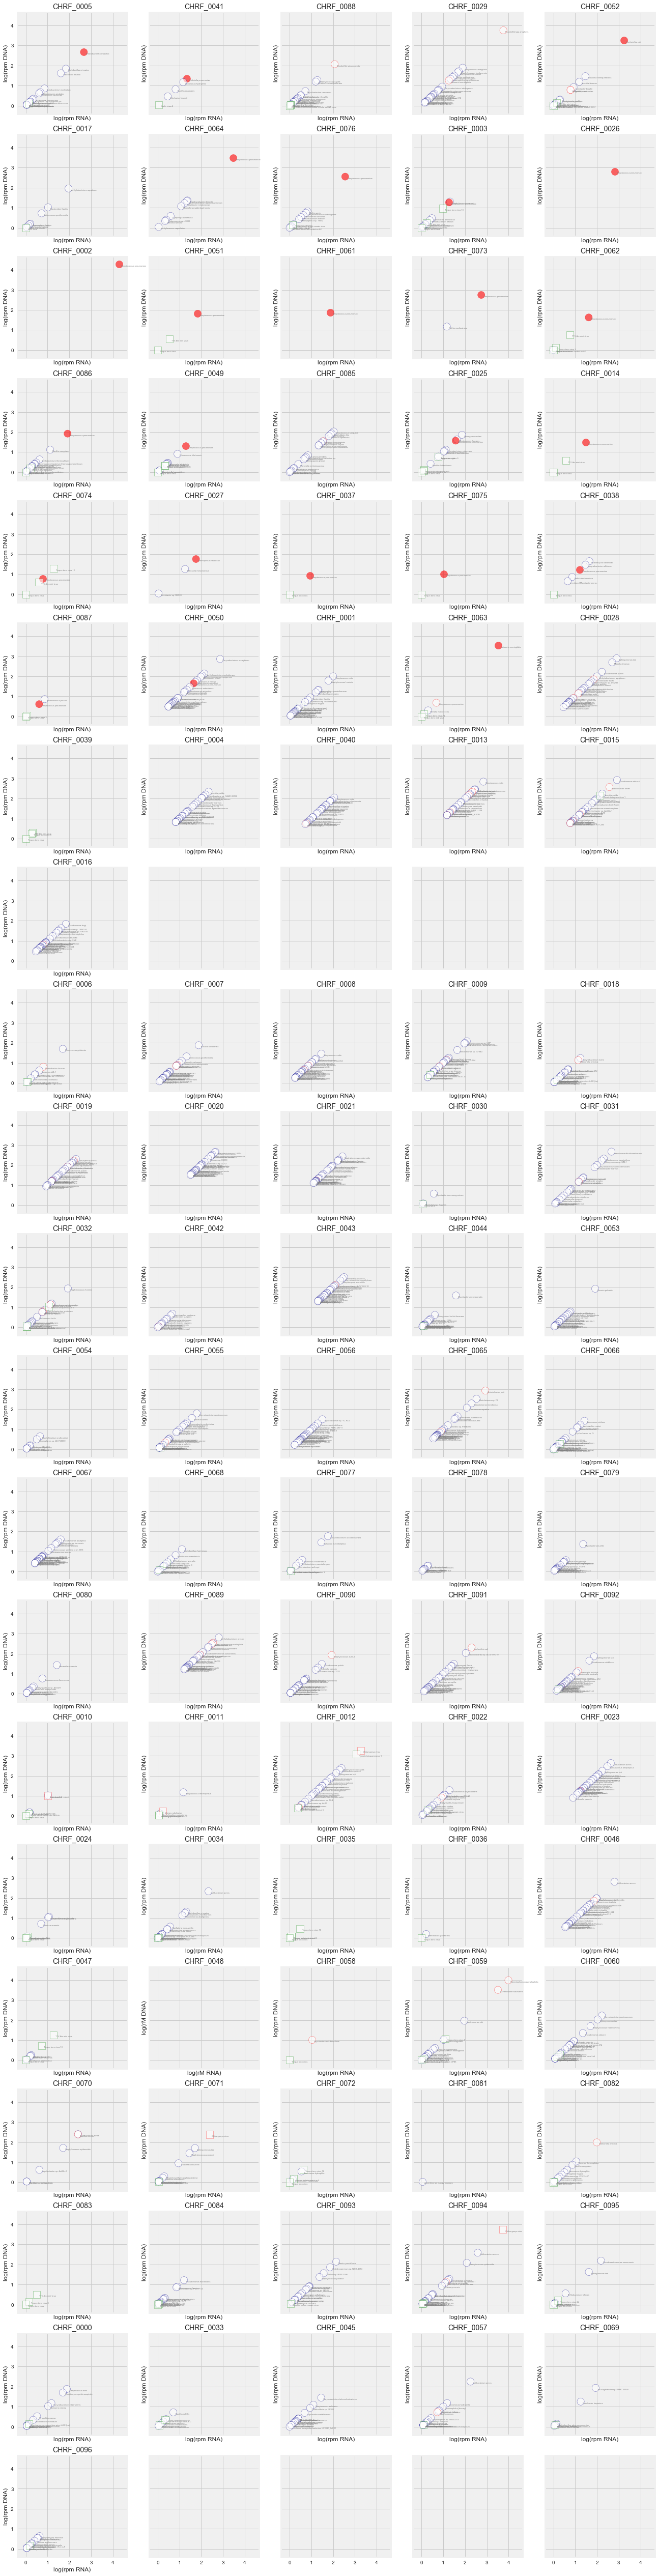

In [11]:
final_results = {}
top_microbes_file = open('./output/' + output_directory + '/top_microbes_by_patient.txt','w')

percent_represented_in_topX_RNA = []
percent_represented_in_topX_DNA = []

RNA_diversity = {}
DNA_diversity = {}

RNA_value = []
DNA_value = []
positive = []
pathogenic = []
virus = []
nrnt_model = []
groupid = []
microbe_id = []
microbe_id_genus = []
patient_id = []
ranks = []
nt_genusz_dna = []
nt_genusz_rna = []

RNA_value_test = []
DNA_value_test = []
positive_test = []
pathogenic_test = []
virus_test = []
nrnt_model_test = []
test_files = []

sensitivity_analysis_results = {}

cultured_fill = ['none',]
cultured_colors = ['blue','red']

fig, axarr = plt.subplots(21,5, figsize=(20, 92), sharex=True, sharey=True)#, facecolor='white')

row = 0
col = 0

f = open('./output/' + output_directory + '/raw_data_pathogen_scoring.txt','w')
do_not_continue = False
ranks_from_culture = {}

list_of_files = list(bacterial.keys())
prev_sample_tc = 0

for i in ordered_list_of_files:   # loop through all files
    print(i)

    sample_id = i.split('/')[-1].split('.')[0].upper()
    metadata_id = metadata.loc[metadata['sample_name_RNA'] == sample_id].index[0]   
    
    tc = true_classification.loc[[sample_id],:]['effective_group'][0]   # set group ID
    ranks_from_culture[i] = []

    if tc == 1 or tc == 4 or tc ==3 or tc ==2 or tc == 5:

        if(not do_not_continue):
            
            # this modifies the scatterplot point shape based on the group, 
            # currently setting all to circles
            group = 'o'  
            
            # in the plot of log(RNA rpM) x log(DNA rpM) we want to divide into sections based 
            # on sample adjuciation - all samples from Group 1 are grouped together, followed by 
            # all samples in G2, etc. This section creates a new line whenever the group switches.
            if tc == 1 and prev_sample_tc < tc:
                print('hi')
            if tc == 2 and prev_sample_tc < tc:
                row += 1
                col = 0
            if tc == 3 and prev_sample_tc < tc:
                row += 1
                col = 0
            if tc == 4 and prev_sample_tc < tc:
                row +=1 # 0
                col = 0

            bac = full[i] 

            if(bac.shape[0] > 0):
                bac = bac.reset_index()
                
                # sort the operating matrix by column RPM
                bac.sort_values(by='genus_NT_rpm RNA', inplace=True, ascending=False)   
                bac = bac.reset_index() #reindex([i for i in range(len(bac.index))])
                
                # Keep track of the percent of all microbial rpM that are represented in the 
                # top 15 microbes. This threshold was selected based on the fact that all 
                # culture-identified microbes were present w/in the top 15. Here we quantify
                # the total % microbial represnted by this subset.
                try:
                    percent_represented_in_topX_DNA.append(bac.head(n=topX)['genus_NT_rpm DNA']
                                                           .sum()/bac['genus_genus_NT_rpm DNA'].sum())
                except:
                    print("could not append DNA % in top 15")
                try:
                    percent_represented_in_topX_RNA.append(bac.head(n=topX)['genus_NT_rpm RNA']
                                                           .sum()/bac['genus_NT_rpm RNA'].sum())
                except:
                    print("could not append RNA % in top 15")
                
                # topX allows us to select the top N microbes (15 for the purpose of the study)
                bac = bac.head(n=topX) 
                print(bac)
                
                bac['genus_NT_rpm DNA scaled'] = (bac['genus_NT_rpm DNA']
                                                 /bac['genus_NT_rpm DNA'].sum())
                bac['genus_NT_rpm RNA scaled'] = (bac['genus_NT_rpm RNA']
                                                 /bac['genus_NT_rpm RNA'].sum())              
                bac.fillna(0)
                
                DNA_diversity[i.split('/')[4].split('.')[0]] = (1- simpson_di(dict(bac['genus_NT_rpm DNA'])))
                RNA_diversity[i.split('/')[4].split('.')[0]] = (1- simpson_di(dict(bac['genus_NT_rpm RNA'])))
                
                
                # this outputs the full topX microbes (DNA and RNA data) to .txt file .
                top_microbes_file = open('./output/' + output_directory + 
                                         '/top_microbes_by_patient.txt','a')
                top_microbes_file.write("\n----\n" + i + "\n\n")
                top_microbes_file.close()
                top_microbes_file = open('./output/' + output_directory + 
                                         '/top_microbes_by_patient.txt','a')
                bac.to_csv('./output/' + output_directory + 
                           '/top_microbes_by_patient.txt', sep='\t', mode='a')
                top_microbes_file.write("\n\n")
                top_microbes_file.close()
                
                grew_in_culture = []   # fill color
                is_pathogen = []       # edge color
                is_virus = []          # shape (square = virus, circle = bacteria/fungi)
                nrnt_pointsize = []    # NO LONGER APPLICABLE

                bac = bac.dropna(axis=0, how='all')

                rank_number_identified = 0
                for n in bac.index:
                    rank_number_identified += 1   # increment with each microbe

                    
                    # implementing a heuristic for assigning most likely 
                    # species to genus-level rpM
                    curr_genus = bac.loc[n]['name_x']    # default is DNA species...
                    species_colID = 'name_x'
                    
                    # ...but if RNA rM is greater, then set curr_genus to the RNA species
                    if bac.loc[n]['genus_NT_rpm DNA'] < bac.loc[n]['genus_NT_rpm RNA']:   
                        curr_genus = bac.loc[n]['name_y']
                        species_colID = 'name_y'

                    # TODO: Could remove this section - 
                    # no longer looking at NR:NT ratio for this paper
                    # if(with_nrnt_concordance):
                    if(True):
                        # get the genus to use as a tag for finding the concordance
                        #g = ' '.join(bac.loc[n]['genus_taxid'].split(' ')[0:-3])   
                        g = bac.loc[n]['genus_taxid'] 
                        try:
                            # try to append the NRNT point size
                            nrnt_pointsize.append(float(nrnt_values.loc[g]['prop'])) 
                            print("WEIRD...NRNT WAS FOUND: " + str(g))
                        except:   # if the NRNT value can't be found, just append zero...
                            # ...  cases in which it can't be found are when rM is extremely low
                            nrnt_pointsize.append(1)  #NO NRNT POINT SIZE

                    #
                    # set the facecolor of points based on classificaiton of microbe. Overall... 
                    # blue = non-pathogenic bacteria/fungi
                    # green = non-pathogenic virus
                    # red = pathogenic (bacteria, virus, or fungi)
                    #
                    
                    set_color = "darkblue"     # default blue
                    if (curr_genus in list_of_viruses_in_dictionary) or ('irus' in str(curr_genus)):  #if genus is any virus, green
                        set_color = "green"
                        is_virus.append("green")   
                    else:
                        is_virus.append('none')
                    # set red if pathogen, regardless of whether it was previously 
                    # set to green for "virus"; this means that viruses on list of pathogens
                    # will appear red, not green.

                    try:
                        if (curr_genus in full_respiratory_microbes_list) or (curr_genus.split(' ')[0] in full_respiratory_microbes_list):  
                            set_color = "red"
                    except:
                        if (curr_genus in full_respiratory_microbes_list):
                            set_color = "red"
                    
                    # to the vector of pathogenicity, append the color; red == pathogen
                    is_pathogen.append(set_color)  # "red") ADDED 7/6 to make all microbes "pathogens" 

                    
                    #
                    # set the fill color based on whether the microbe grew in culture
                    # colors are consistent with the outline colors when grew_in_culture is true,
                    # otherwise fill color is empty
                    # 
                    
                    #'''
                    if (tc == 1 or tc==2) and not (isinstance((metadata.loc[metadata_id]['organism']), float)): # this grew in culture
                        if bac.loc[n]['Species_Assignment'] in list(metadata.loc[metadata_id]['organism'].split(',')):      
                            ranks_from_culture[i].append(rank_number_identified)
                            grew_in_culture.append(set_color) 
                            #elif len(bac.loc[n]['Species_Assignment']) == 1 and sum([bac.loc[n]['Species_Assignment'] in i for i in list(metadata.loc[metadata_id]['organism'].split(','))]) > 0:
                            #ranks_from_culture[i].append(rank_number_identified)
                            #grew_in_culture.append(set_color) 
                        else:
                            grew_in_culture.append('white')     # this did not grow in culture
                    else:
                        #'''
                        # this was not in G1 or G2, therefore did not grow in culture 
                        grew_in_culture.append('white')    
                        
                    g = bac.loc[n]['genus_taxid']   # genus-level microbe ID
                    

                #
                # make plot of all microbes, split by individuals, weighted by nrnt concordance 
                #
        
                # this defines the plot structure - 5 columns, up to 21 rows 
                # (bc we have 100 samples)
                if row < 21 and col < 5: 
                
                    correct_species_names = []
                
                    # plot viruses a different shape
                    bac['is_pathogen'] = is_pathogen
                    bac['grew_in_culture'] = grew_in_culture
                    bac['nrnt_pointsize'] = nrnt_pointsize
                    bacv = bac[bac['category_name']=="Viruses"] 
                    baco = bac[bac['category_name']!="Viruses"] 
                    
                    
                    
                    axarr[row,col].scatter(np.log10((baco['genus_NT_rpm RNA']+1)),  
                           np.log10((baco['genus_NT_rpm DNA']+1)),
                           alpha = .6, edgecolor=baco['is_pathogen'], 
                           facecolor = baco['grew_in_culture'], 
                           marker='o', s =[max(j*200,20) for j in baco['nrnt_pointsize']]) 
                           #,linewidth='1.2' )
                    axarr[row,col].scatter(np.log10((bacv['genus_NT_rpm RNA']+1)),  
                           np.log10((bacv['genus_NT_rpm DNA']+1)),
                           alpha = .6, edgecolor=bacv['is_pathogen'], 
                           facecolor = bacv['grew_in_culture'], 
                           marker='s', s =[max(j*200,20) for j in bacv['nrnt_pointsize']]) 
                           #,linewidth='1.2' )

                    
                    '''
                    plt.scatter(np.log10((baco['genus_NT_rpm RNA']+1)),  
                           np.log10((baco['genus_NT_rpm DNA']+1)),
                           alpha = .6, edgecolor=bacv['is_pathogen'], 
                           facecolor = baco['grew_in_culture'], 
                           marker='o', s =[max(j*200,20) for j in baco['nrnt_pointsize']] )
                    plt.show()
                    '''
                    
                    
                    # loop through microbes and annotate the scatterplot with text 
                    for n in bac.index:
                        curr_genus = bac.loc[n]['name_x']    # default is DNA species...
                        species_colID = 'name_x'
                        # ... but if RNA rM is greater, then curr_genus is the rna genus
                        if bac.loc[n]['genus_NT_rpm DNA'] < bac.loc[n]['genus_NT_rpm RNA']:    
                            curr_genus = bac.loc[n]['name_y']
                            species_colID = 'name_y'
                        #'''    
                        # annotate
                        axarr[row,col].annotate(bac.loc[n][species_colID], 
                                         (np.log10((bac.loc[n]['genus_NT_rpm RNA']+1)) + .1, 
                                         np.log10((bac.loc[n]['genus_NT_rpm DNA']+1)) - .1),
                                         fontsize=4, color='grey') 
                        
                        #'''
                        correct_species_names.append(bac.loc[n][species_colID])
                    

                    # set axis parameters and labels
                    #axarr[row,col].set_title(
                    #    'TA-'+i.split('/')[5].split('.')[0].split('-')[1], fontsize=14)
                    axarr[row,col].set_title(metadata_id, fontsize=14)
                    axarr[row,col].set_xticks(np.arange(0,4.5,1))
                    axarr[row,col].set_yticks(np.arange(0,4.5,1))
                    axarr[row,col].set_xlabel('log(rpm RNA)')
                    axarr[row,col].set_ylabel('log(rpm DNA)')
                    
                    #axarr[row,col].set_facecolor('white')

                    # if you have reached the last column of subplots, 
                    # move to the next row in subplot grid
                    if col == 4:
                        row += 1
                        col = 0
                    else:
                        col += 1

                    #
                    # CALCULATE/STRUCTURE VALUES TO BE PUT INTO LOGISTIC REGRESSION:
                    #
                       
                    #for sensitivity analysis with real model 
                    RNA_value = RNA_value + list(np.log10((bac['genus_NT_rpm RNA']+1)))  
                    DNA_value = DNA_value + list(np.log10((bac['genus_NT_rpm DNA']+1)))  
                    positive = positive + grew_in_culture
                    pathogenic = pathogenic + is_pathogen
                    virus = virus + is_virus
                    nrnt_model = nrnt_model + nrnt_pointsize
                    groupid = groupid + [tc for l in range(len(nrnt_pointsize))]
                    microbe_id = microbe_id  + correct_species_names
                    microbe_id_genus = microbe_id_genus + [bac['genus_taxid'][i] for 
                                                           i in range(len(bac['genus_taxid']))]
                    patient_id = patient_id + [i.split('/')[-1] for 
                                               l in range(len(nrnt_pointsize))]
                    nt_genusz_rna = nt_genusz_rna + list(bac['NT_zscore RNA'])
                    nt_genusz_dna = nt_genusz_dna + list(bac['NT_zscore DNA'])
                    ranks = ranks + [j for j in range(len(bac.index))]
                    
                    
            # bac.shape was < 1, so no microbes identified - fill these values with zero. 
            else:  
                
                if row < 21 and col < 5:  # no real data to plot
                    
                    # just set axis parameters and labels
                    #axarr[row,col].set_title(
                    #    'TA-'+i.split('/')[5].split('.')[0].split('-')[1], fontsize=14)
                    axarr[row,col].set_title(metadata_id, fontsize=14)
                    axarr[row,col].set_xticks(np.arange(0,4.5,1)) 
                    axarr[row,col].set_yticks(np.arange(0,4.5,1)) 
                    axarr[row,col].set_xlabel('log(rM RNA)')
                    axarr[row,col].set_ylabel('log(rM DNA)')
                    #axarr[row,col].set_axis_bgcolor('white')

                    # if you have reached the last column of subplots, 
                    # move to the next row in subplot grid
                    if col == 4:
                        row += 1
                        col = 0
                    else:
                        col += 1
                        
    else:
        print("Warning: what is going on??")
    prev_sample_tc = tc

plt.savefig('./output/' + output_directory + '/FigureS1.pdf', transparent=True)   # save figure to .pdf file

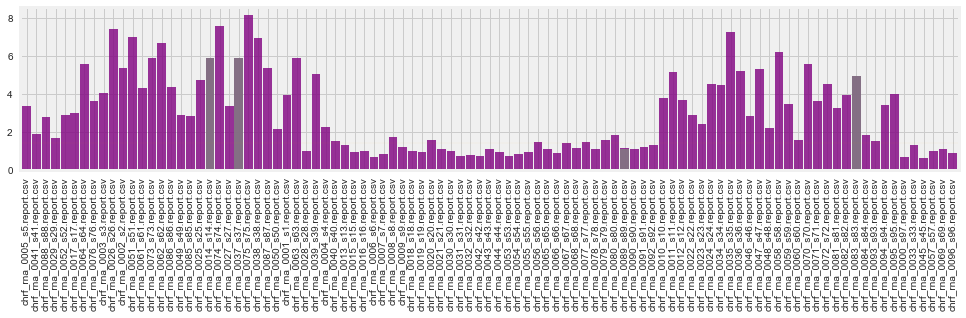

In [33]:
'''
rna_input = pd.read_csv(
    './data/' + data_directory +
    '/rna_input_070618.tsv',
    sep='\t',
    header=0,
    index_col=0)

'''
rna_input = metadata[['RNA_input', 'sample_name_RNA', 'effective_group']]
rna_input.index = list(metadata['sample_name_RNA'])
rna_input.dropna(inplace=True)

rna_input.index = [i.lower() + '.report.csv' for i in rna_input.index]
x = [i.split('/')[-1].split('.')[0]+'.report.csv' for i in list(ordered_list_of_files)]
rna_input = rna_input.loc[x]


# IMPUTE the RNA_input values for samples without reliable estimates.

rna_input_impute = rna_input.copy()
rna_input_impute['RNA_input'] = 0

unreliable_input = rna_input[rna_input['RNA_input']==0]
reliable_input = rna_input[rna_input['RNA_input']!=0]
for i in unreliable_input.index:
    eff_grp = rna_input.loc[i]['effective_group']
    imputed_input = reliable_input[reliable_input['effpiective_group'] == eff_grp]['RNA_input'].mean()
    rna_input_impute['RNA_input'][i] = imputed_input
    rna_input['RNA_input'][i] = imputed_input
    


# Plot the RNA input bargraph

plt.figure(figsize=(15,3))
log(rna_input['RNA_input']+1).plot(kind='bar',color='purple', width=.9, alpha = .8,figsize=(15,3))
log(rna_input_impute['RNA_input']+1).plot(kind='bar',color='gray', width=.9, alpha = .8,figsize=(15,3))
plt.axhline(y=1.4, linestyle=':', lw=.1, color='orange')
plt.savefig('./output/' + output_directory + '/rna_input_barplot.pdf' , bbox_inches='tight')


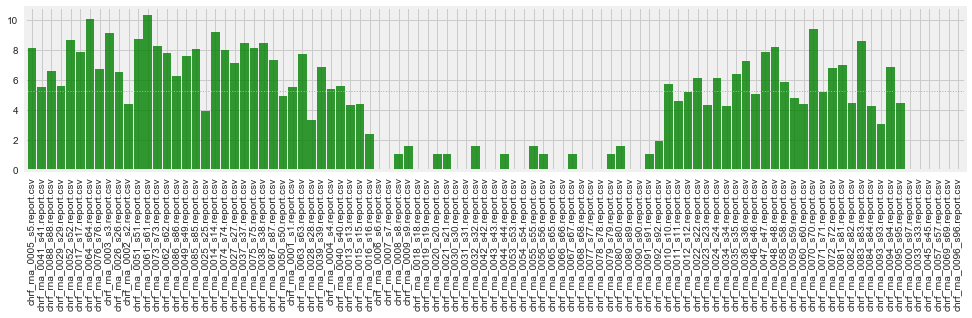

In [13]:
#print(metadata.columns)
tlc_input = metadata[['TLC (mm3)_RNA', 'sample_name_RNA', 'effective_group']]
tlc_input.index = list(metadata['sample_name_RNA'])
tlc_input.dropna(inplace=True)

tlc_input.index = [i.lower() + '.report.csv' for i in tlc_input.index]
x = [i.split('/')[-1].split('.')[0]+'.report.csv' for i in list(ordered_list_of_files)]
tlc_input = tlc_input.loc[x]


# IMPUTE the RNA_input values for samples without reliable estimates.

tlc_input_impute = tlc_input.copy()


# Plot the RNA input bargraph

plt.figure(figsize=(15,3))
log(tlc_input['TLC (mm3)_RNA']+1).plot(kind='bar',color='green', width=.9, alpha = .8,figsize=(15,3))
#log(tlc_input_impute['TLC (mm3)_RNA']+1).plot(kind='bar',color='gray', width=.9, alpha = .8,figsize=(15,3))
plt.axhline(y=log(200+1), linestyle=':', lw=1, color='orange')
plt.savefig('./output/' + output_directory + '/TLC_barplot.pdf' , bbox_inches='tight')


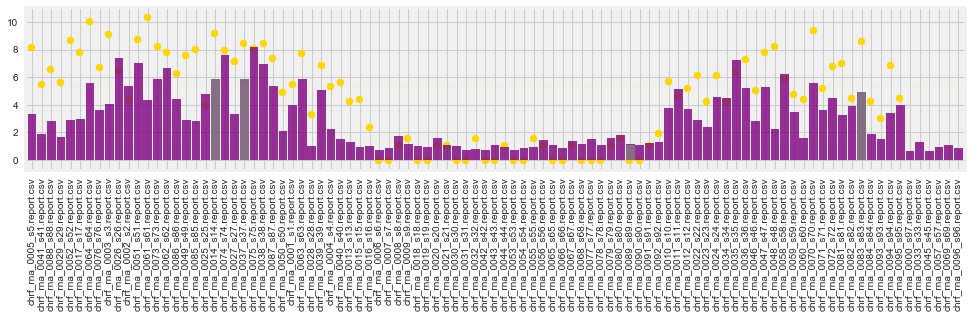

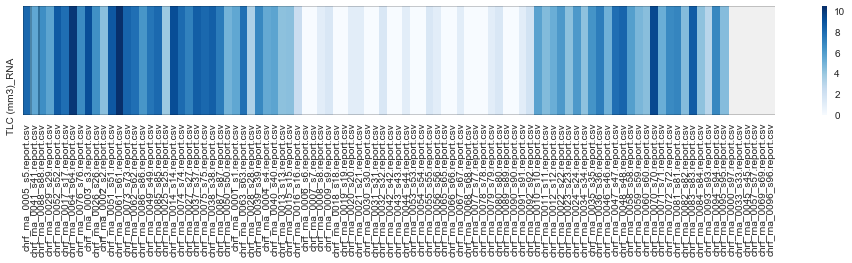

In [14]:
#log(rna_input['TLC (mm3)_RNA']+1).plot(color='green', alpha = .8,figsize=(15,3))#kind='line',color='green', width=.9, alpha = .8,figsize=(15,3))

plt.figure(figsize=(15,3))
log(rna_input['RNA_input']+1).plot(kind='bar',color='purple', width=.9, alpha = .8,figsize=(15,3))
plt.ylim=(0,12)
log(rna_input_impute['RNA_input']+1).plot(kind='bar',color='gray', width=.9, alpha = .8,figsize=(15,3))
plt.axhline(y=1.4, linestyle=':', lw=.1, color='orange')


plt.scatter([i-.1 for i in range(len(tlc_input['TLC (mm3)_RNA']))], log(tlc_input['TLC (mm3)_RNA']+1), color='gold')
plt.axhline(y=log(200+1), linestyle=':', lw=.1, color='gold')

plt.savefig('./output/' + output_directory + '/tlc_combo_barplot.pdf' , bbox_inches='tight')


plt.figure(figsize=(15,2))
ax = sns.heatmap(pd.DataFrame(log(tlc_input['TLC (mm3)_RNA']+1)).transpose(), cmap="Blues")#,cmap=cmap,vmin=0,vmax=12)#,row_colors='red')#,cbar=False)
ax.hlines([i for i in range(len(tlc_input.index))], *ax.get_xlim(),lw=.4)
ax.vlines([i for i in range(len(tlc_input.columns))], *ax.get_ylim(),lw=.4)
ax.tick_params(labelsize=10)
plt.savefig('./output/' + output_directory + '/tlc_combo_heatmap.pdf' , bbox_inches='tight')

The previous cell collected the % of total reads per million that were covered by the top N microbes, per patient on both RNA- and DNA-seq. This analysis presents statistics on the distribution of percent rpM represented.

# Set-up Data from LR and RB Models

> "For both models, microbes identified by clinician-ordered diagnostics in LRTI+C+M patients and all viruses with established respiratory pathogenicity, were considered pathogens (n=12 in derivation cohort and n=26 in validation cohort, Table S1). Any additional microbes identified by NGS were considered commensals (n = 155 in derivation cohort, n=174 in validation cohort)."

This code creates the main data structure that will be used to implement the rules-based and logistic regression models - a dataframe with one line per sample containing 
- RNAvalue
- DNAvalue
- groupID
- rank
- microbeID
- patient
- pathogenicity
- virus status
- and whether the microbe was identified in culture.

In [15]:
# Parse out the relevant features from Figure S1 - generated in main analysis above.
sensitivity_DF = pd.DataFrame.from_dict({'RNAvalue':RNA_value,
                                         'DNAvalue':DNA_value,
                                         'groupID':groupid,
                                         'positive':positive,
                                         'pathogenic':pathogenic,
                                         'nrnt':nrnt_model,
                                         'ranks':ranks,
                                         'virus':virus,
                                         'microbe':microbe_id,
                                         'microbe_genus':microbe_id_genus, 
                                         'patient':patient_id, 
                                         'nt_Z_rna':nt_genusz_rna,
                                         'nt_Z_dna':nt_genusz_dna}, orient='columns')

X = sensitivity_DF[['RNAvalue','DNAvalue','nrnt','groupID','ranks','microbe',
                    'patient','microbe_genus','nt_Z_rna','nt_Z_dna']]
X[['pathogenic_red']] = sensitivity_DF[['pathogenic']] == 'red'
X[['pathogenic_green']] = sensitivity_DF[['virus']] == 'green'
X[['pathogenic_darkblue']] = sensitivity_DF[['pathogenic']] == 'darkblue'
X['positive'] = sensitivity_DF[['positive']]!="white"#"none"

# Full training dataset
X.fillna(0,inplace=True)
Y = X[['positive']]
Y = Y['positive'].tolist()

# Separate out by group membership for training and analysis of True Positive / True Negative
X_g1 = X[X['groupID'] == 1]
print(X_g1.shape)
X_g2 = X[X['groupID'] == 2]
print(X_g2.shape)
X_g3 = X[X['groupID'] == 3]
print(X_g3.shape)
X_g4 = X[X['groupID'] == 4]
print(X_g4.shape)
X_g1g4 = pd.concat([X_g1, X_g4], axis=0)

# generate the outcome vectors based on whether microbe was identified by standard microbiology
Y_g1 = X_g1[['positive']]
Y_g1 = Y_g1['positive'].tolist()
Y_g2 = X_g2[['positive']]
Y_g2 = Y_g2['positive'].tolist()
Y_g3 = X_g3[['positive']]
Y_g3 = Y_g3['positive'].tolist()
Y_g4 = X_g4[['positive']]
Y_g4 = Y_g4['positive'].tolist()
Y_g1g4 = X_g1g4[['positive']]
Y_g1g4 = Y_g1g4['positive'].tolist()

X.to_csv('./output/' + output_directory + '/microbe_model_data.csv')  # save full dataset to .csv
X.head() # demo of training data

(422, 14)
(0, 14)
(293, 14)
(591, 14)


RNAvalue  DNAvalue  nrnt  groupID  ranks                  microbe  \
0  2.669224  2.669224     1        1      0  Enterobacter hormaechei   
1  1.842609  1.842609     1        1      1  Lactobacillus crispatus   
2  1.613842  1.613842     1        1      2     Citrobacter freundii   
3  0.857332  0.857332     1        1      3  Fusobacterium nucleatum   
4  0.672098  0.672098     1        1      4    Streptomyces anulatus   

                patient  microbe_genus  nt_Z_rna  nt_Z_dna  pathogenic_red  \
0  chrf_rna_0005_s5.csv            547      99.0      99.0            True   
1  chrf_rna_0005_s5.csv           1578      17.7      17.7           False   
2  chrf_rna_0005_s5.csv            544      99.0      99.0           False   
3  chrf_rna_0005_s5.csv            848       6.0       6.0           False   
4  chrf_rna_0005_s5.csv           1883       7.0       7.0           False   

   pathogenic_green  pathogenic_darkblue  positive  
0             False                False      True  
1             False                 True     False  
2             False                 True     False  
3             False                 True     False  
4             False                 True     False

In [16]:
# separate G1/G4 data further into training and test sets 
# these sample names were identified by random selection of host RNA-seq data based on RNA-seq batches.
X_g1_train = X_g1[X_g1['patient'].isin(training_sample_names)]
X_g4_train = X_g4[X_g4['patient'].isin(training_sample_names)]
X_g1g4_train = pd.concat([X_g1_train,X_g4_train])
Y_g1_train = X_g1_train['positive'].tolist()
Y_g4_train = X_g4_train['positive'].tolist()

X_g1_test = X_g1[~X_g1['patient'].isin(training_sample_names)]
X_g4_test = X_g4[~X_g4['patient'].isin(training_sample_names)]
X_g1g4_test = pd.concat([X_g1_test,X_g4_test])
Y_g1_test = X_g1_test['positive'].tolist()
Y_g4_test = X_g4_test['positive'].tolist()

print("Training data contains: " + str(X_g1g4_train.shape[0]) + 
      " total microbes from 20 patients (in the LRTI+C/+M and LRTI-NEG training set), of which " + 
      str(X_g1g4_train[X_g1g4_train['positive']==True].shape[0]) + 
      " microbes are considered POSITIVE (grew in culture).")
print("The test data contains: " + str(X_g1g4_test.shape[0]) + 
      " total microbes from all remaining patients in the validation cohort, of which " + 
      str(X_g1g4_test[X_g1g4_test['positive']==True].shape[0]) + 
      " microbes are considered POSITIVE (grew in culture).")

Training data contains: 0 total microbes from 20 patients (in the LRTI+C/+M and LRTI-NEG training set), of which 0 microbes are considered POSITIVE (grew in culture).
The test data contains: 1013 total microbes from all remaining patients in the validation cohort, of which 24 microbes are considered POSITIVE (grew in culture).


## Execute Rules-Based Model (RBM) for distinguishing between 'pathogens' and 'commensals'

> "In the RBM, respiratory microbes from each patient were assigned an abundance score based on the sum of log(RNA-Seq) and log(DNA-Seq) genus reads per million (rpm) (Table S3). Microbes were then ranked by this score, and the largest differential between sequentially ranked taxa was used as a threshold to isolate the group of highest-scoring microbes within each patient (Fig2A, Fig S1). These high scoring microbes plus all RNA viruses detected at > 0.1 rpm were captured as putative pathogens by the RBM if present in an a. priori developed index of established lower respiratory pathogens derived from landmark surveillance studies and clinical guidelines (Table S2B)"

Plot the RNA x DNA projection for all microbes - those identified by the RBM are filled, those identified by standard clinical microbiology are red.

In [17]:


def get_split(list_of_values):  #returns the index
    splits = {}
    max_split = 0
    max_split_id = 0
    split_list = []
    for i in range(len(list_of_values)):
        if i == 0:
            splits[i] = 0
            split_list.append(0)
        else:
            splits[i] = -1 * (list_of_values[i] - list_of_values[i-1] )
            split_list.append(splits[i])

        if splits[i] > max_split:
            max_split = splits[i]
            max_split_id = i

    return max_split_id
def apply_rule_based_method_cluster(input_data, input_res, groupID, output_filename, title=None, annotate_plots=False,rbm_method_plot=False):

    rbm1_patient = []
    rbm1_genus = []
    rbm1_microbe = []

    s = int(np.round(len(set(input_data['patient']))/5)+1)

    if rbm_method_plot:
        fig, axarr = plt.subplots(s,5, figsize=(20, s*4), sharex=True, sharey=True)
        row = 0
        col = 0

    for i in list(set(input_data['patient'])):#[0:3]:
        new_adds = 0
        #print(i)

        sub = input_data[input_data['patient']==i]
        sub['rna+dna'] = sub['RNAvalue'] + sub['DNAvalue']
        sub.sort_values(by='rna+dna', ascending=False, inplace=True)

        #ADD POTENTIAL BACTERIAL MICROBES
        subB = sub[sub['pathogenic_green'] == False] #cannot be a virus

        size_of_top_clust = get_split(list(subB['rna+dna']))
        # this was added on 12/28 to deal with cases in which only 1 bacterial microbe is present
        if(size_of_top_clust < 1):
            size_of_top_clust = 1 # there should always be at least 1 microbe in top cluster (if only 1 microbe present)


        ## NEW PLOTTING FUNCTION 2/1
        #plt.figure(figsize=[3,3])
        if rbm_method_plot:
            axarr[row,col].scatter([i for i in range(len(subB['rna+dna']))],subB['rna+dna'],color=[['darkblue','red'][int(i)] for i in subB['pathogenic_red']])
            axarr[row,col].axvline(x=size_of_top_clust - .5, color='r', linestyle='-',lw=.4)
            axarr[row,col].set_title(i)
            axarr[row,col].set_xlim(-1,15)
            axarr[row,col].set_ylim(-1,12)
            axarr[row,col].set_xticks(np.arange(0,15,1)) #MODS 2/1
            axarr[row,col].set_yticks(np.arange(0,12,1)) #MODS 2/1
            for l in range(len(subB.index)):
                axarr[row,col].annotate(subB.iloc[l]['microbe'],(l + .1,subB.iloc[l]['rna+dna']-.1),
                                 fontsize=8, color='grey')
            if col == 4:
                row += 1
                col = 0
            else:
                col += 1


        #print(size_of_top_clust)
        top = subB.head(n=size_of_top_clust)
        top = top[top['pathogenic_red'] == True]
        #print(top)
        for j in range(len(top.index)):
            rbm1_genus.append(str(top['microbe_genus'].iloc[j]))
            rbm1_microbe.append(str(top['microbe'].iloc[j]))
            new_adds += 1

        possible_viruses = sub[[(sub.loc[j]['pathogenic_green'] == True and sub.loc[j]['pathogenic_red'] == True) for j in sub.index]]
        possible_viruses = possible_viruses[possible_viruses['RNAvalue'] > np.log10(.1 + 1)] # RNAvalue is log10(RNA rpm + 1), and we want to keep viruses with rpm > .1
        if(len(possible_viruses.index) > 0):
            res = possible_viruses.head(n=1)
            for j in range(len(res.index)):
                rbm1_genus.append(str(res['microbe_genus'].iloc[j]))
                rbm1_microbe.append(str(res['microbe'].iloc[j]))
                new_adds += 1

        rbm1_patient = rbm1_patient + [i for n in range(new_adds)]

    rbm_g1 = pd.DataFrame.from_dict({'microbe': rbm1_microbe,'patient':rbm1_patient,'microbe_genus':rbm1_genus})
    rbm_g1.drop_duplicates(inplace=True)

    if groupID == 2:
        c = ['blue','blue']
    else:
        c = ['blue','red']

    if rbm_method_plot:
        plt.savefig(output_filename+"_methodplot.pdf")
        plt.show()

    #print([c[int(i)] for i in input_res])

    plt.figure(figsize=[8,8])
    a = [rbm_g1.iloc[i]['microbe'] + "-" + str(rbm_g1.iloc[i]['patient']) for i in range(len(rbm_g1))]
    match = [(str(input_data.iloc[i]['microbe']) + "-" + input_data.iloc[i]['patient'] in a) for i in range(len(input_data.index))]
    plt.scatter(input_data['RNAvalue'],input_data['DNAvalue'],
               edgecolor=[c[int(input_data.loc[i]['positive'])]
                       if input_data[input_data['patient'] == input_data.loc[i]['patient']]['positive'].sum() < 2
                       or c[int(input_data.loc[i]['positive'])] == 'blue'
                       or input_data.loc[i]['RNAvalue'] == max(input_data[(input_data.patient == input_data.loc[i]['patient']) & (input_data.positive == True)]['RNAvalue'])
                       else 'orange' for i in input_data.index],
                s=[85 if match[i] == 1 else 50 for i in range(len(match)) ],#linewidth='1.2',
                facecolor = [c[input_res[i]] if match[i] == 1 else 'white' for i in range(len(match)) ], alpha=.7)
                #facecolor=[c[int(Y_g2[i])] if predicted[:,1][i] > probability_threshold else 'white' for i in range(len(Y_g2)) ],alpha=.6) #s=predicted[:,1]*200
    
    if(annotate_plots):
        for i in range(len(input_res)):
            #if(predicted[:,1][i] > probability_threshold):
            if input_res[i] or match[i] == 1: #if the microbe was True in input_res
                try:
                    sp = input_data.iloc[i]['microbe'].split(' ')
                except:
                    sp = 'NA'
                pa = input_data.iloc[i]['patient'].split('-')[1]
                plt.annotate(sp[0][0] + '. ' + sp[1] + ' - ' + pa,(input_data.iloc[i]['RNAvalue'] + .1,input_data.iloc[i]['DNAvalue']-.1),
                             fontsize=5, color='grey')

    #plt.xlim((-.2, 5.5))
    #plt.ylim((-.2, 5.5))
    if not title == None:
        plt.title(title)
    else:
        plt.title("Group " + str(groupID) + " - Rule Based Method")
    #plt.axis((-1,12,-1,12))
    plt.xlabel('log( RNA rpM )' )
    plt.ylabel('log( DNA rpM )' )
    plt.savefig(output_filename + ".pdf")

    return rbm_g1

Group 1 RBM Results:


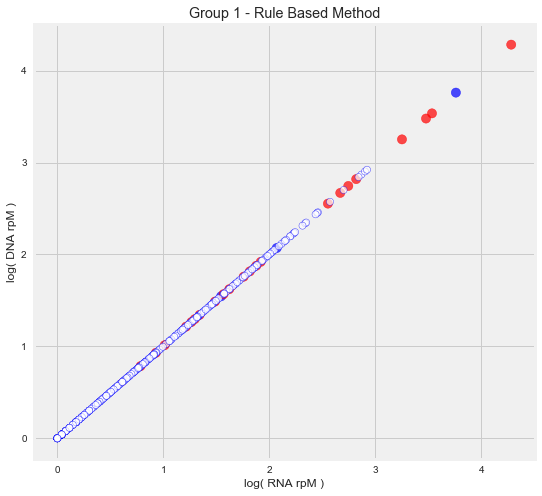

Group 2 RBM Results:


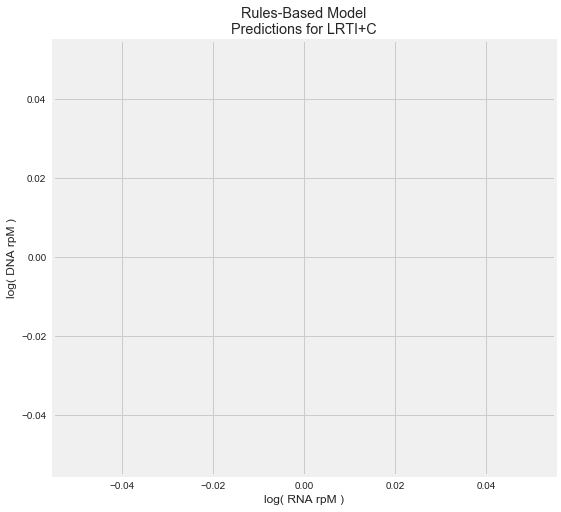

Group 3 RBM Results:


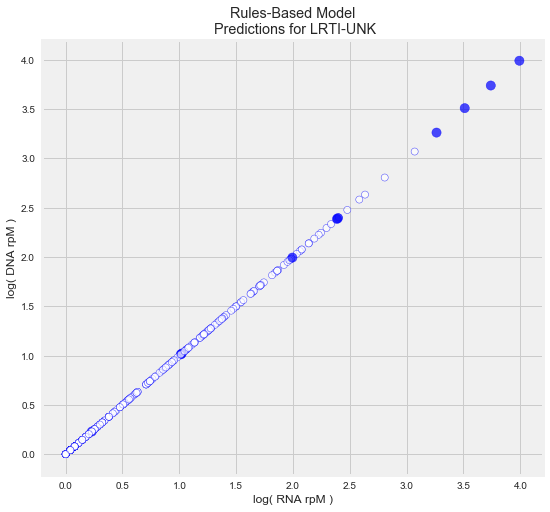

Group 4 RBM Results:


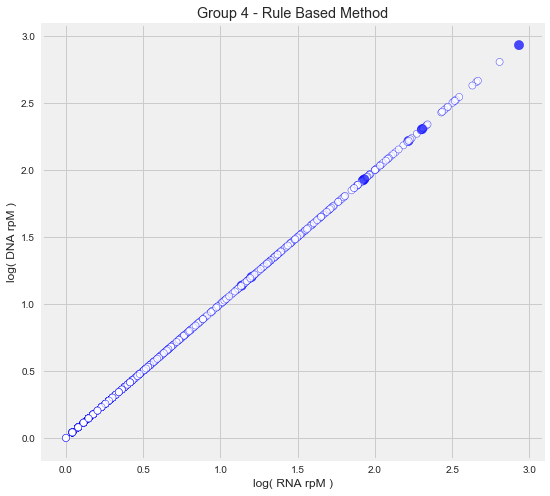

'\n# Evaluate RBM sensitivity against culture results\n# NOTE: this sensitivity calculation is at the per-patient level (as opposed to per-microbe); \n# OUTDATED.\nprint("Group 1 RBM Results:")\nplotting_functions.evaluate_sensitivity(rbm_g1,list_of_files, metadata, \n    true_classification, full, output_directory)\nprint("Group 2 RBM Results:")\nplotting_functions.evaluate_sensitivity(rbm_g2,list_of_files, metadata, \n    true_classification, full, output_directory)\nprint("Group 3 RBM Results:")\nplotting_functions.evaluate_sensitivity(rbm_g3,list_of_files, metadata, \n    true_classification, full, output_directory)\nprint("Group 4 RBM Results:")\nplotting_functions.evaluate_sensitivity(rbm_g4,list_of_files, metadata, \n    true_classification, full, output_directory)\n'

In [18]:
annotate_plots = False # do not want to write microbe names on the plots

# run RBM on Group 1 and Group 4 to generate the combined prediction Figure 2A
# We don't care about training and test sets in the RBM because each sample is 
# processed entirely independently

print("Group 1 RBM Results:") # Group 1 Only
rbm_g1 = apply_rule_based_method_cluster(X_g1, 
                                                            Y_g1, 
                                                            1, 
                                                            './output/' + output_directory +
                                                            '/rbm_1', 
                                                            rbm_method_plot=False)
rbm_g1.to_csv('./output/' + output_directory + '/RBM_G1.csv')
plt.show()

print("Group 2 RBM Results:") # Group 2 Only
rbm_g2 = apply_rule_based_method_cluster(
    X_g2, 
    Y_g2,
    2,
    './output/' + output_directory + '/FigureS3A',
    title="Rules-Based Model\n Predictions for LRTI+C ",
    rbm_method_plot=False)
rbm_g2.to_csv('./output/' + output_directory + '/RBM_G2.csv')
plt.show()

print("Group 3 RBM Results:") # Group 3 Only
rbm_g3 = apply_rule_based_method_cluster(
    X_g3,                                                         
    Y_g3, 
    3, 
    './output/' + output_directory + '/FigureS3C', 
    title="Rules-Based Model\n Predictions for LRTI-UNK", 
    rbm_method_plot=False)
rbm_g3.to_csv('./output/' + output_directory + '/RBM_G3.csv')
plt.show()

print("Group 4 RBM Results:") # Group 4 Only
rbm_g4 = apply_rule_based_method_cluster(
    X_g4, 
    Y_g4, 
    4, 
    './output/' + output_directory + '/rbm_4', 
    rbm_method_plot=False)
rbm_g4.to_csv('./output/' + output_directory + '/RBM_G4.csv')
plt.show()

# rbm_g1 - rbm_g4 results are saved and appended to output TableS3.

'''
# Evaluate RBM sensitivity against culture results
# NOTE: this sensitivity calculation is at the per-patient level (as opposed to per-microbe); 
# OUTDATED.
print("Group 1 RBM Results:")
plotting_functions.evaluate_sensitivity(rbm_g1,list_of_files, metadata, 
    true_classification, full, output_directory)
print("Group 2 RBM Results:")
plotting_functions.evaluate_sensitivity(rbm_g2,list_of_files, metadata, 
    true_classification, full, output_directory)
print("Group 3 RBM Results:")
plotting_functions.evaluate_sensitivity(rbm_g3,list_of_files, metadata, 
    true_classification, full, output_directory)
print("Group 4 RBM Results:")
plotting_functions.evaluate_sensitivity(rbm_g4,list_of_files, metadata, 
    true_classification, full, output_directory)
'''

# Train and Evaluate Logistic Regression Model (LRM) 

First, for distinguishing between 'pathogens' and 'commensals'; then, for separating LRTI+C+M and no-LRTI patients.

> "We thus employed machine learning to distinguish respiratory pathogens from commensals using a logistic regression model (LRM) trained on microbes detected in derivation cohort patients using the predictor variables of: RNA-Seq rpm, DNA-Seq rpm, rank by RNA-Seq rpm, established LRTI pathogen (yes/no), and virus (yes/no). These features were selected to preferentially favor highly abundant organisms with established pathogenicity in the lung, but still permit detection of uncommon taxa that could represent putative pathogens. "

# Training v. Test Set - LR Analysis 

## Assess Model Stability:
Run LR model for 1000 rounds of cross-validation within the Derivation Cohort, further splitting the data intoa training set = 70% and test set = 30% at each iteration.

> "To evaluate LRM performance, we first performed 1000 rounds of cross-validation in which we randomly sub-divided the derivation cohort into training (70%) and test (30%) sets during each round, which yielded an average AUC of 0.93 +/- 0.08 standard deviations."

### Pathogen v. Commensal LRM model applied to Test Set and LRTI+C and unk-LRTI patient groups

> "We found that both the RBM and the LRM identified previously occult putative pathogens in patients with clinically adjudicated LRTI but negative microbiologic testing (LRTI+C), as well as new potential co-infecting pathogens in the LRTI+C+M subjects (Figs 3, S2, Table S3). Putative new pathogens were identified in 21 (62%) of LRTI+C subjects using the RBM, and 21 (62%) via the LRM (Fig S2, Table S3). Both methods enabled a microbiologic diagnosis in a greater number of LRTI-positive subjects compared to clinician-ordered diagnostics (78% vs 43% for both RBM  and LRM (p < 1.00 x10-4 by McNemar's test, respectively) (Fig 3)."

How to interpret the following plots:
- IF THE EDGE IS RED, it was identified in culture (and should be filled in, true positive)
- IF a red edge is not filled in, then it is a false negative.
- IF an edge is blue, then it was not identified in culture (and should not be filled in, true negative)
- IF a blue circle is filled in then it is a false positive.

'\n\n# unk-LRTI PREDICTIONS\npredicted = lr.predict_proba(X_g3[training_variables]) \nplt.figure(figsize=[8,8])\nplt.scatter(X_g3[\'RNAvalue\'],X_g3[\'DNAvalue\'],\n            edgecolor=[c[int(i)] for i in Y_g3],\n            s=[max(i*200,20) for i in predicted[:,1]],\n            #linewidth=\'1.2\',\n            facecolor=[c[int(Y_g3[i])] if predicted[:,1][i] > \n                       PROBABILITY_THRESHOLD else \'none\' for i in range(len(Y_g3)) ],\n            alpha=.6)\nxlim((-.2, 4.5))\nylim((-.2, 4.5))\nif(annotate_plots):\n    for i in range(len(Y_g3)):\n        if True:\n            try:\n                sp = X_g3.iloc[i][\'microbe\'].split(\' \')\n            except: \n                sp = \'NA\'\n            pa = X_g3.iloc[i][\'patient\'].split(\'-\')[1]\n            plt.annotate(sp[0][0] + \'. \' + sp[1] + \' - \' + pa,\n                         (X_g3.iloc[i][\'RNAvalue\'] + .1,\n                          X_g3.iloc[i][\'DNAvalue\']-.1), \n                         fontsize=7

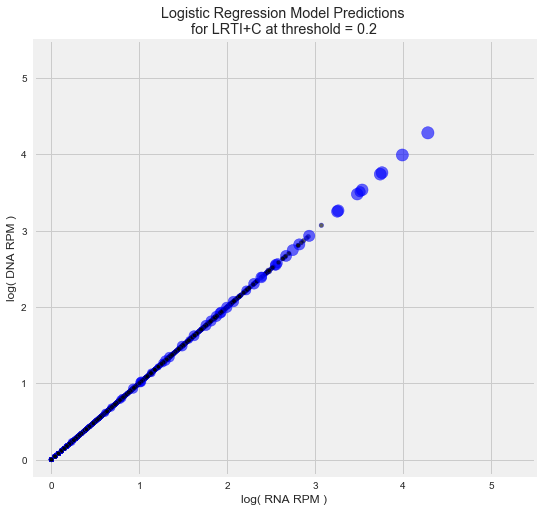

In [19]:
# PLOT THE WEIGHTED PROJECTION OF EACH GROUP'S MICROBES 
# (WEIGHTED by THE PROBABILITY OUTPUT BY LINEAR MODEL)

'''

# create fresh linear model; large C to run non-regularized regression
lr = linear_model.LogisticRegression(C=1000000)
training_variables = ['RNAvalue','DNAvalue','pathogenic_red','pathogenic_green','ranks']

# Train on all Group 1 and Group 4 patients
lr = lr.fit(X_combo[training_variables],Y_combo)

print("LRM Model Coefficients for final pathogen v. commensal trained model:")
print(training_variables)
print(lr.coef_)

# save the combined model to a pickle file 
pickle.dump(lr, open('./output/' + output_directory + '/mBAL_g1g4combo_logRegModel', 'wb'))  

'''

#lr = pickle.load( open( "/Users/kkalantar/Documents/Research/MBAL/miniBAL_study/output/042618/mBAL_g1g4combo_logRegModel", "rb" ) )
lr = pickle.load( open( "/Users/kkalantar/Documents/Research/MBAL/miniBAL_study/output/072018_Model_RNA_rank_ispatho/mBAL_g1g4combo_logRegModel", "rb" ) )
training_variables = ['RNAvalue','pathogenic_red','ranks'] #'DNAvalue','pathogenic_green',
PROBABILITY_THRESHOLD = .2 #7 #.36 #.2

#
# TRAIN ON ALL TEST SAMPLES FOR BOTH PATHOGEN V. COMMENSAL MODEL AND PATIENT MICROBE MODEL
#

c = ['blue','red'] # for G1 and G4 projection plot 
                   # (where some microbes were identified by clinical microbiology)
c2 = ['blue','red'] # for G2 and G3 projection pplots



annotate_plots = False 
c = ['blue','blue']

# Plot predicted probabilities for group 2 patients' microbes
predicted = lr.predict_proba(X[training_variables])
plt.figure(figsize=[8,8])
plt.scatter(X['RNAvalue'],X['DNAvalue'],
            edgecolor=[c[int(i)] for i in Y],
            s=[max(i*200,20) for i in predicted[:,1]],
            #linewidth='1.2',
            facecolor=[c[int(Y[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'none' for i in range(len(Y)) ],
            alpha=.6) 

xlim((-.2, 5.5))
ylim((-.2, 5.5))
if(annotate_plots):
    for i in range(len(Y)):
        if(predicted[:,1][i] > PROBABILITY_THRESHOLD):
            sp = X.iloc[i]['microbe'].split(' ')
            plt.annotate(sp[0][0] + '. ' + sp[1],
                         (X.iloc[i]['RNAvalue'] + .1,X.iloc[i]['DNAvalue']-.1), 
                         fontsize=7, 
                         color='grey')     
plt.title("Logistic Regression Model Predictions \nfor LRTI+C at threshold = " + 
          str(PROBABILITY_THRESHOLD))
plt.xlabel('log( RNA RPM )')
plt.ylabel('log( DNA RPM )')
plt.savefig('./output/' + output_directory + '/FigureS3B.pdf')
patient_by_microbe_predicted_g2 = pd.DataFrame.from_dict({
    'microbe':[X.iloc[i]['microbe'] for i in range(len(Y))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD ],
    'patient':[X.iloc[i]['patient'] for i in range(len(Y))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD],
    'microbe_genus':[X.iloc[i]['microbe_genus'] for i in range(len(Y)) if 
                     predicted[:,1][i] > PROBABILITY_THRESHOLD ]})

# append the group 2 pathogen v. commensal model to the original data matrix
X['score'] = predicted[:,1]


'''
# establish the test set
X_g1g4_test = pd.concat([X_g1_test,X_g4_test])
Y_g1g4_test = list(X_g1g4_test['positive'])

print("\n # of Pathogens v. Commensals in Training and Test sets, respectively:")
print(Counter(Y_combo['positive']))
print(Counter(Y_g1g4_test))

# Plot predicted probabilities for group 1 TEST SET patients' microbes
predicted = lr.predict_proba(X_g1g4_test[training_variables])
X_g1g4_test['score'] = predicted[:,1]  # append the predicted probabilities to the data matrix

# PLOT: RNA v. DNA plot with microbes shown with probabilities.
plt.figure(figsize=[8,8])

# visualize the test set in RNA rM by DNA rM space;
plt.scatter(X_g1g4_test['RNAvalue'],
            X_g1g4_test['DNAvalue'],
            edgecolor=[c[int(X_g1g4_test.loc[i]['positive'])] 
                       if X_g1g4_test[X_g1g4_test['patient'] == 
                                      X_g1g4_test.loc[i]['patient']]['positive'].sum() < 2 
                       or c[int(X_g1g4_test.loc[i]['positive'])] == 'blue' 
                       or X_g1g4_test.loc[i]['score'] == max(
                           X_g1g4_test[(X_g1g4_test.patient == X_g1g4_test.loc[i]['patient']) 
                                       & (X_g1g4_test.positive == True)]['score']) 
                       else 'orange' for i in X_g1g4_test.index],
            s=[max(i*600,3) for i in X_g1g4_test['score']],
            linewidth='1.2',
            facecolor=[c[int(Y_g1g4_test[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'none' for i in range(len(Y_g1g4_test)) ],
            alpha=.7) 

# add the scatterplot of predicted TRAINING microbes in RNA rM by DNA rM space;
plt.scatter(X_combo['RNAvalue'],
            X_combo['DNAvalue'],
            edgecolor=[c[int(X_combo.loc[i]['positive'])] 
                       if X_combo[X_combo['patient'] == 
                                  X_combo.loc[i]['patient']]['positive'].sum() < 2 
                       or c[int(X_combo.loc[i]['positive'])] == 'blue' 
                       or X_combo.loc[i]['score'] == max(
                           X_combo[(X_combo.patient == X_combo.loc[i]['patient'])
                                   & (X_combo.positive == True)]['score']) 
                       else 'orange' for i in X_combo.index],
            s=[max(i*600,3) for i in X_combo['score']],
            linewidth='1.2',
            facecolor=[c2[int(X_combo.iloc[i]['positive'])] if X_combo.iloc[i]['score'] > 
                       PROBABILITY_THRESHOLD else 'none' for i in range(len(X_combo['positive'])) ],
            alpha=.4)

xlim((-.2, 4.5))
ylim((-.2, 4.5))
plt.title(
    "Logistic Regression Model Predictions \nfor LRTI+C/M and LRTI-NEG at probability score threshold = " + 
    str(PROBABILITY_THRESHOLD))
plt.xlabel("log( RNA rpM )")
plt.ylabel("log( DNA rpM )")
plt.savefig('./output/' + output_directory + '/Figure2D.pdf')

if(annotate_plots):
    for i in range(len(Y_g1g4_test)):
        if(predicted[:,1][i] > PROBABILITY_THRESHOLD):
            sp = X_g1g4_test.iloc[i]['microbe'].split(' ')
            plt.annotate(sp[0][0] + '. ' + sp[1],
                         (X_g1g4_test.iloc[i]['RNAvalue'] +
                          .1,X_g1g4_test.iloc[i]['DNAvalue']-.1), 
                         fontsize=7, color='grey')     
    
plt.show()


# save the predicted probabilities for each microbe to write to file downstream
patient_by_microbe_predicted_g1g4_test = pd.DataFrame.from_dict({
    'microbe': [X_g1g4_test.iloc[i]['microbe'] for i in range(len(Y_g1g4_test))
         if predicted[:,1][i] > PROBABILITY_THRESHOLD ],
    'patient':[X_g1g4_test.iloc[i]['patient'] for i in range(len(Y_g1g4_test))
               if predicted[:,1][i] > PROBABILITY_THRESHOLD],
    'microbe_genus':[X_g1g4_test.iloc[i]['microbe_genus'] for
                     i in range(len(Y_g1g4_test))if predicted[:,1][i] > 
                                   PROBABILITY_THRESHOLD ]})

print("\n\n")
'''

#
# Predictions for Group 2 (LRTI+C) and Group 3 (unk-LRTI) patients
#

# LRTI+C PREDICTIONS

'''
annotate_plots = False 
c = ['blue','blue']

# Plot predicted probabilities for group 2 patients' microbes
predicted = lr.predict_proba(X_g2[training_variables])
plt.figure(figsize=[8,8])
plt.scatter(X_g2['RNAvalue'],X_g2['DNAvalue'],
            edgecolor=[c[int(i)] for i in Y_g2],
            s=[max(i*200,20) for i in predicted[:,1]],
            #linewidth='1.2',
            facecolor=[c[int(Y_g2[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'none' for i in range(len(Y_g2)) ],
            alpha=.6) 

xlim((-.2, 5.5))
ylim((-.2, 5.5))
if(annotate_plots):
    for i in range(len(Y_g2)):
        if(predicted[:,1][i] > PROBABILITY_THRESHOLD):
            sp = X_g2.iloc[i]['microbe'].split(' ')
            plt.annotate(sp[0][0] + '. ' + sp[1],
                         (X_g2.iloc[i]['RNAvalue'] + .1,X_g2.iloc[i]['DNAvalue']-.1), 
                         fontsize=7, 
                         color='grey')     
plt.title("Logistic Regression Model Predictions \nfor LRTI+C at threshold = " + 
          str(PROBABILITY_THRESHOLD))
plt.xlabel('log( RNA RPM )')
plt.ylabel('log( DNA RPM )')
plt.savefig('./output/' + output_directory + '/FigureS3B.pdf')
patient_by_microbe_predicted_g2 = pd.DataFrame.from_dict({
    'microbe':[X_g2.iloc[i]['microbe'] for i in range(len(Y_g2))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD ],
    'patient':[X_g2.iloc[i]['patient'] for i in range(len(Y_g2))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD],
    'microbe_genus':[X_g2.iloc[i]['microbe_genus'] for i in range(len(Y_g2)) if 
                     predicted[:,1][i] > PROBABILITY_THRESHOLD ]})

# append the group 2 pathogen v. commensal model to the original data matrix
X_g2['score'] = predicted[:,1]
'''


'''

# unk-LRTI PREDICTIONS
predicted = lr.predict_proba(X_g3[training_variables]) 
plt.figure(figsize=[8,8])
plt.scatter(X_g3['RNAvalue'],X_g3['DNAvalue'],
            edgecolor=[c[int(i)] for i in Y_g3],
            s=[max(i*200,20) for i in predicted[:,1]],
            #linewidth='1.2',
            facecolor=[c[int(Y_g3[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'none' for i in range(len(Y_g3)) ],
            alpha=.6)
xlim((-.2, 4.5))
ylim((-.2, 4.5))
if(annotate_plots):
    for i in range(len(Y_g3)):
        if True:
            try:
                sp = X_g3.iloc[i]['microbe'].split(' ')
            except: 
                sp = 'NA'
            pa = X_g3.iloc[i]['patient'].split('-')[1]
            plt.annotate(sp[0][0] + '. ' + sp[1] + ' - ' + pa,
                         (X_g3.iloc[i]['RNAvalue'] + .1,
                          X_g3.iloc[i]['DNAvalue']-.1), 
                         fontsize=7, 
                         color='grey')  
plt.title("Logistic Regression Model Predictions \nfor LRTI-UNK at threshold = " + 
          str(PROBABILITY_THRESHOLD))
plt.xlabel('log( RNA RPM )')
plt.ylabel('log( DNA RPM )')
plt.savefig('./output/' + output_directory + '/FigureS3D.pdf')
patient_by_microbe_predicted_g3 = pd.DataFrame.from_dict({
    'microbe':[X_g3.iloc[i]['microbe'] for i in range(len(Y_g3))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD ],
    'patient':[X_g3.iloc[i]['patient'] for i in range(len(Y_g3))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD],
    'microbe_genus':[X_g3.iloc[i]['microbe_genus'] for i in range(len(Y_g3)) if 
                     predicted[:,1][i] > PROBABILITY_THRESHOLD ]})
X_g3['score'] = predicted[:,1]

'''




In [20]:
#print(lr.coef_)
print(dict(zip(['RNAvalue','pathogenic_red','ranks'],lr.coef_[0]))) #'DNAvalue','pathogenic_green',

{'RNAvalue': 0.39684791245504575, 'pathogenic_red': 3.320453453284086, 'ranks': -0.6342353000867571}


In [21]:
X_withscores = X #X_g2 #pd.concat([X_g1g4_train,X_g1g4_test,X_g2,X_g3])

# add the clinical values    
X_withscores['Clin+'] = ['Y' if i else 'N' for i in list(X_withscores['positive'])]

# add one to ranks to make them more standard notation
X_withscores['ranks'] = X_withscores['ranks'] + 1

# append LRM predictions 
X_withscores['LRM+'] = ['Y' if i > PROBABILITY_THRESHOLD else 'N' for 
                        i in list(X_withscores['score'])]


# append the RBM predictions
all_RBM = pd.concat([rbm_g1,rbm_g2,rbm_g3,rbm_g4])
rbm_pos = []
for i in X_withscores.index:
    p = X_withscores.loc[i]['patient']
    m = X_withscores.loc[i]['microbe']#_genus']
    a = list(all_RBM[all_RBM['patient']==p]['microbe'])#_genus'])
    if m in a:
        rbm_pos.append('Y')
    else:
        rbm_pos.append('N')
X_withscores['RBM+'] = rbm_pos    

X_withscores['Study ID'] = [i.split('-')[0] for i in list(X_withscores['patient'])]
X_withscores['keep'] = [list(X_withscores.loc[i][['Clin+','LRM+','RBM+']]).count('Y') > 0 for 
                        i in X_withscores.index]

lrti_cat_dict = {1:'LRTI+C/+M', 2:'LRTI+C',3:'unk-LRTI',4:'no-LRTI',5:'water'}
X_withscores['LRTI Category'] = [lrti_cat_dict[i] for i in list(X_withscores['groupID'])]        
X_withscores.sort_values(by='Study ID',inplace=True)
X_withscores.head(n=10)

RNAvalue  DNAvalue  nrnt  groupID  ranks  \
1310  0.518514  0.518514     1        5      5   
1318  0.041393  0.041393     1        5     13   
1317  0.041393  0.041393     1        5     12   
1316  0.041393  0.041393     1        5     11   
1315  0.079181  0.079181     1        5     10   
1306  1.883093  1.883093     1        5      1   
1307  1.702431  1.702431     1        5      2   
1308  1.176091  1.176091     1        5      3   
1309  1.025306  1.025306     1        5      4   
1314  0.079181  0.079181     1        5      9   

                             microbe                patient  microbe_genus  \
1310                Finegoldia magna  chrf_rna_0000_s97.csv         150022   
1318                Rickettsia felis  chrf_rna_0000_s97.csv            780   
1317           Dyella sp. LLH-Slr-21  chrf_rna_0000_s97.csv         231454   
1316            Pediococcus damnosus  chrf_rna_0000_s97.csv           1253   
1315          Listeria monocytogenes  chrf_rna_0000_s97.csv           1637   
1306             Streptococcus mitis  chrf_rna_0000_s97.csv           1301   
1307  Streptomyces pristinaespiralis  chrf_rna_0000_s97.csv           1883   
1308    Corynebacterium vitaeruminis  chrf_rna_0000_s97.csv           1716   
1309               Neisseria cinerea  chrf_rna_0000_s97.csv            482   
1314            Thermus thermophilus  chrf_rna_0000_s97.csv            270   

      nt_Z_rna  nt_Z_dna      ...        pathogenic_green  \
1310       2.2       2.2      ...                   False   
1318       1.2       1.2      ...                   False   
1317       1.4       1.4      ...                   False   
1316       1.1       1.1      ...                   False   
1315       1.2       1.2      ...                   False   
1306       3.5       3.5      ...                   False   
1307       5.2       5.2      ...                   False   
1308       2.6       2.6      ...                   False   
1309       3.7       3.7      ...                   False   
1314       2.1       2.1      ...                   False   

      pathogenic_darkblue  positive     score  Clin+ LRM+ RBM+  \
1310                 True     False  0.001978      N    N    N   
1318                 True     False  0.000010      N    N    N   
1317                 True     False  0.000019      N    N    N   
1316                 True     False  0.000036      N    N    N   
1315                 True     False  0.000070      N    N    N   
1306                 True     False  0.041282      N    N    N   
1307                 True     False  0.020814      N    N    N   
1308                 True     False  0.009065      N    N    N   
1309                 True     False  0.004549      N    N    N   
1314                 True     False  0.000132      N    N    N   

                   Study ID   keep  LRTI Category  
1310  chrf_rna_0000_s97.csv  False          water  
1318  chrf_rna_0000_s97.csv  False          water  
1317  chrf_rna_0000_s97.csv  False          water  
1316  chrf_rna_0000_s97.csv  False          water  
1315  chrf_rna_0000_s97.csv  False          water  
1306  chrf_rna_0000_s97.csv  False          water  
1307  chrf_rna_0000_s97.csv  False          water  
1308  chrf_rna_0000_s97.csv  False          water  
1309  chrf_rna_0000_s97.csv  False          water  
1314  chrf_rna_0000_s97.csv  False          water  

[10 rows x 21 columns]

120    0.755341
109    0.330855
0      0.619459
190    0.504536
180    0.228261
119    0.633417
197    0.531383
200    0.449377
206    0.204503
16     0.490180
147    0.485643
220    0.023611
121    0.537118
65     0.672251
124    0.543031
127    0.517929
264    0.696507
88     0.691767
125    0.626514
194    0.290161
202    0.457582
97     0.608520
132    0.547248
211    0.276262
Name: score, dtype: float64

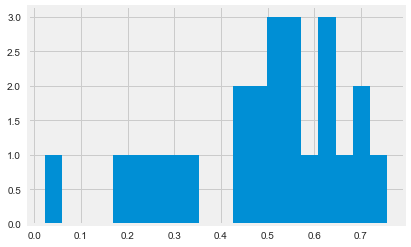

In [22]:
plt.hist(X_withscores[X_withscores['Clin+'] == "Y"]['score'], bins=20)
X_withscores[X_withscores['Clin+'] == "Y"]['score']

In [23]:
X_withscores[X_withscores['pathogenic_green']==True]
X_withscores[X_withscores['microbe']=='Chikungunya virus']


RNAvalue  DNAvalue  nrnt  groupID  ranks            microbe  \
1024  3.262712  3.262712     1        3      1  Chikungunya virus   
1206  2.387034  2.387034     1        3      1  Chikungunya virus   
1272  3.740118  3.740118     1        3      1  Chikungunya virus   

                    patient  microbe_genus  nt_Z_rna  nt_Z_dna      ...        \
1024  chrf_rna_0012_s12.csv          11019      99.0      99.0      ...         
1206  chrf_rna_0071_s71.csv          11019      99.0      99.0      ...         
1272  chrf_rna_0094_s94.csv          11019      99.0      99.0      ...         

      pathogenic_green  pathogenic_darkblue  positive     score  Clin+ LRM+  \
1024              True                False     False  0.673218      N    Y   
1206              True                False     False  0.592731      N    Y   
1272              True                False     False  0.713457      N    Y   

     RBM+               Study ID  keep  LRTI Category  
1024    Y  chrf_rna_0012_s12.csv  True       unk-LRTI  
1206    Y  chrf_rna_0071_s71.csv  True       unk-LRTI  
1272    Y  chrf_rna_0094_s94.csv  True       unk-LRTI  

[3 rows x 21 columns]

In [24]:
# This finalizes the output for TableS3B (Publication version)

table3B = X_withscores[X_withscores['keep']][['Study ID',
                                              'LRTI Category', 
                                              'microbe', 
                                              'Clin+', 
                                              'LRM+', 
                                              'RBM+',
                                              'RNAvalue',
                                              'DNAvalue',
                                              'ranks',
                                              'pathogenic_red',
                                              'pathogenic_green',
                                              'score',
                                              'nt_Z_rna',
                                              'nt_Z_dna']]

adding_to_df = []
for i in set(list(X_withscores['Study ID'])):
    if i not in list(table3B['Study ID']):
        adding_to_df.append(
            [i, str(list(X_withscores[X_withscores['Study ID']==i]['LRTI Category'])[0])] + 
            [None for i in range(12)])
        
df2 = pd.DataFrame(adding_to_df, columns=table3B.columns)
x = table3B.append(df2)
table3B = x

table3B.columns = ['Study ID',
                   'LRTI Category', 
                   'Microbe', 
                   'Clin+', 
                   'LRM+', 
                   'RBM+',
                   'log10( RNA-seq genus rpM )',
                   'log10( DNA-seq genus rpM )',
                   'Rank','Respiratory Pathogen?',
                   'Virus?',
                   'LRM Score',
                   'RNA Z-score',
                   'DNA Z-score']

table3B.sort_values(by=['Study ID','Rank'], inplace=True)
table3B_1 = table3B[table3B['LRTI Category'] == 'LRTI+C/+M']
table3B_2 = table3B[table3B['LRTI Category'] == 'LRTI+C']
table3B_3 = table3B[table3B['LRTI Category'] == 'unk-LRTI']
table3B_4 = table3B[table3B['LRTI Category'] == 'no-LRTI']

t3 = pd.concat([table3B_1,table3B_2,table3B_4,table3B_3])
t3.tail(n=10)
t3.to_csv('./output/' + output_directory + '/TableS3Bfinal.csv',index=False)

## Preliminary version of Figure 3 - combining all methods of pathogen prediction

This is used to rapidly assess the microbial predictions, however it DID NOT end up in the manuscript due to the difficulty protraying the take-home message.

in except
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12]
['CHRF_0005', 'CHRF_0041', 'CHRF_0088', 'CHRF_0029', 'CHRF_0052', 'CHRF_0017', 'CHRF_0064', 'CHRF_0076', 'CHRF_0003', 'CHRF_0026', 'CHRF_0002', 'CHRF_0051', 'CHRF_0061', 'CHRF_0073', 'CHRF_0062', 'CHRF_0086', 'CHRF_0049', 'CHRF_0085', 'CHRF_0025', 'CHRF_0014', 'CHRF_0074', 'CHRF_0027', 'CHRF_0037', 'CHRF_0075', 'CHRF_0038', 'CHRF_0087', 'CHRF_0050', 'CHRF_0001', 'CHRF_0063', 'CHRF_0028', 'CHRF_0039', 'CHRF_0004', 'CHRF_0040', 'CHRF_0013', 'CHRF_0015', 'CHRF_0016', 'CHRF_0006', 'CHRF_0007', 'CHRF_0008', 'CHRF_0009', 'CHRF_0018', 'CHRF_0019', 'CHRF_0020', 'CHRF_0021', 'CHRF_0030', 'CHRF_0031', 'CHRF_0032', 'CHRF_0042', 'CHRF_0043',

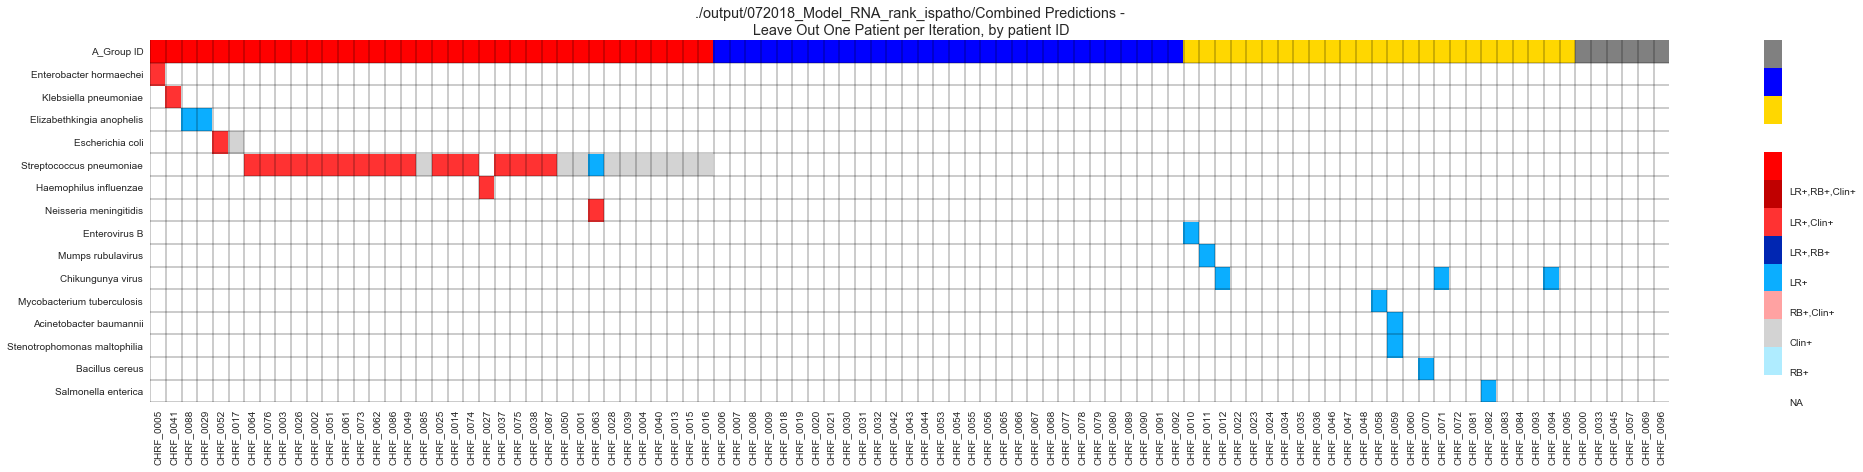

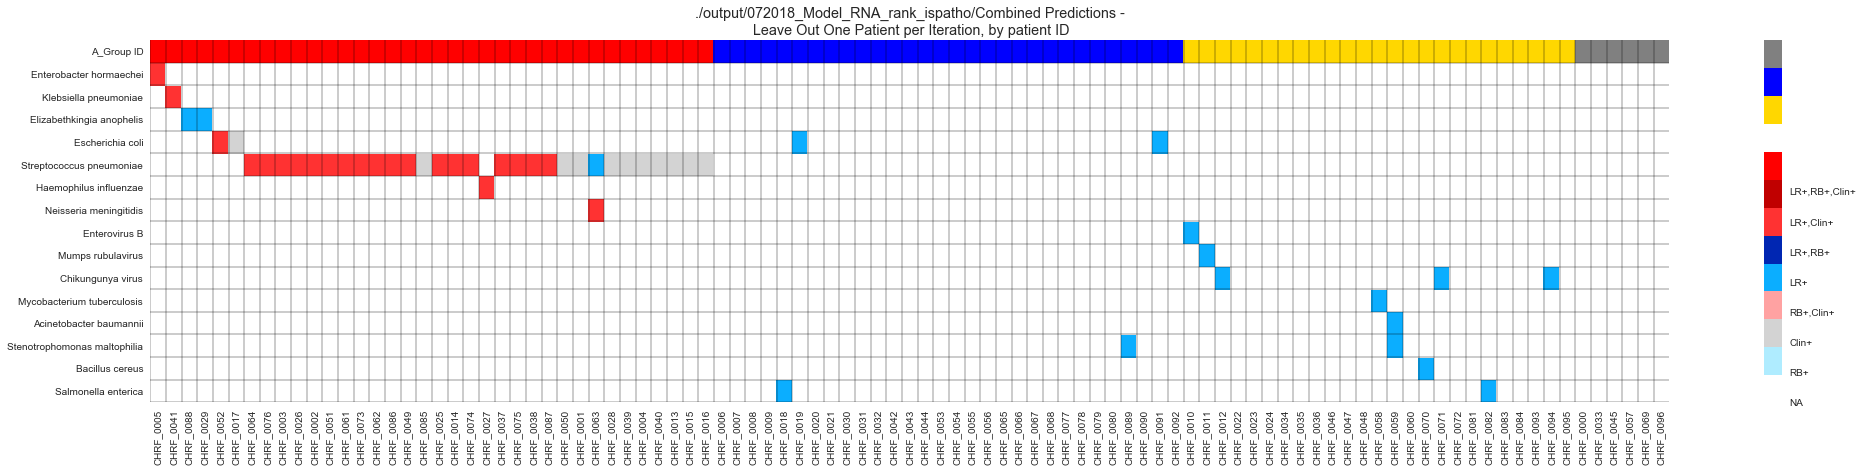

In [25]:

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

gcombos = []

# TRYING TO CREATE COMBO HEATMAP THAT WILL TAKE IN THE INPUTS FROM ALL G1, G4, G2/3 and output the color-coded heatmap
# NOVEMBER 27

def create_prediction_heatmap_combo_overlap(input_rbm_data, input_lr_data, original_matrix, filename, groupID, true_classification, output_directory, metadata, training_sample_names, output_filename, print_output = False, collapse=True, diversity = None, DIVERSITY_THRESHOLD=1):

    input_rbm_data.to_csv('./output/' + output_directory + '/TableS6A.csv')
    input_lr_data.to_csv('./output/' + output_directory + '/TableS6B.csv')

    # new colors - using shade to indicate group, color to indicate clin +
    # WHITE, RB only (light blue), clin only (light grey), RB + Clin (light red), LR only (med blue), LR + RM (dark blue), LR + Clin (med red), LR + RB + Clin (dark red)
    colors = ['white',
              '#AFECFF',
              'lightgrey',
              '#FFA2A2',
              '#0BAEFF',
              '#0026B2',
              '#FF3232',
              '#C00000',
             'red','white','gold','blue','grey'] # trying to make the above colors more distinct

    CustomCmap = matplotlib.colors.ListedColormap(colors)
    yay_v = 0

    d = pd.DataFrame(0, index=np.arange(len(set(input_lr_data['microbe']))), columns=[i.split('.')[0].lower()+'.report.csv' for i in list(set(original_matrix['patient']))])
    d.index = set(input_lr_data['microbe'])
    #print(d)

    #loop through every patient and create a new column for each patient
    #add all group 1s
    g1s_train = []
    g1s_test = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 1:
                if(i.lower()+'.report.csv' in training_sample_names):
                    g1s_train.append(i.lower()+'.report.csv')
                else:
                    g1s_test.append(i.lower()+'.report.csv')
                #g1s.append(i+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]
    #add all group 4s
    g4s_train = []
    g4s_test = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 4:
                if(i.lower()+'.report.csv' in training_sample_names):
                    g4s_train.append(i.lower()+'.report.csv')
                else:
                    g4s_test.append(i.lower()+'.report.csv')
                #g4s.append(i+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]
    #add all group 2s
    g2s = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 2:
                g2s.append(i.lower()+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]
    #add all group 3s
    g3s = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 3:
                g3s.append(i.lower()+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]

    #add all group 5s
    g5s = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 5:
                g5s.append(i.lower()+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    #print('HIIIIII')
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]

    #print(metadata.head())
    #print(input_rbm_data['patient'].head())
    #print(metadata[metadata['sample_name_RNA'] == input_lr_data.iloc[i]['patient'].split('.')[0].upper()]['organism'].iloc[0])
    
    
    
    '''
    # ADD VALUES FOR RB method
    for i in input_rbm_data.index:
        print(input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv')
        print(input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv' in list(diversity.index))
        print(diversity.index)
        print(diversity.head())
        print(diversity.loc[input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv'])
        if diversity.loc[input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv']['input'] > DIVERSITY_THRESHOLD:
            d[input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_rbm_data.iloc[i]['microbe']] = 1
            orgs = metadata[metadata['sample_name_RNA'] == input_rbm_data.iloc[i]['patient'].split('.')[0].upper()]['organism'].iloc[0]
            #print(orgs)
            if(type(orgs) == type('string')):
                if input_rbm_data.iloc[i]['microbe'] in orgs.split(','):
                    yay_v += 1
                    d[input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_rbm_data.iloc[i]['microbe']] = d[input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_rbm_data.iloc[i]['microbe']] + 2

    '''
    
        # ADD VALUES FOR LR method
    for i in input_lr_data.index:
        #print(i)
        #print(input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv')
        #print(input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv' in list(diversity.index))
        
        
        if diversity.loc[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'] > DIVERSITY_THRESHOLD:
        
            try:
                #print(d.columns)
                #print(input_lr_data.iloc[i]['patient'])
                #print(input_lr_data.iloc[i]['microbe'])
                d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] = d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] + 4   #try to just add to existing values
            except:
                #NEED TO ADD THE ROW
                new_index = [ v for v in d.index] + [input_lr_data.iloc[i]['microbe']]
                d.loc[len(d)]=[0 for i in range(len(d.columns))]
                d.index = new_index
                d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] = 4   # if the value has not existed before, add to the dataframe

            orgs = metadata[metadata['sample_name_RNA'] == input_lr_data.iloc[i]['patient'].split('.')[0].upper()]['organism'].iloc[0]   # loop through all the organisms
            if(type(orgs) == type('string')):
                if input_lr_data.iloc[i]['microbe'] in orgs.split(','):
                    yay_v += 1
                    #print(d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']])
                    if d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] not in [3,7]:  # if the organism is confirmed, but has not previously been clinically confirmed then...add clinical to it
                        d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] = d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] + 2

    # LOOP THROUGH AND ADD CLINICAL GENERA
    #print("???")
    #print(len(set(input_lr_data.index)))
    #print(metadata.shape)

    for i in metadata.index:#input_lr_data.index:
        #print(i)
        index = metadata.loc[i]['sample_name_RNA'].lower()+'.report.csv'
        #print(index)
        
        #print(metadata.loc[i]['organism'])
        #print()
        orgs = metadata.loc[i]['organism']#[metadata['sample_name_RNA'] == input_lr_data.iloc[i]['patient'].split('.')[0].upper()]['organism'].iloc[0]
        if(type(orgs) == type('string')):
            #print(input_lr_data.iloc[i]['patient'])
            #print(orgs)
            '''
            for o in orgs.split(','):
                #list_of_species = list(set(input_lr_data.loc[input_lr_data['microbe_genus']==o]['microbe']).union(set(input_lr_data.loc[input_lr_data['microbe_genus']==o]['microbe'])))
                list_of_species = list(set(input_lr_data.loc[input_lr_data['microbe']==o]['microbe']).union(set(input_lr_data.loc[input_lr_data['microbe']==o]['microbe'])))
                print(list_of_species)
                a_species_was_found = False
                for s in list_of_species:
                    if not a_species_was_found:
                        try:
                            if d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][s] > 0:
                                a_species_was_found = True
                        except:
                            continue

                #print(a_species_was_found)

                if not a_species_was_found:
                    if sum([int(o == v ) for v in  d.index]) > 0:
                        print(o)
                        print(i)
                        print(input_lr_data.head())
                        d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][o] = 2
                    else:
                        new_index = [ v for v in d.index] + [o]
                        d.loc[len(d)]=[0 for i in range(len(d.columns))]

                        d.index = new_index
                        d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][o] = 2

            '''
            for o in orgs.split(','):
                #print(o)
                try:
                    #print('indise Try')
                    #print(d[index][o])
                    if d[index][o] > 0:
                        a_species_was_found = True
                    else:
                        d[index][o] = 2
                except:
                    print('in except')
                    new_index = [ v for v in d.index] + [o]
                    d.loc[len(d)]=[0 for i in range(len(d.columns))]
                    d.index = new_index
                    d[index][o] = 2




    #gcombos = g1s_train + g1s_test + g4s_train +  g4s_test + g2s + g3s + g5s
    #print("GCOMBOS")
    #print(gcombos)
    gcombos = [i.split('/')[-1].split('.')[0] + '.report.csv' for i in ordered_list_of_files]
    
    d = d[gcombos] # this sorts the columns in order of [group1] [group4]

    #'''
    groupid_names = [i.split('/')[-1].split('.')[0].upper() for i in ordered_list_of_files]
    groupids = []
    for i in groupid_names:
        groupids.append(
            metadata[metadata['sample_name_RNA'] == i]['effective_group'][0] + 7
        )
    d.loc['A_Group ID'] = groupids
    print(groupids)
    #'''
    
    
    #reset names to remove .report.csv notation
    new_col_names = []
    for i in d.columns:
        new_col_names.append(i.split('.')[0])
    d.columns = new_col_names




    # Apply some collapsing for the indices
    if(collapse):
        strep_viridans_group = ['Streptococcus pseudopneumoniae ( 257758 )','Streptococcus sp. VT 162 ( 1419814 )',
                                'Streptococcus salivarius ( 1304 )','Streptococcus mitis ( 28037 )',
                                'Streptococcus pseudopneumoniae ( 257758 )','Streptococcus anginosus ( 1328 )']
        strep_preprocessed_names = []
        #print(d.index)
        for i in d.index:
            if(i in strep_viridans_group):
                strep_preprocessed_names.append('Streptococci viridans Group ( XXX )')
            elif('coronavirus' in i):
                strep_preprocessed_names.append('Human coronavirus species ( XXX )')
            else:
                strep_preprocessed_names.append(i)  # strep pneumo and strep genera (clinical) will be merged

        d.index = strep_preprocessed_names
        first_values = [' '.join(i.split(' ')[0:-4]) if i.count(' ') > 3 else ' '.join(i.split(' ')[0:-3]) for i in d.index]
        d.index = first_values


        for j in d.columns:
            for k in set(first_values):
                #print(k)
                l = list(d[j][d.index==k])
                #print(l)
                if 2 in l and 3 in l:
                    # this is bad - it will collapse incorrectly and appear the BM and LR matched (score = 5),
                    # when in reality it was a collapse of RB+Clin (3) and Clin+ (3) again - need to modify the cases post-hoc.
                    #print([3] + [0 for i in range(len(l)-1)])
                    d[j][d.index==k] = [3] + [0 for i in range(len(l)-1)]





        d = d.groupby(d.index).sum()

        post_mod_index = []  # MODIFICATIONS TO UPDATE NAME OF STREP AND STAPH TO BE CLEAR
        for i in d.index:
            if(i == 'Streptococcus'):
                post_mod_index.append('Streptococcus pneumoniae')
            elif(i == 'Staphylococcus'):
                post_mod_index.append('Staphylococcus aureus')
            elif(i == 'Human respiratory syncytial'):
                post_mod_index.append('Human RSV')
            else:
                post_mod_index.append(i)

        d.index = post_mod_index

    


    # sort the indices by alphabetical order
    new_d = d.sort_index(axis=0)
    d = new_d
    d = d[d.sum(axis=1) > 0]
    
    
    manual_sorting = ['A_Group ID',
               'Enterobacter hormaechei',
              'Klebsiella pneumoniae',
              'Elizabethkingia anophelis',
              'Escherichia coli',
              'Streptococcus pneumoniae',
              'Haemophilus influenzae',
              'Neisseria meningitidis',
              'Enterovirus B',
              'Mumps rubulavirus',
              'Chikungunya virus',
              'Mycobacterium tuberculosis',
              'Acinetobacter baumannii',
              'Stenotrophomonas maltophilia',
              'Bacillus cereus',
              'Salmonella enterica']
    
    d = d.loc[manual_sorting]
    
    new_columns = ['_'.join([c.split('_')[0],c.split('_')[2]]).upper() for c in d.columns]
    #new_cols_temp = ['TA-' + str(c.split('-')[1]) for c in d.columns]  #convert names to TA-XXX notation
    #new_columns = [i[0:6] for i in new_cols_temp]  #get rid of TRNA from the one sample that has weird naming convention
    print(new_columns)
    d.columns = new_columns




    fig_height = (d.shape[0]/4.8)*2
    #fig_width = d.shape[1]/4.8
    fig_width = (d.shape[1]/6.4)*2

    #d.to_csv('LRcombo.csv')

    if print_output:
        print(d.head())

    #colors = ['white','#4AA2B6','lightgrey','#04819E','#69DE56','#F93846','#1DD300','#F90012']
    #ordered_colors = ['white','lightgrey','deepskyblue','blue','yellow','gold','orange','red']

    cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))


    plt.figure(figsize=(fig_width,fig_height))
    #ax = sns.heatmap(d,cmap=CustomCmap,vmin=0,vmax=7,cbar=False)
    ax = sns.heatmap(d,cmap=cmap,vmin=0,vmax=12)#,row_colors='red')#,cbar=False)
    ax.hlines([i for i in range(len(d.index))], *ax.get_xlim(),lw=.4)
    ax.vlines([i for i in range(len(d.columns))], *ax.get_ylim(),lw=.4)
    ax.tick_params(labelsize=10)
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([i for i in range(len(colors))])
    colorbar.set_ticks([0,2,1,3,4,6,5,7])
    colorbar.set_ticklabels(['NA','Clin+','RB+','RB+,Clin+','LR+','LR+,Clin+','LR+,RB+','LR+,RB+,Clin+'])
    #colorbar.set_ticklabels(['NA','RB+','Clin+','RB+,Clin+','LR+','LR+,RB+','LR+,Clin+','LR+,RB+,Clin+'])

    plt.title( filename + ", by patient ID")
    plt.savefig('./output/' + output_directory + '/' + output_filename , bbox_inches='tight')

    return d



lr_results = pd.concat([ 
                        patient_by_microbe_predicted_g2]) #,patient_by_microbe_predicted_g4_test, 
lr_results.reset_index(inplace=True)
c = pd.concat([rbm_g1,rbm_g4,rbm_g2,rbm_g3])
c.reset_index(inplace=True)

X_full = pd.concat([X_g1,X_g4,X_g2,X_g3])

# this representation enables easy viewing of the overlap btwn clinical and predicted results
# unfortunately, the published TableS2 does not highlight this aspect of the data as well, 
# so I am maintaining this graphic here.
#
d = create_prediction_heatmap_combo_overlap(c,lr_results,X_full, 
                                            './output/' +  output_directory + 
                                              '/Combined Predictions -\n Leave Out One Patient per Iteration',
                                               [1,4,2,3],
                                                               true_classification[true_classification.index.notnull()], 
                                                               output_directory, 
                                                               metadata, 
                                                               training_sample_names,
                                                               'FigureS3_TrainTest.pdf', 
                                                               print_output = False, 
                                                               collapse=False,
                                                               diversity = log(rna_input['RNA_input']+1),
                                                                DIVERSITY_THRESHOLD = 1.4)# pd.concat([pd.Series(RNA_diversity),pd.Series(DNA_diversity)], axis=1).max(axis=1),
                                                               #DIVERSITY_THRESHOLD=.6)
print("DONE WITH THE FIRST HEATMAP")

d = create_prediction_heatmap_combo_overlap(c,lr_results,X_full, 
                                            './output/' +  output_directory + 
                                              '/Combined Predictions -\n Leave Out One Patient per Iteration',
                                               [1,4,2,3],
                                                               true_classification[true_classification.index.notnull()], 
                                                               output_directory, 
                                                               metadata, 
                                                               training_sample_names,
                                                               'FigureS3_TrainTest_nodivthresh.pdf', 
                                                               print_output = False, 
                                                               collapse=False,
                                            diversity = log(rna_input['RNA_input']+1),
                                            DIVERSITY_THRESHOLD = 0
                                           #diversity = pd.concat([pd.Series(RNA_diversity),pd.Series(DNA_diversity)], axis=1).mean(axis=1),
                                                               )

In [26]:
X_withscores[X_withscores['patient'] == 'chrf_rna_0005_s5.csv'][['RNAvalue','ranks','microbe','microbe_genus','pathogenic_red','score']].sort_values(by='RNAvalue', ascending = False)

RNAvalue  ranks                                microbe  microbe_genus  \
0   2.669224      1                Enterobacter hormaechei            547   
1   1.842609      2                Lactobacillus crispatus           1578   
2   1.613842      3                   Citrobacter freundii            544   
3   0.857332      4                Fusobacterium nucleatum            848   
4   0.672098      5                  Streptomyces anulatus           1883   
5   0.612784      6                Pluralibacter gergoviae        1330546   
6   0.342423      7                 Alcanivorax xenomutans          59753   
7   0.301030      8            uncultured Ruminococcus sp.           1263   
8   0.204120      9  Methylophaga nitratireducenticrescens          40222   
9   0.204120     10                  Cronobacter sakazakii         413496   
10  0.176091     11                     Vibrio sp. 04Ya090            662   
11  0.113943     12                   Betapapillomavirus 2         333922   
15  0.041393     16            Paenibacillus riograndensis          44249   
14  0.041393     15               Photorhabdus luminescens          29487   
12  0.041393     13                     Atopobium parvulum           1380   
13  0.041393     14              Gloeomargarita lithophora        1188227   

    pathogenic_red     score  
0             True  0.619459  
1            False  0.021978  
2            False  0.010766  
3            False  0.004257  
4            False  0.002102  
5            False  0.001090  
6            False  0.000520  
7            False  0.000271  
8            False  0.000138  
9            False  0.000073  
10           False  0.000038  
11           False  0.000020  
15           False  0.000002  
14           False  0.000003  
12           False  0.000010  
13           False  0.000005

In [27]:
ct_values = metadata[['CT value from qPCR_RNA']].fillna(0)
ct_values[ct_values['CT value from qPCR_RNA']==' Negative'] = 0
ct_values.index = [i.lower() for i in list(metadata['sample_name_RNA'])]

plt.figure(figsize=(15,2))
float_values = [-1*float(i) for i in list((ct_values.loc[list(d.columns)])['CT value from qPCR_RNA'])]
ct_plot = (pd.Series(dict(zip(d.columns,float_values))).loc[list(d.columns)]).plot(kind='bar', color='dodgerblue', width=.9, alpha = .5,ylim=[-50,0])
plt.savefig('./output/' + output_directory + '/CT_barplot.pdf' , bbox_inches='tight')

KeyError: "None of [['CHRF_0005', 'CHRF_0041', 'CHRF_0088', 'CHRF_0029', 'CHRF_0052', 'CHRF_0017', 'CHRF_0064', 'CHRF_0076', 'CHRF_0003', 'CHRF_0026', 'CHRF_0002', 'CHRF_0051', 'CHRF_0061', 'CHRF_0073', 'CHRF_0062', 'CHRF_0086', 'CHRF_0049', 'CHRF_0085', 'CHRF_0025', 'CHRF_0014', 'CHRF_0074', 'CHRF_0027', 'CHRF_0037', 'CHRF_0075', 'CHRF_0038', 'CHRF_0087', 'CHRF_0050', 'CHRF_0001', 'CHRF_0063', 'CHRF_0028', 'CHRF_0039', 'CHRF_0004', 'CHRF_0040', 'CHRF_0013', 'CHRF_0015', 'CHRF_0016', 'CHRF_0006', 'CHRF_0007', 'CHRF_0008', 'CHRF_0009', 'CHRF_0018', 'CHRF_0019', 'CHRF_0020', 'CHRF_0021', 'CHRF_0030', 'CHRF_0031', 'CHRF_0032', 'CHRF_0042', 'CHRF_0043', 'CHRF_0044', 'CHRF_0053', 'CHRF_0054', 'CHRF_0055', 'CHRF_0056', 'CHRF_0065', 'CHRF_0066', 'CHRF_0067', 'CHRF_0068', 'CHRF_0077', 'CHRF_0078', 'CHRF_0079', 'CHRF_0080', 'CHRF_0089', 'CHRF_0090', 'CHRF_0091', 'CHRF_0092', 'CHRF_0010', 'CHRF_0011', 'CHRF_0012', 'CHRF_0022', 'CHRF_0023', 'CHRF_0024', 'CHRF_0034', 'CHRF_0035', 'CHRF_0036', 'CHRF_0046', 'CHRF_0047', 'CHRF_0048', 'CHRF_0058', 'CHRF_0059', 'CHRF_0060', 'CHRF_0070', 'CHRF_0071', 'CHRF_0072', 'CHRF_0081', 'CHRF_0082', 'CHRF_0083', 'CHRF_0084', 'CHRF_0093', 'CHRF_0094', 'CHRF_0095', 'CHRF_0000', 'CHRF_0033', 'CHRF_0045', 'CHRF_0057', 'CHRF_0069', 'CHRF_0096']] are in the [index]"

<Figure size 1080x144 with 0 Axes>

In [ ]:
print(gcombos)

plt.figure(figsize=(15,3))
rna_div_plot = pd.Series(RNA_diversity).loc[list(d.columns)].plot(kind='bar', color='dodgerblue', width=.9, alpha = .5,ylim=[0,1])
#dna_div_plot = pd.Series(DNA_diversity).loc[list(d.columns)].plot(kind='bar', color='green', width=.9, alpha = .5)
plt.axhline(y=.6, linestyle=':', lw=.75, color='orange')
plt.savefig('./output/' + output_directory + '/rna_div_barplot.pdf' , bbox_inches='tight')

plt.figure(figsize=(15,3))
#rna_div_plot = pd.Series(RNA_diversity).loc[list(d.columns)].plot(kind='bar', color='dodgerblue', width=.9, alpha = .5)
dna_div_plot = pd.Series(DNA_diversity).loc[list(d.columns)].plot(kind='bar', color='green', width=.9, alpha = .5,ylim=[0,1])
plt.axhline(y=.6, linestyle=':', lw=.75, color='orange')
plt.savefig('./output/' + output_directory + '/dna_div_barplot.pdf' , bbox_inches='tight')


plt.figure(figsize=(15,3))
pd.concat([pd.Series(RNA_diversity),pd.Series(DNA_diversity)], axis=1).max(axis=1).loc[list(d.columns)].plot(kind='bar', color='purple', width=.9, alpha = .8,ylim=[0,1])
plt.axhline(y=.6, linestyle=':', lw=.75, color='orange')
plt.savefig('./output/' + output_directory + '/max_div_barplot.pdf' , bbox_inches='tight')

plt.figure(figsize=(15,3))
(1-pd.concat([pd.Series(RNA_diversity),pd.Series(DNA_diversity)], axis=1).max(axis=1)).loc[list(d.columns)].plot(kind='bar', color='purple', width=.9, alpha = .8,ylim=[0,1])
plt.axhline(y=.4, linestyle=':', lw=1, color='orange')
plt.savefig('./output/' + output_directory + '/max_div_barplot.pdf' , bbox_inches='tight')


plt.figure(figsize=(15,3))
pd.concat([pd.Series(RNA_diversity),pd.Series(DNA_diversity)], axis=1).mean(axis=1).loc[list(d.columns)].plot(kind='bar', color='#2e94ad', width=.9, alpha = .8,ylim=[0,1])
plt.axhline(y=.6, linestyle=':', lw=.75, color='orange')
plt.savefig('./output/' + output_directory + '/mean_div_barplot.pdf' , bbox_inches='tight')

print(pd.concat([pd.Series(RNA_diversity),pd.Series(DNA_diversity)], axis=1).mean(axis=1).loc[list(d.columns)].loc['chrf_rna_0065_s65'])